# 0.0. IMPORTS

In [236]:
import math
import datetime
import warnings
import pandas as pd
import inflection
import numpy as np
from numpy import int64
import seaborn as sns
import xgboost as xgb
import random
import pickle
import requests

from scipy                 import stats
from boruta                import BorutaPy
from matplotlib            import pyplot as plt
from matplotlib            import gridspec
from IPython.display       import Image
from IPython.core.display  import display, HTML

from sklearn.metrics       import mean_absolute_error, mean_squared_error
from sklearn.ensemble      import RandomForestRegressor
from sklearn.linear_model  import LinearRegression, Lasso
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder

warnings.filterwarnings('ignore')

In [2]:
# O comando abaixo configura a exibição das celulas e valores para utilizar 100% da largura da tela. 
display(HTML("<style>.container { width:100% !important; }</style>"))

## 0.1. Helper Funcions

In [3]:
# Cria a função para realizar o Cross Validation, dividindo os dados de treino e validação para cada iteração.
def cross_validation (x_training, kfold, model_name, model):
    # x_training: dados de treino.
    # kfold: número de iterações.
    # model_name: nome do modelo de ML.
    # model: modelo de ML utilizado.
    
    # Cria listas para armazenar os erros mae, mape e rmse.
    mae_list = []
    mape_list = []
    rmse_list = []

    for k in range(kfold, 0, -1):  # o valor de k varia de kfold até 1.
        print('\nKFold Number: {}'.format(k))  # \n utilizado para pular linha.

        # Define as datas de inicio e fim dos dados que serão utilizados na validação do Cross Validation.

        # Cria a variável validation_start_date contendo a data de inicio dos dados de validação.
        # Subtrai 6 semanas vezes o valor de k da última data de venda do dataset de treino x_training:
        validation_start_date = x_training['date'].max() - datetime.timedelta(days=k*6*7)

        # Cria a variável validation_end_date contendo a data final dos dados de validação.
        # Subtrai 6 semanas vezes o valor de k-1 da última data de venda do dataset de treino x_training:
        validation_end_date = x_training['date'].max() - datetime.timedelta(days=(k-1)*6*7)


        # filtering dataset
        # Cria um dataset de treino chamado training com todas as linhas que possuirem o valor da data menor que o valor da
        # data do inicio da validação, armazenada na variável validation_start_date:
        training = x_training[x_training['date'] < validation_start_date]


        # Cria um dataset de validação chamado validation com todas as linhas que possuirem o valor da data maior ou igual ao valor
        # da data do inicio da validação, armazenada na variável validation_start_date e que possuírem o valor da data menor ou igual
        # ao valor da data final dos dados de validação, armazenado na variável validation_end_date:
        validation = x_training[(x_training['date'] >= validation_start_date) & (x_training['date'] <= validation_end_date)]


        # Cria os datasets finais de treino e validação

        # training
        # Cria o dataset de treino xtraining excluíndo as colunas date e sales:
        xtraining = training.drop(['date', 'sales'], axis =1)
        # Cria o dataset de treino ytraining considerando apenas a coluna sales:
        ytraining = training['sales']

        # validation
        # Cria o dataset de validação xvalidation excluíndo as colunas date e sales:
        xvalidation = validation.drop(['date', 'sales'], axis =1)
        # Cria o dataset de validação yvalidation considerando apenas a coluna sales:
        yvalidation = validation['sales']


        # model
        # O comando abaixo armazena na variável lr o resultado do treino utilizando a classe LinearRegressor que 
        # é o modelo de regressão linear. Utiliza os dados de treino x_training e y_training.
        m = model.fit(xtraining, ytraining)


        # prediction
        # Utiliza o método predict para realizar o teste do modelo utilizando os dados de teste xvalidation.
        # Cria uma variável yhat_lr para armazenar a predição do teste.
        yhat = m.predict(xvalidation)


        # performance
        # Cria a variável lr_result para armazenar os resultados da performance do modelo calculado pela função ml_error.
        m_result = ml_error(model_name, np.expm1(yvalidation), np.expm1(yhat) )

        # store performance of each kfold iteration
        # armazena nas listas mae, mape e rmse os valores de seus respectivos erros para cada iteração.
        mae_list.append(m_result['MAE'])
        mape_list.append(m_result['MAPE'])
        rmse_list.append(m_result['RMSE'])

        
    # o comando abaixo cria um dataframe com o resultado da média e desvio padrão para cada um dos erros.
    # o comando np.round( ,2) armazena apenas duas casas decimais.
    return pd.DataFrame( {'Model Name': model_name,
                          'MAE_CV': np.round(np.mean(mae_list), 2).astype(str) + ' +/- ' + np.round(np.std(mae_list), 2).astype(str),
                          'MAPE_CV': np.round(np.mean(mape_list), 2).astype(str) + ' +/- ' + np.round(np.std(mape_list), 2).astype(str),
                          'RMSE_CV': np.round(np.mean(rmse_list), 2).astype(str) + ' +/- ' + np.round(np.std(rmse_list), 2).astype(str)}, index=[0])


# Cria a função mean_percentage_error para o erro MPE.
def mean_percentage_error(y, yhat):
    # Calcula a média de todas as porcentagens de erro
    return np.mean((y - yhat) / y)


# Cria a função mean_absolute_percentage_error para calcular a performance dos modelos.
def mean_absolute_percentage_error(y, yhat):
    # calcula o módulo da porcentagem do erro para cada valor.
    # Calcula a média de todas as porcentagens de erro
    return np.mean(np.abs((y - yhat) / y))

# Cria a função ml_error para calcular a performance dos modelos.
def ml_error(model_name, y, yhat):
    # model_name = nome do modelo.
    # y = dados originais.
    # yhat = predições.
    mae = mean_absolute_error (y, yhat)
    mape = mean_absolute_percentage_error(y, yhat)
    rmse = np.sqrt(mean_squared_error(y, yhat))
    
    # retorna um dataframe com os valores de performance do modelo.
    return pd.DataFrame ({'Model Name': model_name,
                         'MAE': mae,
                         'MAPE': mape,
                         'RMSE': rmse}, index=[0])


# Função para calcular o V de Cramer utilizada no análise exploratória de dados,
# na seção análise multivariada para as variáveis categóricas.
# Foram realizadas as correções de Bias Correction na fórmula,
# conforme descrito no link: https://en.wikipedia.org/wiki/Cram%C3%A9r%27s_V.
def cramer_v(x, y):
    cm = pd.crosstab(x, y).values
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = stats.chi2_contingency(cm)[0] 
    chi2corr = max(0, chi2-(((k-1)*(r-1))/(n-1)))
    
    kcorr = k - (k - 1)**2 / (n - 1)
    rcorr = r - (r - 1)**2 / (n - 1)
    
    return np.sqrt((chi2corr/n) / (min(kcorr-1, rcorr-1)))


# Função para setar os parâmetros do Jupiter Notebook:
#def jupiter_settings():
#    %maptplotlib inline
#    %pylab inline
#    
#    plt.style.use('bmh')
#    plt.rcParams['figure.figsize'] = [25,12]
#    plt.rcParams['font.size'] = 24
#    
#    display(HTML("<style>.container { width:100% !important; }</style>"))
#    pd.options.display.max_columns = None
#    pd.options.display.max_rows = None
#    pd.set_option('display.expand_frame_repr', False)
#    
#    sns.set()

## 0.2 Loading Data

In [4]:
# low memory = False significa que vai carregar todo o arquivo em memória. Caso tenho restrição com memória,
# low_memory=True carrega chunks do arquivo na memória.
df_sales_raw = pd.read_csv('data/train.csv', low_memory=False)
df_store_raw = pd.read_csv('data/store.csv', low_memory=False)

# Realiza o merge dos dois datasets df_sales_raw e df_store_raw. O atributo on='Store' define que a coluna Store é 
# a coluna que aparece em ambos os datasets e será utilizado como chave para fazer o merge.
df_raw = pd.merge(df_sales_raw, df_store_raw, how='left', on='Store')

In [5]:
# O comando sample exibe uma linha aleatória do dataset.
df_raw.sample()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
325341,169,6,2014-09-27,4745,492,1,0,0,0,d,a,980.0,7.0,2014.0,1,18.0,2014.0,"Feb,May,Aug,Nov"


# 1.0. PASSO 01 - DESCRIÇÃO DOS DADOS

In [6]:
# É recomendado realizar uma cópia do dataset em cada um das seçoes do Jupyter Notebook, pois se o notebook tem muitas seções
# e em um exemplo onde estamos na última seção e reescrevemos os dados originais e ocorre um erro. Neste caso para recuperarmos
# os dados originais, temos que voltar na primeira seção do Jupyter Notebook e executar todas as linhas até o final.
# Para evitar este problema é recomendado criar uma cópia do dataset em cada seção.
df1 = df_raw.copy()

## 1.1 Rename Columns

In [7]:
# Exibe as colunas do dataset df1, no formato original CamelCase.
df1.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

In [8]:
# Cria uma lista com os nomes originais das colunas.
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday', 'StoreType',
            'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
            'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval']

# Altera o estilo dos nomes das colunas de CamelCase para SnakeCase utilizando a função abaixo.
snakecase = lambda x: inflection.underscore(x)

# A função map executa a função snakecase em todas as palavras da lista cols_old. A saída desta função é convertida em uma 
# lista e armazenada na lista cols_new.
cols_new = list(map(snakecase, cols_old))

# Renomeia o nome das colunas no dataset df1.
df1.columns = cols_new

In [9]:
# Exibe o nome das colunas do dataset df1 no formato alterado snakecase.
df1.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval'],
      dtype='object')

## 1.2 Data Dimensions

In [10]:
print('Number of rows: {}'.format(df1.shape[0]))
print('Number of columns: {}'.format(df1.shape[1]))

Number of rows: 1017209
Number of columns: 18


## 1.3 Data Types

In [11]:
df1.dtypes

store                             int64
day_of_week                       int64
date                             object
sales                             int64
customers                         int64
open                              int64
promo                             int64
state_holiday                    object
school_holiday                    int64
store_type                       object
assortment                       object
competition_distance            float64
competition_open_since_month    float64
competition_open_since_year     float64
promo2                            int64
promo2_since_week               float64
promo2_since_year               float64
promo_interval                   object
dtype: object

In [12]:
# Altera o tipo dos valore da coluna date de object (string) para data.
df1['date'] = pd.to_datetime(df1['date'])

In [13]:
df1.dtypes 

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4 Check NA

In [14]:
# O método isna exibe todas as linhas que possuem valores vazios. O método sum exibe a quantidade de linhas que possuem 
# valores vazios / NA(não aplicável).
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5 Fillout NA

### 1.5.1. competition_distance

In [15]:
# competition_distance
# No site do Kagle temos a seguinte definição para esta coluna: distance in meter to the nearest competitor store.
# Iremos verificar no dataset qual é a distância em metros do competidor mais distante.
print(df1['competition_distance'].max())

75860.0


In [16]:
# O valor em metros do competidor mais distante é 75860.
# Então iremos assumir para os valores NA, um valor muito mais distante do que o competidor mais distante no nosso dataset.
# Neste caso, iremos considerar um valor de 200000 para os valores NA/vazio.

# O método math.isnan retorna se um valor em uma coluna específica é NA/vazio.
# No exemplo abaixo, temos uma condição onde se o valor da coluna competition_distance for vazio, substitui pelo valor 200000.0.
# 200000.0 if math.isnan (df1['competition_distance']) else df1['competition_distance']

# Para aplicarmos esta condição em todo o dataset, temos que utilizar as funções apply e lambda, conforme exemplo abaixo:
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) else x)

In [17]:
# Verificamos agora que o maximo valor da columa competition_distance é 200000.0 e não existe mais valores vazios:
print(df1['competition_distance'].max())
df1.isna().sum()

200000.0


store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance                 0
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

### 1.5.2. competition_open_since_month

In [18]:
# competition_open_since_month
# No site do Kagle temos a seguinte definição para esta coluna: gives the approximate year and month of the time the nearest
# competitor was opened.
# O valor pode estar vazio porque não possui competidor, ou porque não sabemos a data de abertura do concorrente (pode ter
# sido aberta antes da inauguração da nossa loja, ou abriu depois mas alguém esqueceu de anotar.)
# Iremos então assumir como premissa, o valor do mês da coluna date. Iremos fazer isto pensando na etapa de feature engineering.
# Por exemplo, quanto tempo faz que um evento ocorreu? Iremos manter este valor na coluna, pois um competidor influencia no 
# volume de vendas. Quando um competidor abre recentemente, o volume de vendas na nossa loja cai. Com o tempo, as vendas 
# no nossa loja aumentam, porém não vão retornar ao patamar antes da inauguração do competidor.
# Assumir o valor do mês do campo date pode não ter lógica, pois temos a influência do campo competition_distance.
# Não sabemos se esta premissa vai funcionar, por isso, utilizamos o CRISP. Na primeira iteração do CRISP, iremos utilizar
# esta premissa. Se o algoritmos não performar bem, no próximo ciclo do CRISP, talvez podemos alterar esta premisa para
# esta coluna.

# O método math.isnan retorna se um valor em uma coluna específica é NA/vazio.
# No exemplo abaixo, temos uma condição onde se o valor da coluna competition_open_since_month for vazio, substitui pelo valor
# da coluna data.
# df1['date'].month if math.isnan (df1['competition_open_since_month']) else df1['competition_open_since_month']

# Para aplicarmos esta condição em todo o dataset, temos que utilizar as funções apply e lambda, conforme exemplo abaixo:

In [19]:
# Quando utilizamos mais de uma coluna, temos que especificar para a função apply que iremos aplicar os valores ao longo das
# colunas, utilizando o atributo axis=1.
df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis = 1)

### 1.5.3. competition_open_since_year

In [20]:
# competition_open_since_year
# No site do Kagle temos a seguinte definição para esta coluna: gives the approximate year and month of the time the nearest
# competitor was opened.
# O valor pode estar vazio porque não possui competidor, ou porque não sabemos a data de abertura do concorrente (pode ter
# sido aberta antes da inauguração da nossa loja, ou abriu depois mas alguém esqueceu de anotar.)
# Iremos então assumir como premissa, o valor do ano da coluna date. Iremos fazer isto pensando na etapa de feature engineering.
# Por exemplo, quanto tempo faz que um evento ocorreu? Iremos manter este valor na coluna, pois um competidor influencia no 
# volume de vendas. Quando um competidor abre recentemente, o volume de vendas na nossa loja cai. Com o tempo, as vendasB
# no nossa loja aumentam, porém não vão retornar ao patamar antes da inauguração do competidor.
# Assumir o valor do ano do campo date pode não ter lógica, pois temos a influência do campo competition_distance.
# Não sabemos se esta premissa vai funcionar, por isso, utilizamos o CRISP. Na primeira iteração do CRISP, iremos utilizar
# esta premissa. Se o algoritmos não performar bem, no próximo ciclo do CRISP, talvez podemos alterar esta premisa para
# esta coluna.

# O método math.isnan retorna se um valor em uma coluna específica é NA/vazio.
# No exemplo abaixo, temos uma condição onde se o valor da coluna competition_open_since_year for vazio, substitui pelo valor
# da coluna data.
# df1['date'].year if math.isnan (df1['competition_open_since_year']) else df1['competition_open_since_year']

# Para aplicarmos esta condição em todo o dataset, temos que utilizar as funções apply e lambda, conforme exemplo abaixo:

In [21]:
# Quando utilizamos mais de uma coluna, temos que especificar para a função apply que iremos aplicar os valores ao longo das
# colunas, utilizando o atributo axis=1.
df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis = 1)

### 1.5.4. promo2_since_week

In [22]:
# promo2_since_week.
# # No site do Kagle temos a seguinte definição para esta coluna: describes the year and calendar week when the store started
# participating in Promo2.
# Iremos substituir os valores faltantes pelo valor de week da coluna date.

# O método math.isnan retorna se um valor em uma coluna específica é NA/vazio.
# No exemplo abaixo, temos uma condição onde se o valor da coluna promo2_since_week for vazio, substitui pelo valor da coluna
# data.
# df1['date'].week if math.isnan (df1['promo2_since_week']) else df1['promo2_since_week']

# Para aplicarmos esta condição em todo o dataset, temos que utilizar as funções apply e lambda, conforme exemplo abaixo:

In [23]:
# Quando utilizamos mais de uma coluna, temos que especificar para a função apply que iremos aplicar os valores ao longo das
# colunas, utilizando o atributo axis=1.
df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis = 1)

### 1.5.5. promo2_since_year

In [24]:
# promo2_since_year.
# # No site do Kagle temos a seguinte definição para esta coluna: describes the year and calendar week when the store started
# participating in Promo2.
# Iremos substituir os valores faltantes pelo valor de year da coluna date.

# O método math.isnan retorna se um valor em uma coluna específica é NA/vazio.
# No exemplo abaixo, temos uma condição onde se o valor da coluna promo2_since_year for vazio, substitui pelo valor da coluna
# data.
# df1['date'].year if math.isnan (df1['promo2_since_year']) else df1['promo2_since_year']

# Para aplicarmos esta condição em todo o dataset, temos que utilizar as funções apply e lambda, conforme exemplo abaixo:

In [25]:
# Quando utilizamos mais de uma coluna, temos que especificar para a função apply que iremos aplicar os valores ao longo das
# colunas, utilizando o atributo axis=1.
df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis = 1)

### 1.5.6. promo_interval

In [26]:
# promo_interval.
# # No site do Kagle temos a seguinte definição para esta coluna: describes the consecutive intervals Promo2 is started,
# naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August,
# November of any given year for that store.

# Será criada uma coluna is_promo atribuindo o valor 0 quando a loja não participou da promoção. Caso contrário será atribuído
# o valor 1.

In [27]:
#Cria uma dicionário com os valores e nomes dos meses.
month_map = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', 7:'Jul', 8:'Aug', 9:'Sept', 10:'Oct', 11:'Nov', 12:'Dec'}

In [28]:
# Se o valor da coluna promo_interval for NA/vazio, atribui o valor 0.
df1['promo_interval'].fillna(0, inplace=True) # inplace=True não exibe o resultado na tela.

In [29]:
# O comando abaixo cria uma coluna month_map, onde iremos abribuir o valor do mês do dicionário month_map de acordo com o 
# valor do mês que se encontra na coluna date.
df1['month_map'] = df1['date'].dt.month.map(month_map)

In [30]:
# Podemos realizar a mesma operação utilizando o comando abaixo:
# df1['month_map'] = df1['date'].dt.month.apply(lambda x: calendar.month_abbr[x])
# Porém, o tempo de execução é bem maior do que o comando: df1['month_map'] = df1['date'].dt.month.map(month_map).

In [31]:
# O comando abaixo exibe 5 amostras de linhas, onde cada amostra é exibida em uma coluna.
df1.sample(5).T

,226010,77800,874315,858993,360090
store,781,866,941,114,351
day_of_week,6,6,4,3,4
date,2015-01-10 00:00:00,2015-05-23 00:00:00,2013-05-09 00:00:00,2013-05-22 00:00:00,2014-08-21 00:00:00
sales,2419,7194,0,4399,5567
customers,375,528,0,597,512
open,1,1,0,1,1
promo,0,0,0,0,1
state_holiday,0,0,a,0,0
school_holiday,0,0,0,0,0
store_type,a,d,a,c,a


In [32]:
# É criada uma coluna chamada is_promo.
# É criada a seguinte condição: se o valor da coluna promo_interval for igual à 0, será atribuído o valor 0 na coluna is_promo,
# significando que ela não está participando da promoção.
# Se o valor da coluna promo_interval for diferente de zero, iremos atribuir o valor 1 na coluna is_promo, se algum dos meses
# contidos no valor da coluna promo_interval for igual ao valor do mês na coluna month_map. Caso contrário, será atribuído
# o valor 0 na coluna is_promo.
# É utilizada a função split para criar uma lista com os valores contidos na coluna promo_interval, considerando que os valores
# são separados por vírgula.
# 0 if df1['promo_interval'] == 0 else 1 if df1['month_map'] in df1['promo_interval'].split(',') else 0

# Para aplicarmos esta condição em todo o dataset, temos que utilizar as funções apply e lambda, conforme exemplo abaixo:
df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1)

In [33]:
# O comando abaixo verifica uma determinada condição. Fiz este comando porque havia escrito 'Sep' em vez de 'Sept' na list
# month_map o que estava causando uma diferença nos valores do descriptive statistical.
# O comando abaixo cria um dataset df_teste que contem o valor Sept na coluna month_map e que contém a string 'Sept' no valor
# da coluna promo_interval.
df_teste = df1[(df1['month_map'] == 'Sept') & (df1['promo_interval'].str.contains('Sept'))]
df_teste.sample(5).T

,736983,742445,728944,723865,743306
store,754,641,520,1016,387
day_of_week,1,3,1,6,2
date,2013-09-09 00:00:00,2013-09-04 00:00:00,2013-09-16 00:00:00,2013-09-21 00:00:00,2013-09-03 00:00:00
sales,14093,5639,3044,2987,8079
customers,1420,657,385,326,1213
open,1,1,1,1,1
promo,1,0,0,0,0
state_holiday,0,0,0,0,0
school_holiday,0,0,0,0,1
store_type,c,a,a,c,c


In [34]:
# O comando abaixo exibe 5 amostras de linhas, onde cada amostra é exibida em uma coluna.
df1.sample(5).T

,920721,547957,256418,487296,812142
store,517,163,479,827,93
day_of_week,4,2,3,1,3
date,2013-03-28 00:00:00,2014-02-25 00:00:00,2014-12-10 00:00:00,2014-04-21 00:00:00,2013-07-03 00:00:00
sales,8890,6322,11111,0,7868
customers,974,844,1299,0,690
open,1,1,1,0,1
promo,1,0,0,0,1
state_holiday,0,0,0,b,0
school_holiday,1,0,0,1,0
store_type,a,a,a,a,a


In [35]:
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

## 1.6 Change Type

In [36]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [37]:
# Altera os valores das colunas abaixo de float para int64.
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int64)
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int64)
df1['promo2_since_week'] = df1['promo2_since_week'].astype(int64)
df1['promo2_since_year'] = df1['promo2_since_year'].astype(int64)

In [38]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [39]:
df1.sample(5).T

,60848,16211,83805,28947,749781
store,639,602,181,1073,172
day_of_week,7,5,7,1,3
date,2015-06-07 00:00:00,2015-07-17 00:00:00,2015-05-17 00:00:00,2015-07-06 00:00:00,2013-08-28 00:00:00
sales,0,6422,0,10182,6088
customers,0,612,0,1172,778
open,0,1,0,1,1
promo,0,1,0,0,1
state_holiday,0,0,0,0,0
school_holiday,0,0,0,1,1
store_type,a,a,a,a,a


## 1.7 Descriptive Statistical

In [40]:
# Primeiro devemos separar os dados númericos dos dados categóricos em diferentes dataset.
# No exemplo abaixo, foi criado um dataset num_attributes para armazenar os valores numéricos e um dataset chamado
# cat_attributes para armazenar os valores categóricos (exclui números inteiros, float e data).
num_attributes = df1.select_dtypes(include=['int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])

### 1.7.1 Numerical Attributes

In [41]:
# Central Tendency - mean, median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T  # Calcula a média.
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T  # Calcula a mediana.

# Dispersion - std, min, max, range(max-min), skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(np.min)).T
d3 = pd.DataFrame(num_attributes.apply(np.max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

# Concatenate
# Concate os dataframes em um único dataframe chamado m.
m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6 ]).T.reset_index()

# Renomeia as colunas
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']

# O VALOR DE IS_PROMO ESTÁ DIFERENTE DOS VALORES MOSTRADOS NO TREINAMENTO.

In [42]:
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


In [43]:
# skew: é uma medidade de quanto assimetrico está uma distribuição.
# https://medium.com/@atanudan/kurtosis-skew-function-in-pandas-aa63d72e20de
# Em uma distribuição normal, a média divide a curva simetricamente em duas partes iguais na mediana e o valor da assimetria
# é zero.
# Quando uma distribuição é assimétrica, a cauda da distribuição é inclinada para um lado para a direita ou para a esquerda.
# Quando o valor da assimetria é negativo, a cauda da distribuição é mais longa para o lado esquerdo da curva.
# Quando o valor da assimetria é positivo, a cauda da distribuição é mais longa para o lado direito da curva.

# Se a assimetria estiver entre -0,5 e 0,5, os dados são bastante simétricos.
# Se a assimetria estiver entre -1 e - 0,5 ou entre 0,5 e 1, os dados estão moderadamente inclinados.
# Se a assimetria for menor que -1 ou maior que 1, os dados estão altamente inclinados.

# O exemplo abaixo exibe a distribuição da coluna competition_distance, onde podemos observar a cauda da distribuição para
# o lado direito, correspondendo ao valor do skew positivo próximo de 10.

C:\Users\adriano\anaconda3\envs\DataScienceEmProducao\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='competition_distance', ylabel='Density'>

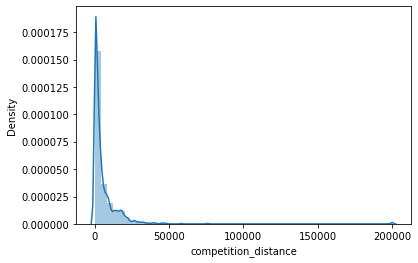

In [44]:
# A função distplot do seaborn exibe a distribuição dos dados.
sns.distplot(df1['competition_distance'])

In [45]:
# kurtosis: é uma das duas medidas que quantificam a forma de uma distribuição.
# kurtosis determina o volume de outliers, descrevendo o pico da distribuição.

# Se a distribuição for alta e fina, é chamada de distribuição leptocúrtica (kurtosis > 3). Os valores em uma distribuição
# leptocúrtica estão próximos da média ou nos extremos.
# Uma distribuição plana onde os valores são moderadamente espalhados (isto é, ao contrário da leptocúrtica) é chamada de 
# distribuição platicúrtica (kurtosis <3).
# Uma distribuição cuja forma está entre uma distribuição leptocúrtica e uma distribuição platicúrtica é chamada de
# distribuição mesocúrtica (kurtosis = 3). Uma distribuição mesocúrtica parece mais próxima de uma distribuição normal.

# É a nitidez do pico de uma curva de distribuição de frequência. É a medida dos outliers presentes na distribuição.
# Uma alta kurtosis em um conjunto de dados é um indicador de que os dados possuem muitos outliers.
# Uma baixa kurtosis em um conjunto de dados é um indicador de que os dados possuem poucos outliers.

C:\Users\adriano\anaconda3\envs\DataScienceEmProducao\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='customers', ylabel='Density'>

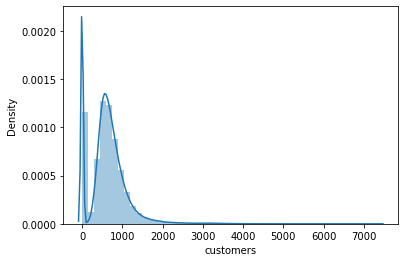

In [46]:
sns.distplot(df1['customers'])

C:\Users\adriano\anaconda3\envs\DataScienceEmProducao\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='sales', ylabel='Density'>

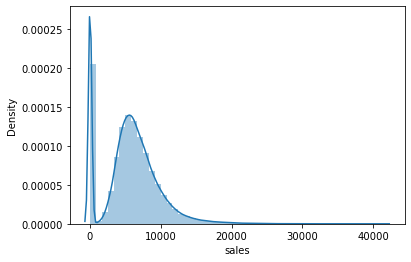

In [47]:
sns.distplot(df1['sales'])

### 1.7.2 Categorical Attributes

<AxesSubplot:xlabel='state_holiday', ylabel='sales'>

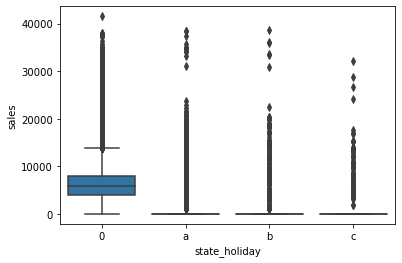

In [48]:
# Iremos utilizar boxplot para exibir a distribuiçãdo dos dados categóricos.
# O exemplo abaixo exibe a distribuição das vendas de acordo com os feriados.
sns.boxplot(x='state_holiday', y='sales', data=df1)

<AxesSubplot:xlabel='assortment', ylabel='sales'>

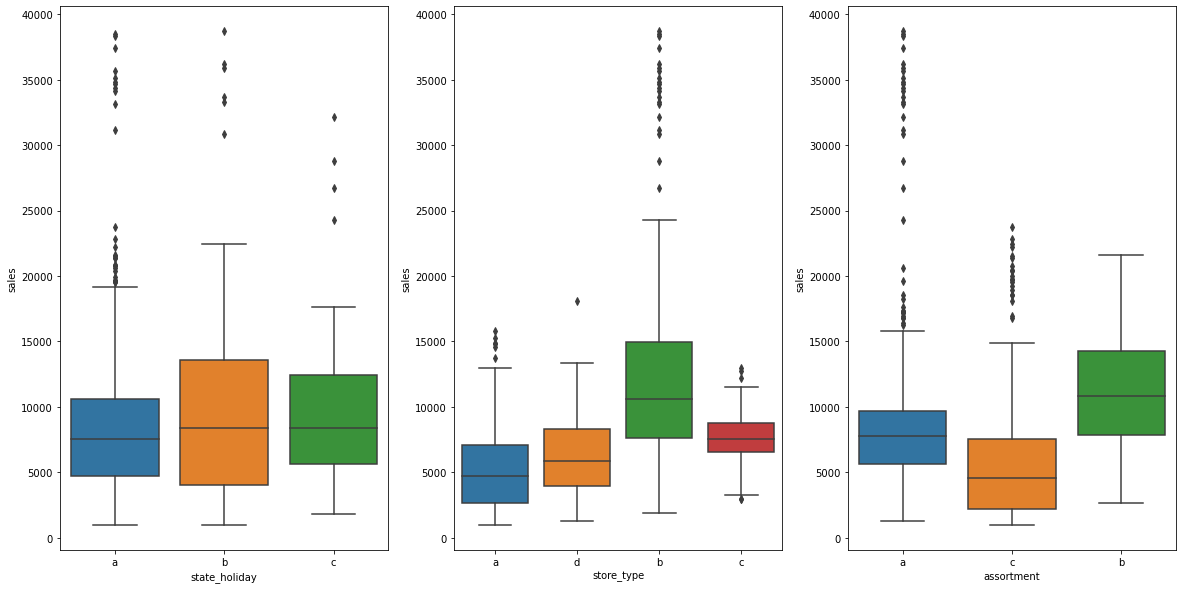

In [49]:
# O exemplo acima exibe uma distribuição muito dispersa dos dados, pois a dimensão das variáveis está muito diferente.
# Isto é muito provavel de ocorrer, pois temos dias que são feriados, onde a loja está fechada e consequentemente a quantidade
# de vendas é zero.
# Neste caso, a coluna 0 que representa dias sem feriados possui um volume de vendas bem maior que as outras três colunas
# a, b e c que são feriados: a = public holiday, b = Easter holiday, c = Christmas.
# Desta maneira, iremos criar dois boxplots separados, um para os dias normais e outro para os feriados.
# O exemplo abaixo considera os dias que são feriados, onde a loja estava aberta, isto é, com vendas diferentes de zero.
aux1 = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0)]

plt.figure(figsize=(20,10))

plt.subplot (1,3,1)  # Uma linha, três colunas e primeira posição.
sns.boxplot(x='state_holiday', y='sales', data=aux1)

plt.subplot (1,3,2)  # Uma linha, três colunas e segunda posição.
sns.boxplot(x='store_type', y='sales', data=aux1)

plt.subplot (1,3,3)  # Uma linha, três colunas e terceira posição.
sns.boxplot(x='assortment', y='sales', data=aux1)

<AxesSubplot:xlabel='assortment', ylabel='sales'>

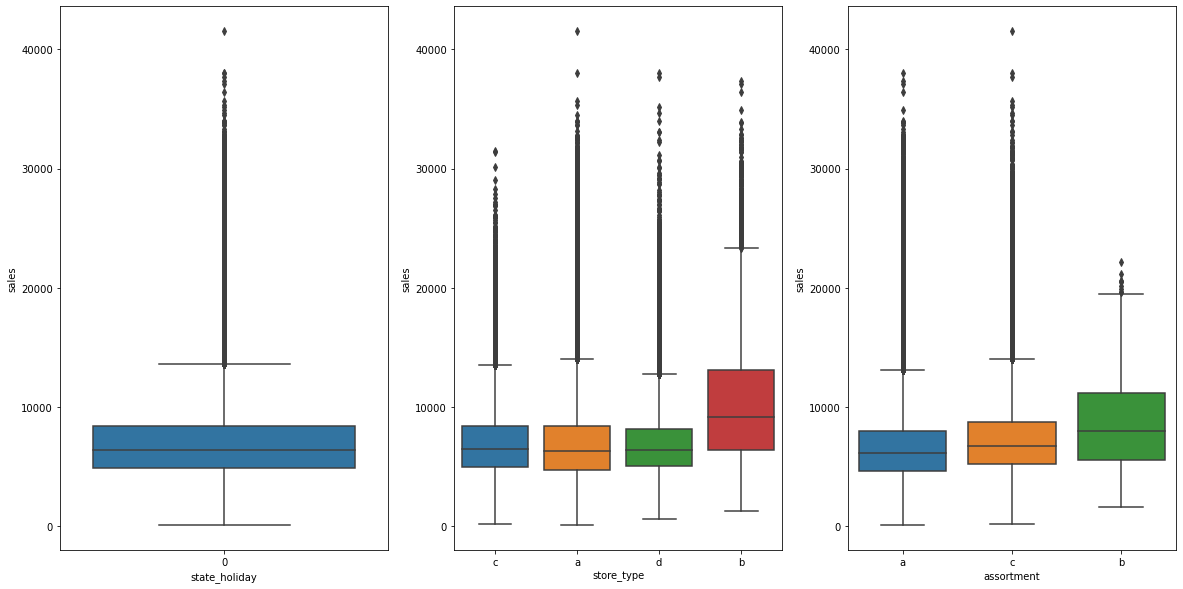

In [50]:
# O exemplo acima exibe uma distribuição muito dispersa dos dados, pois a dimensão das variáveis está muito diferente.
# Isto é muito provavel de ocorrer, pois temos dias que são feriados, onde a loja está fechada e consequentemente a quantidade
# de vendas é zero.
# Neste caso, a coluna 0 que representa dias sem feriados possui um volume de vendas bem maior que as outras três colunas
# a, b e c que são feriados: a = public holiday, b = Easter holiday, c = Christmas.
# Desta maneira, iremos criar dois boxplots separados, um para os dias normais e outro para os feriados.
# O exemplo abaixo considera os dias que não são feriados, onde a loja estava aberta, isto é, com vendas diferentes de zero.
aux2 = df1[(df1['state_holiday'] == '0') & (df1['sales'] > 0)]

plt.figure(figsize=(20,10))

plt.subplot (1,3,1)  # Uma linha, três colunas e primeira posição.
sns.boxplot(x='state_holiday', y='sales', data=aux2)

plt.subplot (1,3,2)  # Uma linha, três colunas e segunda posição.
sns.boxplot(x='store_type', y='sales', data=aux2)

plt.subplot (1,3,3)  # Uma linha, três colunas e terceira posição.
sns.boxplot(x='assortment', y='sales', data=aux2)

In [51]:
# A linha do meio representa a mediana (quartil 50).
# A linha inferior da caixa é o auartil 25.
# A linha superior da caixa é o quartil 75.
# A barra supeior é o valor máximo.
# A barra inferior é o valor mínimo.
# Os pontos acima e abaixo das barras são os outliers. Os dados são considerados outliers quando possuem três vezes o valor do
# desvio padrão.

# 2.0. PASSO 02 - FEATURE ENGINEERING

In [52]:
df2 = df1.copy()

## 2.1. Mapa Mental de Hipóteses

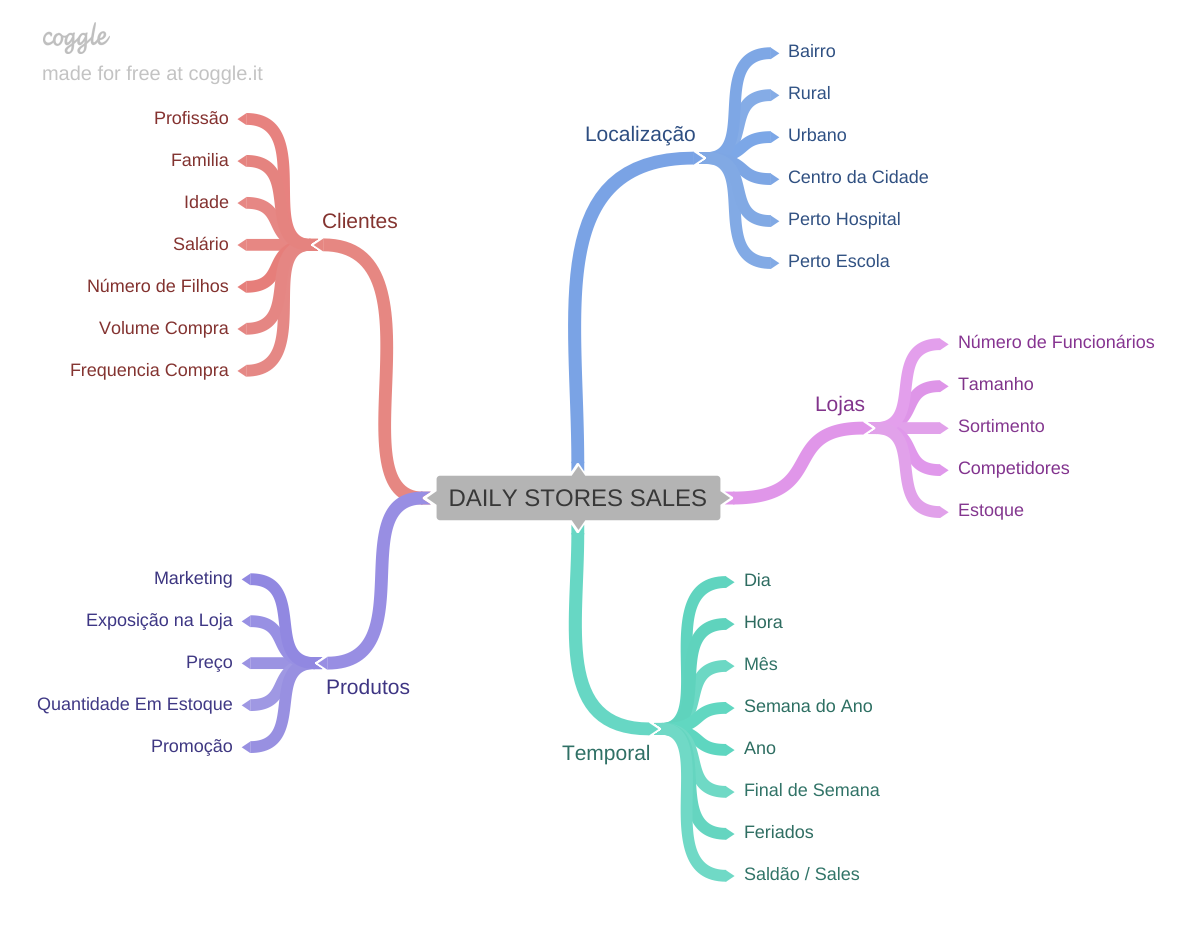

In [53]:
Image ('img/MindMapHipothesis.png')

## 2.2. Criação das Hipóteses

### 2.1.1. Hipóteses Lojas

**1.** Lojas com número maior de funcionários deveriam vender mais.

**2.** Lojas com maior capacidade de estoque deveriam vender mais.

**3.** Lojas com maior porte deveriam vender mais.

**4.** Lojas com maior sortimento deveriam vender mais.

**5.** Lojas com competidores mais próximos deveriam vender menos.

**6.** Lojas com competidores à mais tempo deveriam vender mais.

### 2.1.2. Hipóteses Produto

**1.**Lojas que investem mais em Marketing deveriam vender mais.

**2.**Lojas com maior exposição de produto deveriam vender mais.

**3.**Lojas com produtos com preço menor deveriam vender mais.

**4.**Lojas com promoções mais agressivas (descontos maiores), deveriam vender mais.

**5.**Lojas com promoções ativas por mais tempo deveriam vender mais.

**6.**Lojas com mais dias de promoção deveriam vender mais.

**7.**Lojas com mais promoções consecutivas deveriam vender mais.

### 2.1.3. Hipóteses Tempo

**1.**Lojas abertas durante o feriado de Natal deveriam vender mais.

**2.**Lojas deveriam vender mais ao longo dos anos.

**3.**Lojas deveriam vender mais no segundo semestre do ano.

**4.**Lojas deveriam vender mais depois do dia 10 de cada mês.

**5.**Lojas deveriam vender menos aos finais de semana.

**6.**Lojas deveriam vender menos durante os feriados escolares.

## 2.3. Lista Final de Hipóteses

**1.**Lojas com maior sortimento deveriam vender mais.

**2.**Lojas com competidores mais próximos deveriam vender menos.

**3.**Lojas com competidores à mais tempo deveriam vender mais.

**4.**Lojas com promoções ativas por mais tempo deveriam vender mais.

**5.**Lojas com mais dias de promoção deveriam vender mais.

**6.**Lojas com mais promoções consecutivas deveriam vender mais.

**7.**Lojas abertas durante o feriado de Natal deveriam vender mais.

**8.**Lojas deveriam vender mais ao longo dos anos.

**9.**Lojas deveriam vender mais no segundo semestre do ano.

**10.**Lojas deveriam vender mais depois do dia 10 de cada mês.

**11.**Lojas deveriam vender menos aos finais de semana.

**12.**Lojas deveriam vender menos durante os feriados escolares.

## 2.4. Feature Engineering

In [54]:
# year
# Cria uma coluna "year" contendo o ano da coluna "date".
df2['year'] = df2['date'].dt.year

# month
# Cria uma coluna "month" contendo o mês da coluna "date".
df2['month'] = df2['date'].dt.month

# day
# Cria uma coluna "day" contendo o dia da coluna "date".
df2['day'] = df2['date'].dt.day

# week of year
# Cria uma coluna "week_of_year" contendo a semana do ano da coluna "date".
df2['week_of_year'] = df2['date'].dt.isocalendar().week

# year week
# Cria uma coluna "year_week" contendo o número do ano e o número da semana da coluna "date".
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

# competition since
# Cria uma coluna competition_since contendo a informação do ano da coluna competition_open_since_year, o valor do mês da
# coluna competition_open_since_month e o valor do dia igual à 1.
df2['competition_since'] = df2.apply(lambda x: datetime.datetime( year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1), axis=1)
# Cria uma coluna competition_time_month contendo o valor em meses de quanto tempo existe um competidor. Este valor é a 
# diferença da data da coluna "date" com o valor da data da coluna "competition_since", dividindo o resultado por 30 para
# obtermos a quantidade de meses.
# Utiliza-se a função lambda x: x.days para extrair a quantidade de dias da diferença das colunas "date" e "competition_since".
# Neste caso, como dividimos previamente o resultado por 30, a quantidade de dias será a quantidade de dias dividido por 30.
# O objetivo é obtermos a quantidade de meses e não a quantidade de dias, por isso o valor dos dias foi dividido por 30.
# Por último, converte o valor para um número inteiro com a função astype(int64).
df2['competition_time_month'] = ((df2['date'] - df2['competition_since'])/30).apply(lambda x: x.days).astype(int64)

# promo since
# Cria uma coluna chamada "promo_since" contendo o valor da coluna "promo2_since_year" e "promo2_since_week", onde ambos os 
# valores serão convertidos para string com a função astype(str) e entre estes valores serão acrescentado o caractere "-".
df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
# Converte o valor da coluna 'promo_since' para o formato data utilizando a função strptime.
df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w') - datetime.timedelta(days=7))
# O padrão -1 e -%w diz ao analisador para escolher a segunda-feira daquela semana.
# Cria uma coluna chamada "promo_time_week" contendo o valor em semanas de quanto tempo existe uma promoção. Este valor é a 
# diferença da data da coluna "date" com o valor da data da coluna "promo_since", dividindo o resultado por 7 para
# obtermos a quantidade de semanas.
# Utiliza-se a função lambda x: x.days para extrair a quantidade de dias da diferença das colunas "date" e "promo_since".
# Neste caso, como dividimos previamente o resultado por 7, a quantidade de dias será a quantidade de dias dividido por 7.
# O objetivo é obtermos a quantidade de semanas e não a quantidade de dias, por isso o valor dos dias foi dividido por 7.
# Por último, converte o valor para um número inteiro com a função astype(int64).
df2['promo_time_week'] = ((df2['date'] - df2['promo_since'])/7).apply(lambda x: x.days).astype(int64)


# assortiment
# Altera os valores da coluna "assortiment" de a para "basic", b para "extra" e c para "extended".
df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')

# state holiday
# Altera os valores da coluna "state_holiday" de a para "public_holiday", b para "easter_holiday" e c para 'christimas'
df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day')

In [55]:
df2.sample(5).T

,816008,663194,624805,195972,498196
store,614,555,76,848,577
day_of_week,7,4,3,5,5
date,2013-06-30 00:00:00,2013-11-14 00:00:00,2013-12-18 00:00:00,2015-02-06 00:00:00,2014-04-11 00:00:00
sales,0,3908,15021,7951,4857
customers,0,405,1235,808,647
open,0,1,1,1,1
promo,0,0,1,1,0
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,0,0,0,0,0
store_type,a,d,d,a,a


In [56]:
df2.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
promo_interval                          object
month_map                               object
is_promo                                 int64
year                                     int64
month        

In [57]:
df2[df2['state_holiday'] == 'public_holiday'][['state_holiday']]

,state_holiday
63555,public_holiday
63557,public_holiday
63559,public_holiday
63560,public_holiday
63563,public_holiday
...,...
1017204,public_holiday
1017205,public_holiday
1017206,public_holiday
1017207,public_holiday


# 3.0. PASSO 03 - FILTRAGEM DE VARIÁVEIS

In [58]:
df3 = df2.copy()

In [59]:
df3.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,...,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,555,1,1,regular_day,1,c,...,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,625,1,1,regular_day,1,a,...,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,821,1,1,regular_day,1,a,...,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1498,1,1,regular_day,1,c,...,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,559,1,1,regular_day,1,a,...,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0


## 3.1. Filtragem das Linhas

In [60]:
# O primeiro passo é a filtragem das linhas para diminuir o volume do dataset, aumentando o desempenho.

In [61]:
# Coluna open: 1 significa que a loja está aberta e 0 significa que a loja está fechada. Se a loja está fechada não ocorre
# vendas. Portanto, iremos descartas as linhas que possuem na coluna open o valor igual à 0.

In [62]:
# Coluna sales: quando a loja está fechada o valor da coluna sales é igual à zero. Portanto, iremos descartas as linhas que
# possuem na coluna sales o valor igual à 0.

In [63]:
# Mantém apenas as linhas que possuem na coluna open o valor diferente de zero e na coluna sales o valor maior que zero.
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

## 3.2. Seleção das Colunas e das Linha

In [64]:
# Coluna customers: informa quantas pessoas havia na loja no dia que foram feitas as vendas. Se utilizarmos esta coluna 
# iremos necessitar dela no momento da predição e baseado no contexto deste projeto, não temos a informação de quantos 
# clientes/customers teremos daqui à seis semanas. Teríamos que fazer um projeto separado para prever quantos clientes estariam
# nas lojas daqui à seis semanas, pegar o resultado e utilizá-lo como input neste projeto. Porém, não iremos fazer isto.
# Portanto, a coluna customers é uma variável que não temos disponível no momento da predição, significando que é uma
# restrição de negócio.

In [65]:
# Coluna open: uma vez que selecionamos no passo anterior apenas as linhas que possuem na coluna open o valor diferente de
# zero, isto é, o valor igual à 1, não teremos variabilidade nesta coluna, pois todos os valores serão igual à um. Portanto,
# podemos excluir a coluna open.

In [66]:
# Coluna que utilizamos para derivar variáveis ou como colunas auxiliares:
# Coluna promo_interval foi utilizada para derivar a coluna is_promo. Portanto, a coluna promo_interval será excluída.
# Coluna month_map foi uma coluna auxiliar utilizada que será excluída.

In [67]:
# Cria uma lista chamada cols_drop selecionando as colunas que será apagadas do dataset.
cols_drop = ['customers', 'open',  'promo_interval', 'month_map']
df3 = df3.drop (cols_drop, axis = 1)

In [68]:
df3.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'year', 'month',
       'day', 'week_of_year', 'year_week', 'competition_since',
       'competition_time_month', 'promo_since', 'promo_time_week'],
      dtype='object')

# 4.0. PASSO 04 - ANÁLISE EXPLORATÓRIA DE DADOS

In [69]:
df4 = df3.copy()

## 4.1. Análise Univariada

### 4.1.1. Response Variable

C:\Users\adriano\anaconda3\envs\DataScienceEmProducao\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='sales', ylabel='Density'>

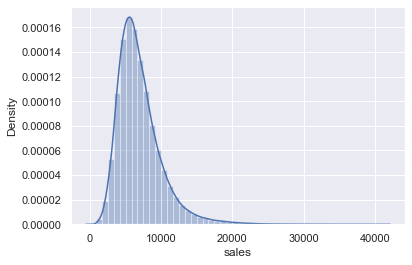

In [70]:
# Exibe a distribuição da variável sales.
sns.set_theme(style="darkgrid")
sns.distplot(df4['sales'])

<AxesSubplot:xlabel='sales', ylabel='Count'>

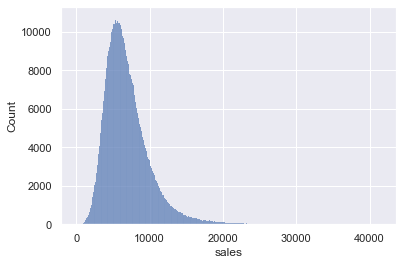

In [71]:
# No gráfico acima, os valores da coluna Y são pequenos pois informam a densidade de distribuição.
# Para exibirmos as quantidades utilizamos o histograma, conforme o exemplo abaixo:
sns.set_theme(style="darkgrid")
sns.histplot(df4['sales'])

C:\Users\adriano\anaconda3\envs\DataScienceEmProducao\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='sales'>

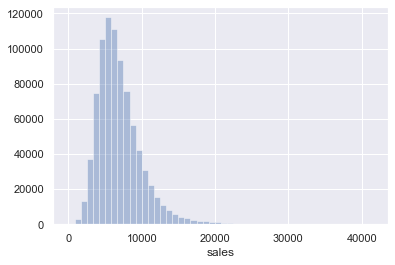

In [72]:
# No gráfico que exibe a distribuição da variável sales, os valores da coluna Y são pequenos pois informam a densidade de 
# distribuição.
# Para exibirmos as quantidades utilizamos o atributeo kde=False, conforme o exemplo abaixo:
sns.set_theme(style="darkgrid")
sns.distplot(df4['sales'], kde=False)

<AxesSubplot:xlabel='sales', ylabel='Density'>

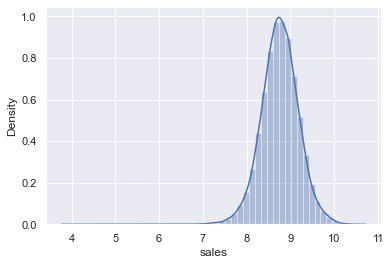

In [73]:
# O gráfico acima mostra uma distribuição com um formato de um sino e com uma skew positiva (cauda da distribuição para
# o lado direito).
# Esta distribuição está bem próxima de uma distribuição normal.
# Nos importamos com estas características da distribuição, pois a maioria dos algoritmos de Machine Learning são criados
# baseados em algumas premissas, baseados em alguns comportamentos do ambiente. Uma destas condições é que os dados sejam 
# independentes e que sigam uma distribuição normal.
# Então quanto mais normal for a distribuição da variável resposta, melhor o seu algoritmo vai performar.
# Existem várias técnicas de transformações para transformar a distribuição da variável resposta mais próxima de uma
# distribuição normal.
# Uma das transformações mais utilizadas é a log. No exemplo abaixo, estamos multiplicando todos os valores de venda pelo log,
# e vai fazer uma modificação na variável resposta.
# A distribuição fica mais próxima de uma distribuição normal.
sns.set_theme(style="darkgrid")
sns.distplot(np.log1p (df4['sales']))

### 4.1.2. Numerical Variable

In [74]:
# Exibe as variáveis numéricas:
num_attributes.head()

,store,day_of_week,sales,customers,open,promo,school_holiday,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo
0,1,5,5263,555,1,1,1,1270.0,9,2008,0,31,2015,0
1,2,5,6064,625,1,1,1,570.0,11,2007,1,13,2010,1
2,3,5,8314,821,1,1,1,14130.0,12,2006,1,14,2011,1
3,4,5,13995,1498,1,1,1,620.0,9,2009,0,31,2015,0
4,5,5,4822,559,1,1,1,29910.0,4,2015,0,31,2015,0


<Figure size 1440x1440 with 0 Axes>

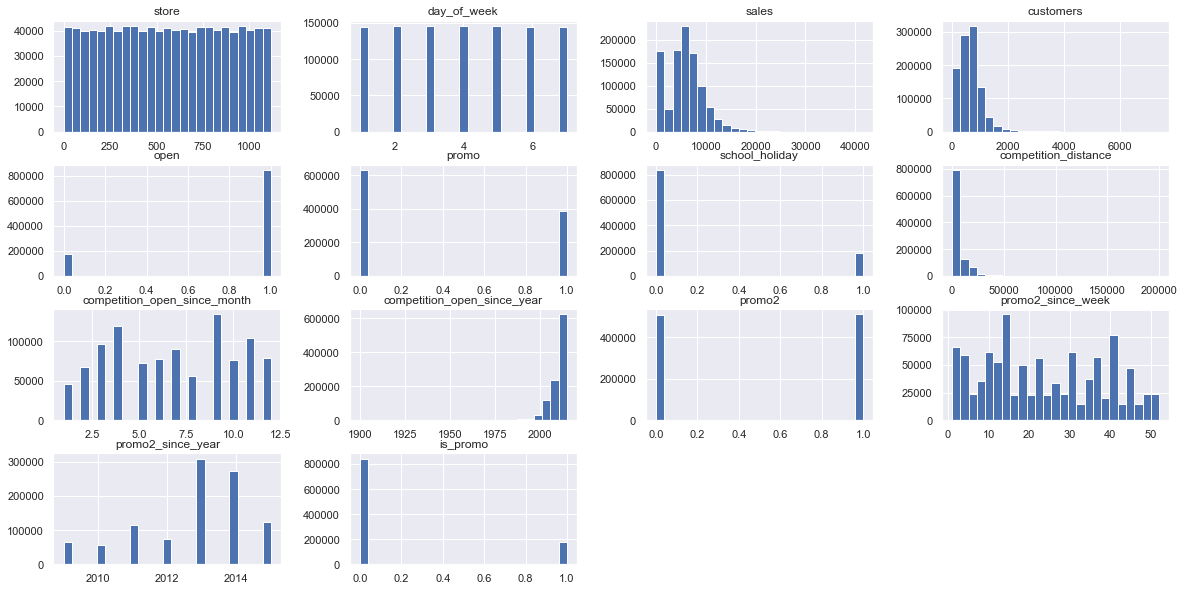

In [75]:
# Exibe os gráficos de histograma para as variáveis numéricas.
plt.figure(figsize=(20,20))
sns.set_theme(style="darkgrid")
num_attributes.hist(bins=25,figsize=(20,10)); # O ponto e vírgulo no final inibe as mensagens de "AxesSubplot".

In [76]:
# FAZER COMO EXERCÍCIO UMA LISTA, EXPLICANDO O COMPORTAMENTO DE CADA VARIÁVEL.
# EXEMPLO: CUSTOMERS TENHO MAIS VENDA QUANDO ESTÁ PERTO DE 30.000. 

### 4.1.3. Categorical Variable

In [77]:
# Exibe as variáveis categóricas.
cat_attributes.head()

,state_holiday,store_type,assortment,promo_interval,month_map
0,0,c,a,0,Jul
1,0,a,a,"Jan,Apr,Jul,Oct",Jul
2,0,a,a,"Jan,Apr,Jul,Oct",Jul
3,0,c,c,0,Jul
4,0,a,a,0,Jul


In [78]:
# Exibe os valores da coluna state_holiday.
df4['state_holiday'].unique()

array(['regular_day', 'public_holiday', 'easter_holiday', 'christmas'],
      dtype=object)

In [79]:
# store type
# Exibe os valores da coluna store_type.
df4['store_type'].unique()

array(['c', 'a', 'd', 'b'], dtype=object)

In [80]:
# assortment
# Exibe os valores da coluna assortment.
df4['assortment'].unique()

array(['basic', 'extended', 'extra'], dtype=object)

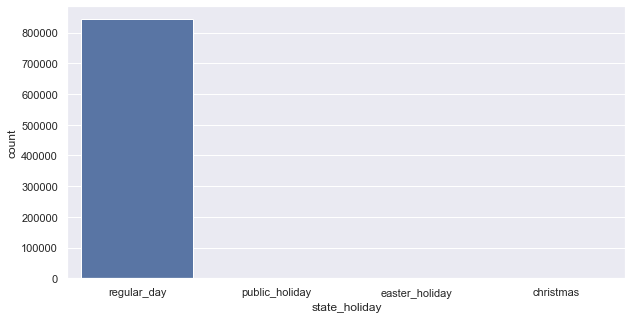

In [81]:
# state holiday
# Exibe a quantidade de linhas para cada valor da coluna state_holiday.
sns.set(rc={"figure.figsize":(10, 5)}) #width=10, height=5
sns.set_theme(style="darkgrid")
sns.countplot(x=df4['state_holiday']); #o ponto e vírgula inibe a mensagem <AxesSubplot:xlabel='state_holiday', ylabel='count'>

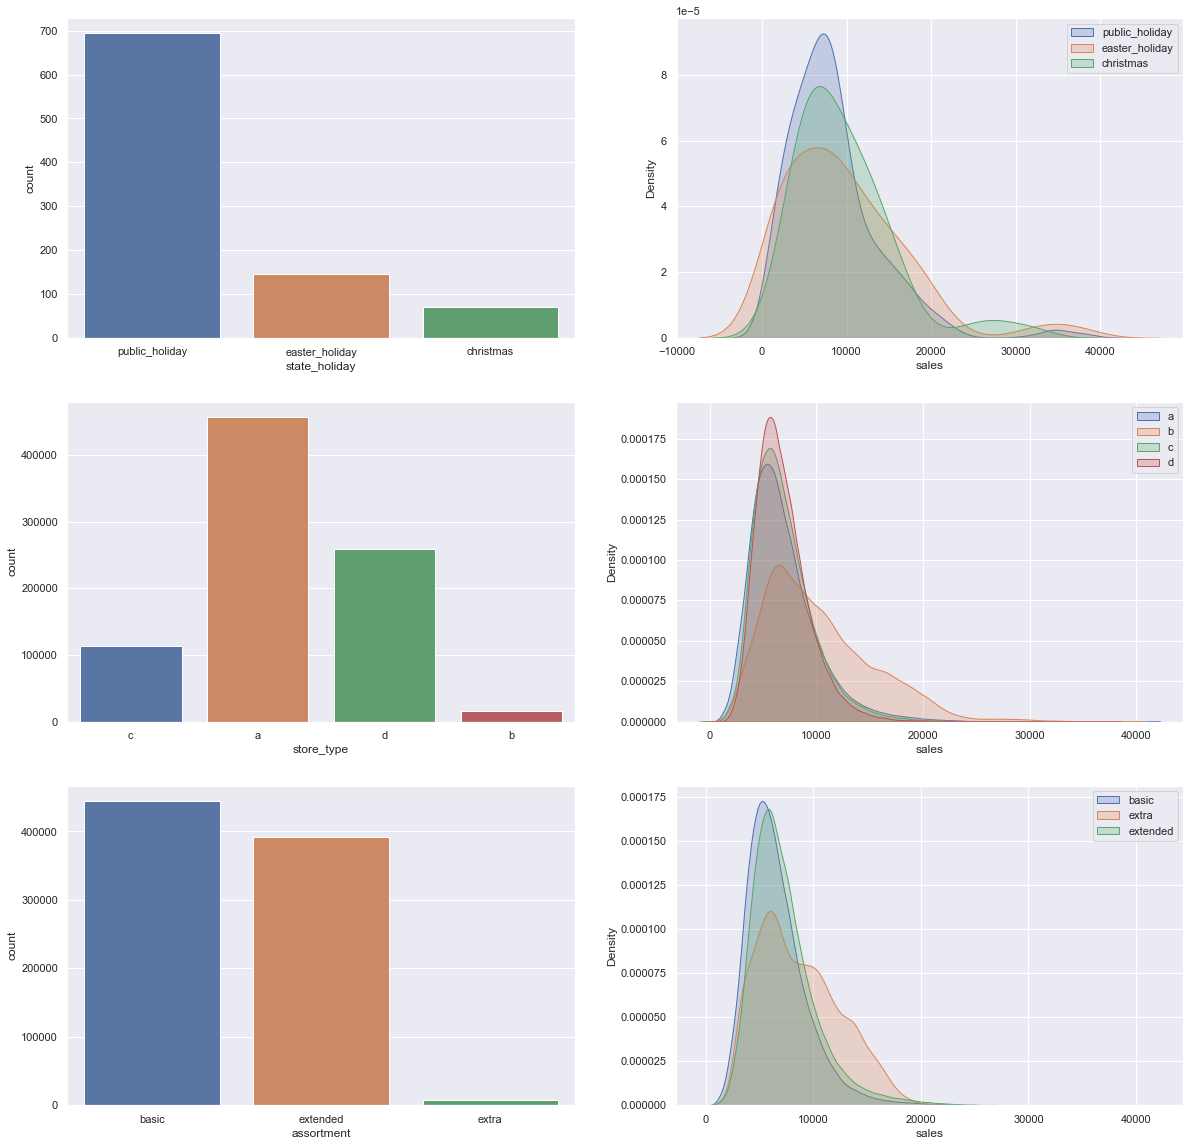

In [82]:
# Exibe os gráficos de ocorrencia e densidade de vendas para os atributos state_holiday, store_type e assortment.
plt.figure(figsize=(20,20))
sns.set_theme(style="darkgrid")

# O comando abaixo inibe a mensagem de warning: " FutureWarning: Pass the following variable as a keyword arg: x. From 
# version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword
# will result in an error or misinterpretation. warnings.warn("
warnings.filterwarnings('ignore')

# state_holiday
plt.subplot(3,2,1)  # Três linhas, duas colunas, primeira posição.
# Exibe a quantidade de ocorrencias para cada tipo de feriado (state_holiday), excluíndo os dias normais.
a = df4[df4['state_holiday'] != 'regular_day']
sns.countplot(a['state_holiday'])

plt.subplot(3,2,2)
# Exibe o gráfico de densidade de vendas (kde: kernel density estimation) para o atributo state_holiday, excluíndo os dias normais:
sns.kdeplot(df4[df4['state_holiday'] == 'public_holiday']['sales'], label='public_holiday', shade=True)
sns.kdeplot(df4[df4['state_holiday'] == 'easter_holiday']['sales'], label='easter_holiday', shade=True)
sns.kdeplot(df4[df4['state_holiday'] == 'christmas']['sales'], label='christmas', shade=True)
plt.legend()  # Exibe as legendas.

# store_type
plt.subplot(3,2,3)
# Exibe a quantidade de ocorrências para cada tipo de loja (store_type).
sns.countplot(df4['store_type'])

plt.subplot(3,2,4)
# Exibe o gráfico de densidade de vendas (kde: kernel density estimation) para o atributo store_type':
sns.kdeplot(df4[df4['store_type'] == 'a']['sales'], label='a', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'b']['sales'], label='b', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'c']['sales'], label='c', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'd']['sales'], label='d', shade=True)
plt.legend()  # Exibe as legendas.

# assortment
plt.subplot(3,2,5)
# Exibe a quantidade de ocorrências para cada tipo de sortimento (assortment).
sns.countplot(df4['assortment'])

plt.subplot(3,2,6)
# Exibe o gráfico de densidade de vendas (kde: kernel density estimation) para o atributo store_type':
sns.kdeplot(df4[df4['assortment'] == 'basic']['sales'], label='basic', shade=True)
sns.kdeplot(df4[df4['assortment'] == 'extra']['sales'], label='extra', shade=True)
sns.kdeplot(df4[df4['assortment'] == 'extended']['sales'], label='extended', shade=True)

plt.legend()  # Exibe as legendas.

In [83]:
# O gráfico da variavel state_holiday, exibe uma menor distribuição de vendas para os feriados public_holiday, por isto, exibe um pico maior.
# Em compensação o feriado easter_holiday possui uma distribuição de vendas maior, isto é, existem mais lojas que vendem menos e 
# mais lojas que vendem mais quando comparado com os feriados public_holiday.
# O gráfico da variável assortment(sortimento) mostra que o tipo de assortment extra possui uma distribuição de vendas maior do que os outros tipos
# de assortments. Neste caso, o tipo de sortimento extra possui volumes de vendas maiores do que os outros dois tipos de sortimentos.

## 4.2. Análise Bivariada

### **H1.** Lojas com maior sortimento deveriam vender mais.
**FALSA** Lojas com MAIOR SORTIMENTO (EXTENDED) vendem MENOS QUE O ASSORTMENT EXTRA.

In [86]:
# O comando abaixo armazena na variável aux1 a média das vendas por tipo de assortment.
aux1 = df4[['assortment', 'sales']].groupby('assortment').mean().reset_index()

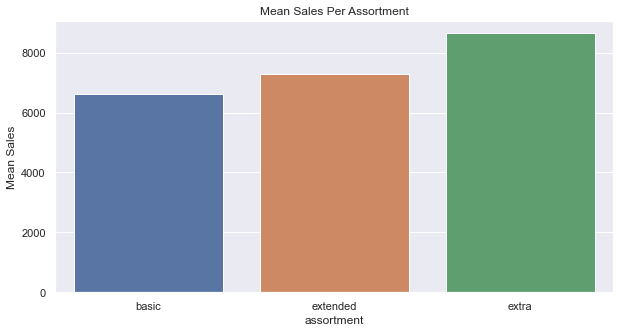

In [87]:
# O comando abaixo exibe o gráfico de barras das médias de vendas para cada tipo de assortment.
sns.barplot(x='assortment', y='sales', data=aux1).set_title('Mean Sales Per Assortment');  # O ponto e virgula inibe a mensagem: <AxesSubplot:xlabel='assortment', ylabel='sales'>
plt.ylabel('Mean Sales');  # Configura o texto da coluna Y.

In [88]:
# O gráfico acima mostra que as lojas com maior sortimento (assortment=extended) vendem menos que o assortment extra, portanto a hipótese é falsa.

In [96]:
# Uma pergunta que surge é: Será que ocorreu uma mudança de comportamento ao longo do tempo. Por exemplo, imagine que extra
# foi um tipo de assortment que vendeu muito no passado e de uns tempos para cá começou a vender menos.
# Para validar esta hipótese, necessitamos da média das vendas por assortment e por dia, para verificar se ocorreu alguma 
# mudança ao longo do tempo.
# O comando abaixo armazena na variável aux5 a media das vendas por tipo de assortment e por semana do ano.
aux5 = df4[['year_week', 'assortment', 'sales']].groupby(['year_week', 'assortment']).mean().reset_index()

In [97]:
aux5.head(5)

,year_week,assortment,sales
0,2013-00,basic,5642.277194
1,2013-00,extended,6094.001471
2,2013-00,extra,5282.431373
3,2013-01,basic,7307.459961
4,2013-01,extended,7553.623270


In [98]:
# Para exibir um gráfico com uma linha para cada tipo de assortment, tempos que transformar o tipos de assortment em colunas.
# O comando pivot abaixo armazena na variável aux6 um dataset com o indice year_week, as colunas são os tipos de assortment e
# os valores da coluna sales.
aux6 = aux5.pivot(index='year_week', columns='assortment', values='sales')
aux6.head(5)

assortment,basic,extended,extra
year_week,,,
2013-00,5642.277194,6094.001471,5282.431373
2013-01,7307.459961,7553.623270,6254.982143
2013-02,5049.444788,5283.317073,6286.783333
2013-03,6853.631919,6983.376397,6423.206349
2013-04,5611.939028,5944.287541,6483.232143


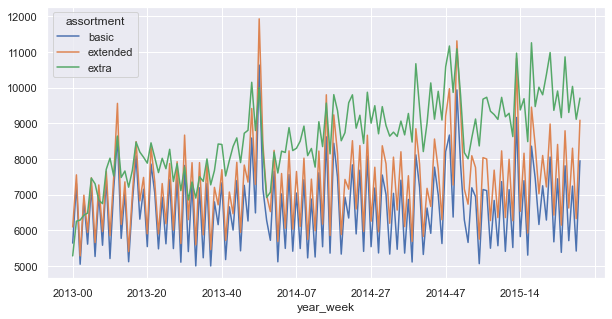

In [99]:
# O comando abaixo exibe um gráfico da média das vendas por semana do ano para cada tipo de assortment.
aux5.pivot(index='year_week', columns='assortment', values='sales').plot();

In [100]:
# No gráfico acima, podemos concluir que o tipo de assortment extra possui um valor médio de vendas
# aumentando ao longo do tempo, enquanto a média das vendas dos tipos de assortment basic e extended
# continua praticamente estável ao longo do tempo.

### **H2.** Lojas com competidores mais próximos deveriam vender menos.
**FALSA** Loja com COMPETIDORES MAIS PRÓXIMOS vendem na MÉDIA.

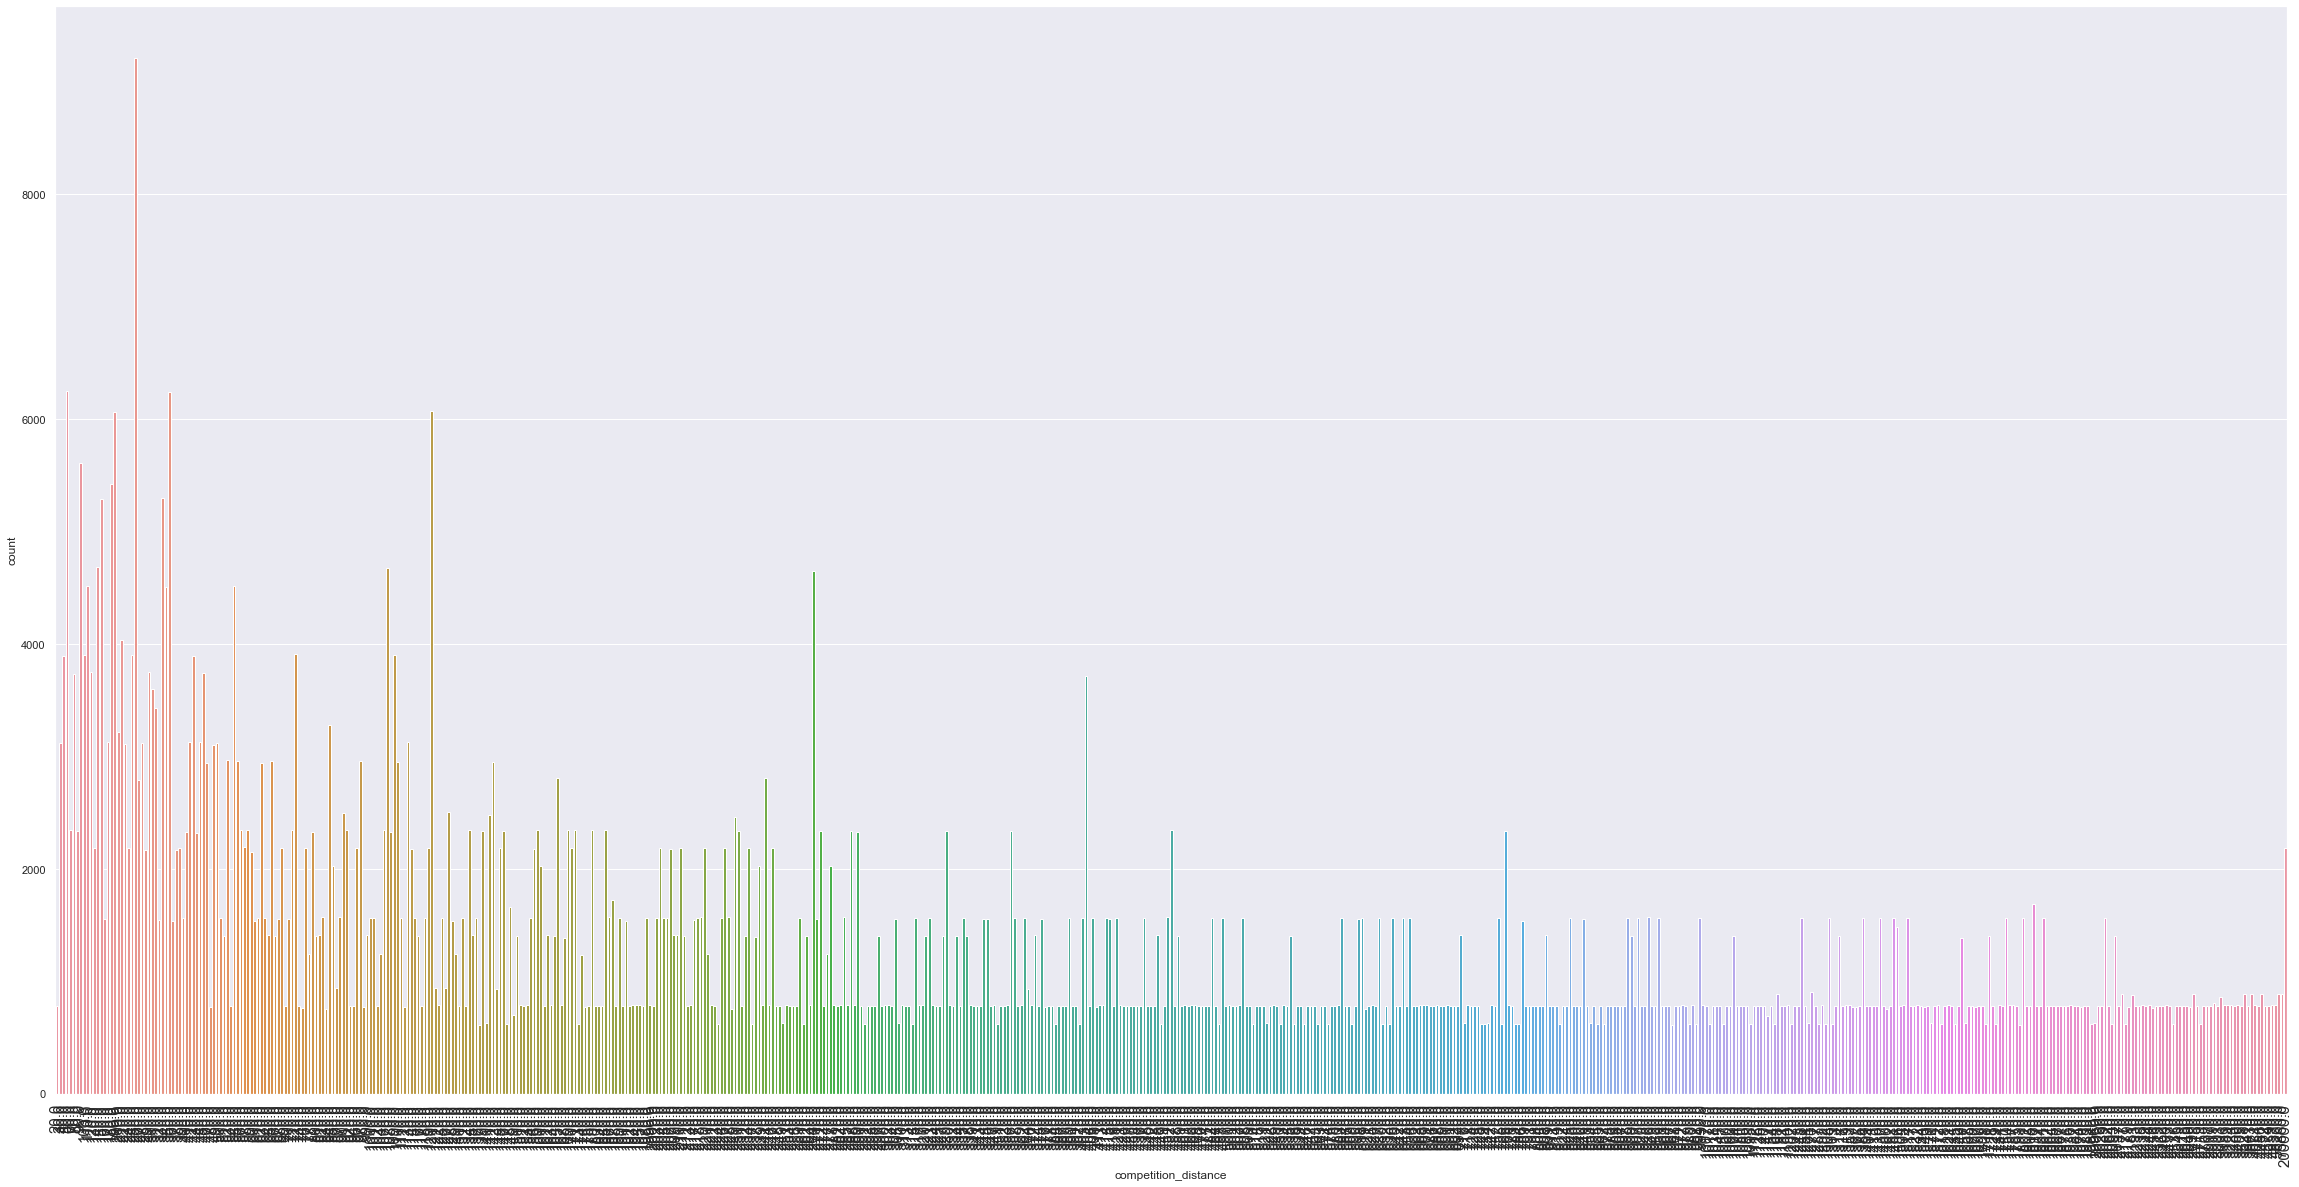

In [101]:
# Gráfico para exibir a quantidade de ocorrências para cada valor de competition_distance.
plt.figure(figsize=(40,20))  # Define o tamanho do gráfico.
sns.countplot(x=df4['competition_distance'])
plt.xticks(rotation=90, fontsize=15);  # Rotaciona o label da coluna x em 90 graus e especifica o tamanho da fonte do label.

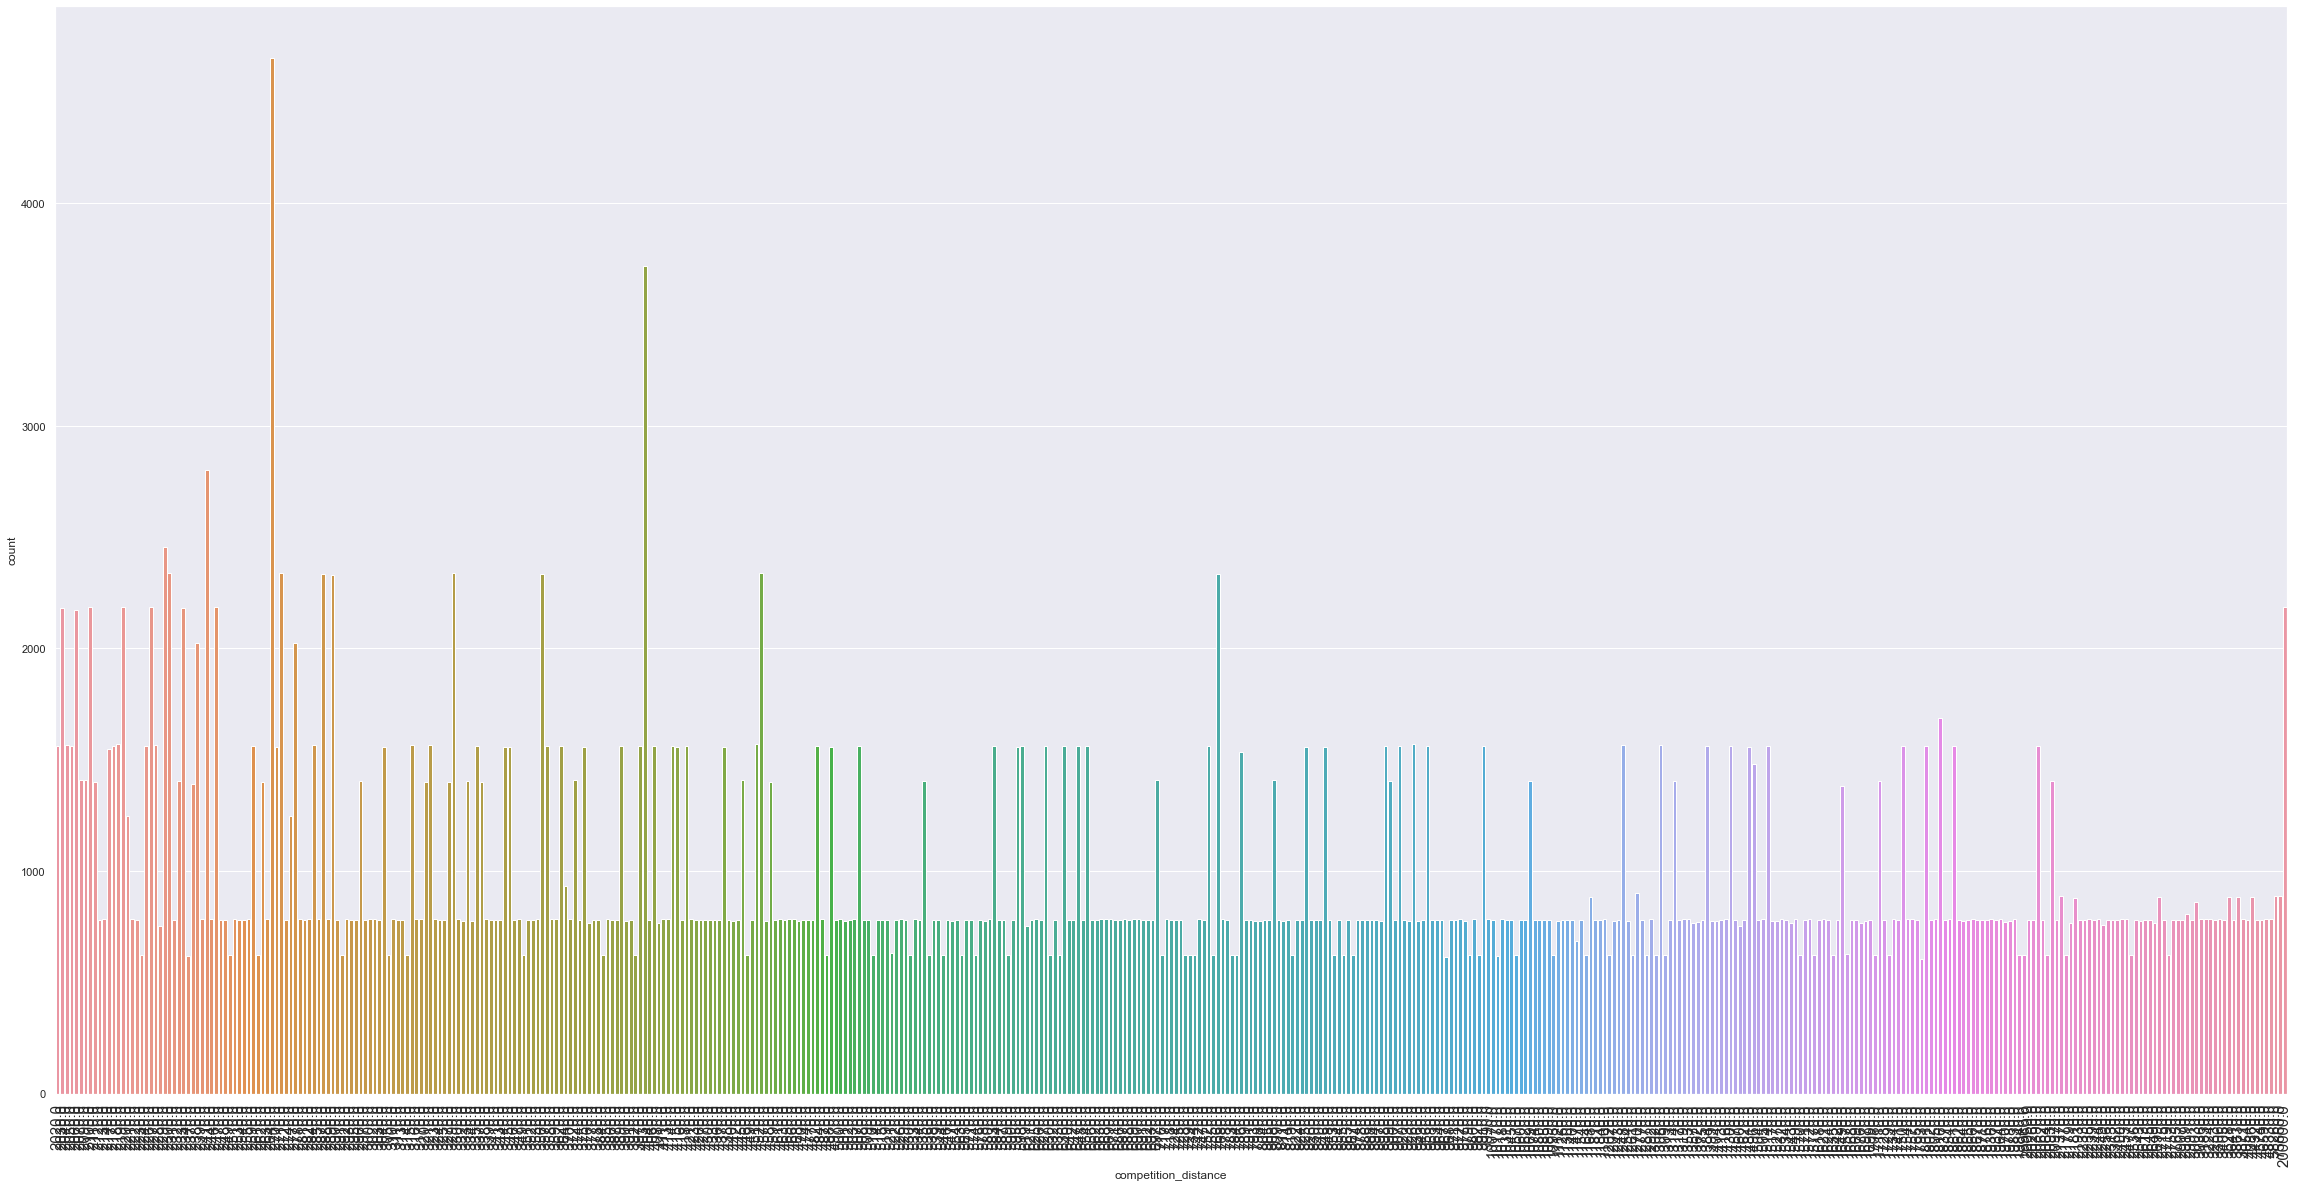

In [102]:
# Gráfico para exibir a quantidade de ocorrências valor de competition_distance > 2000.
plt.figure(figsize=(40,20))  # Define o tamanho do gráfico.
aux19 = df4[(df4['competition_distance'] > 2000 )]
sns.countplot(x=aux19['competition_distance'])
plt.xticks(rotation=90, fontsize=15);  # Rotaciona o label da coluna x em 90 graus e especifica o tamanho da fonte do label.

In [103]:
# No gráfico acima, verificamos que existe um certo padrão na quantidade de lojas por distância, onde um valor próximo de
# 800 lojas se repete ao longo das distâncias.

In [104]:
# O comando abaixo armazena na variável aux9 a média das vendas por tipo de competition_distance.
aux9 = df4[['competition_distance', 'sales']].groupby('competition_distance').mean().reset_index()

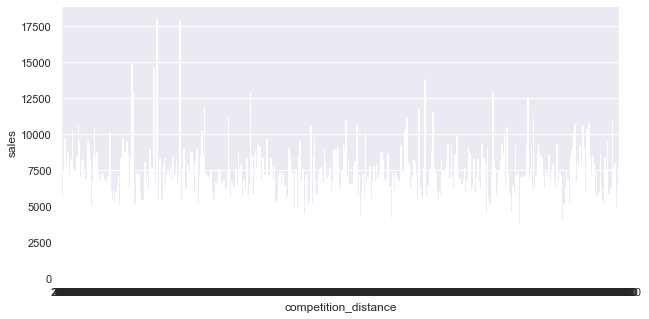

In [105]:
# Exibe a média das vendas por tipo de competition_distance.
sns.barplot(x='competition_distance', y='sales', data=aux9);  # O ponto e virgula inibe a mensagem: <AxesSubplot:xlabel='assortment', ylabel='sales'>

In [106]:
# O gráfico acima é muito granular e é difícil de enxergar alguma coisa. 
# Para visualizar melhor esta informação, podemos criar grupos de distâncias. Exemplo: de 10 em 10 , de 100 e 100, etc...
# Então agrupamos as vendas por grupo de competition_distance.

# O comando bins abaixo, cria uma lista com valores de 0 até 80000 que crescem de 1000 em 1000.
bins = list(np.arange(0, 80000, 1000))

# Temos que saber em qual grupo de 1000 em 1000 o valor da competition_distance fará parte.
# Para isto, utilizamos o método do pandas chamado cut que pega a variável competition_distance e o bins criado anteriormente
# e determina em qual grupo de bins o valor original de competition_distance pertence.
# É criada uma nova coluna chamada competition_distance_binned onde o valor será de acordo com o valor do grupo da coluna
# competition_distance.
aux9['competition_distance_binned'] = pd.cut(aux9['competition_distance'], bins=bins)

In [107]:
aux9.sample(5)

,competition_distance,sales,competition_distance_binned
547,15340.0,12616.487805,"(15000, 16000]"
441,8190.0,5383.604502,"(8000, 9000]"
153,1730.0,8274.982315,"(1000, 2000]"
347,5030.0,5204.651786,"(5000, 6000]"
298,3900.0,5156.078507,"(3000, 4000]"


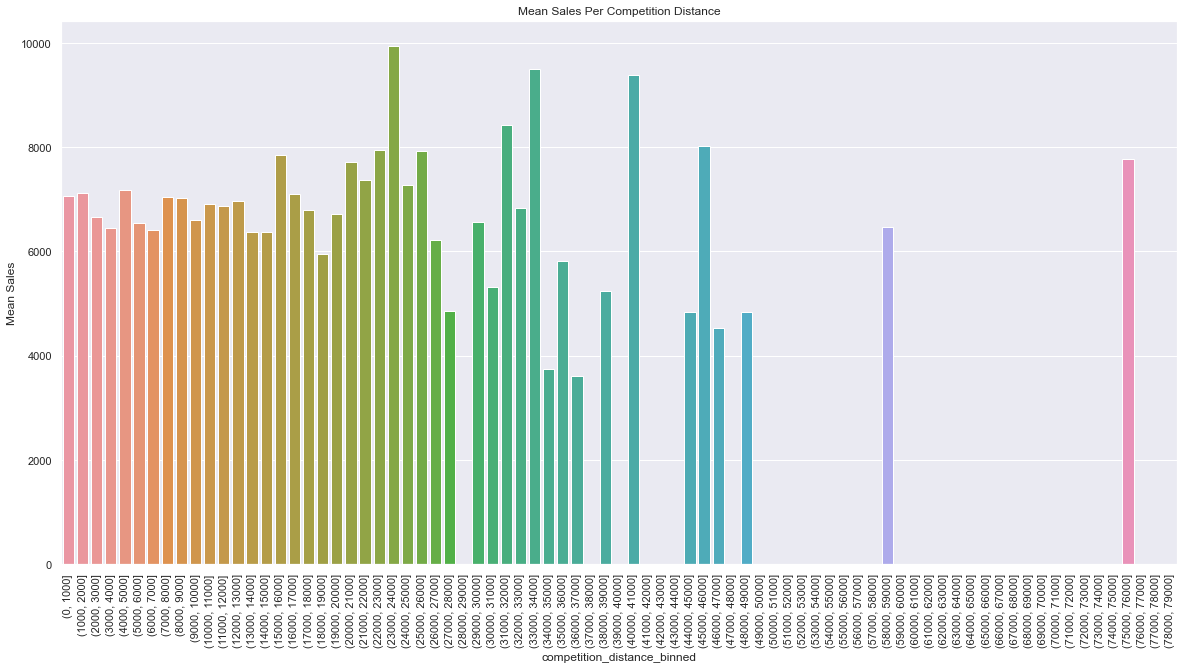

In [108]:
# O comando abaixo exibe um gráfico com a média de vendas por competition_distance_binned.
plt.figure(figsize=(20,10))
aux10 = aux9[['competition_distance_binned', 'sales']].groupby('competition_distance_binned').mean().reset_index()
sns.barplot(x='competition_distance_binned', y='sales', data=aux10).set_title('Mean Sales Per Competition Distance');
plt.xticks(rotation=90); # Rotaciona o label da coluna x em 90 graus.
plt.ylabel('Mean Sales');  # Configura o texto da coluna Y.

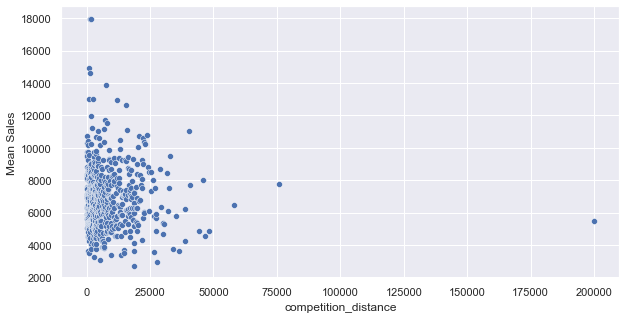

In [109]:
# Exemplo de gráfico utilizando scatter plot:
# O comando abaixo armazena na variável aux11 a média das vendas por tipo de competition_distance.
aux11 = df4[['competition_distance', 'sales']].groupby('competition_distance').mean().reset_index()

# Exibe um gráfico do tipo scatter plot:
sns.scatterplot(x='competition_distance', y='sales', data=aux11);
plt.ylabel('Mean Sales');  # Configura o texto da coluna Y.

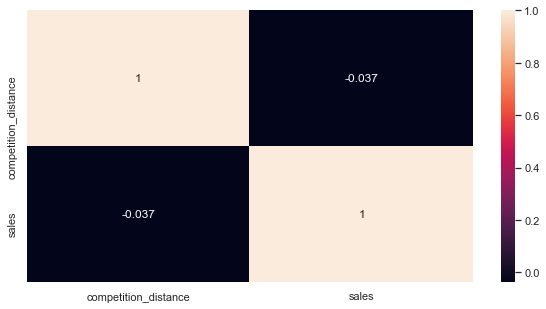

In [110]:
# O gráfico abaixo mede a força da correlação entre as variáveis competition_distance e sales.
sns.heatmap(aux11.corr(method='pearson'), annot=True);
# Os valores da correlação variam de 1 até -1.  Quanto mais próxima de zero, mais fraca é a 
# correlação. Quanto mais próximo de 1 ou -1, mais forte é a correlação.

### **H3.** Lojas com competidores à mais tempo deveriam vender mais.
**FALSO** Lojas com COMPETIDORES À MAIS TEMPO vendem na MÉDIA.

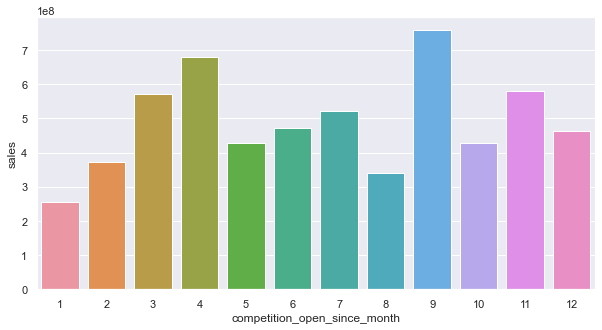

In [111]:
# O comando abaixo armazena na variável aux12 a soma das vendas para cada valor de competition_open_since_month.
aux12 = df4[['competition_open_since_month', 'sales']].groupby('competition_open_since_month').sum().reset_index()

# Exibe um gráfico de barras.
sns.barplot(x='competition_open_since_month', y='sales', data=aux12);

# O gráfico abaixo mostra na coluna x o mês que o competidor iniciou as suas vendas. E a coluna y mostra a soma
# das vendas.
# Este gráfico não é útil, pois estamos interessados em saber qual é a relação entre o tempo que o competidor está
# aberto com as vendas. Neste gráfico se por exemplo um competidor iniciou no mês 9 do ano passado, não temos
# esta informação.

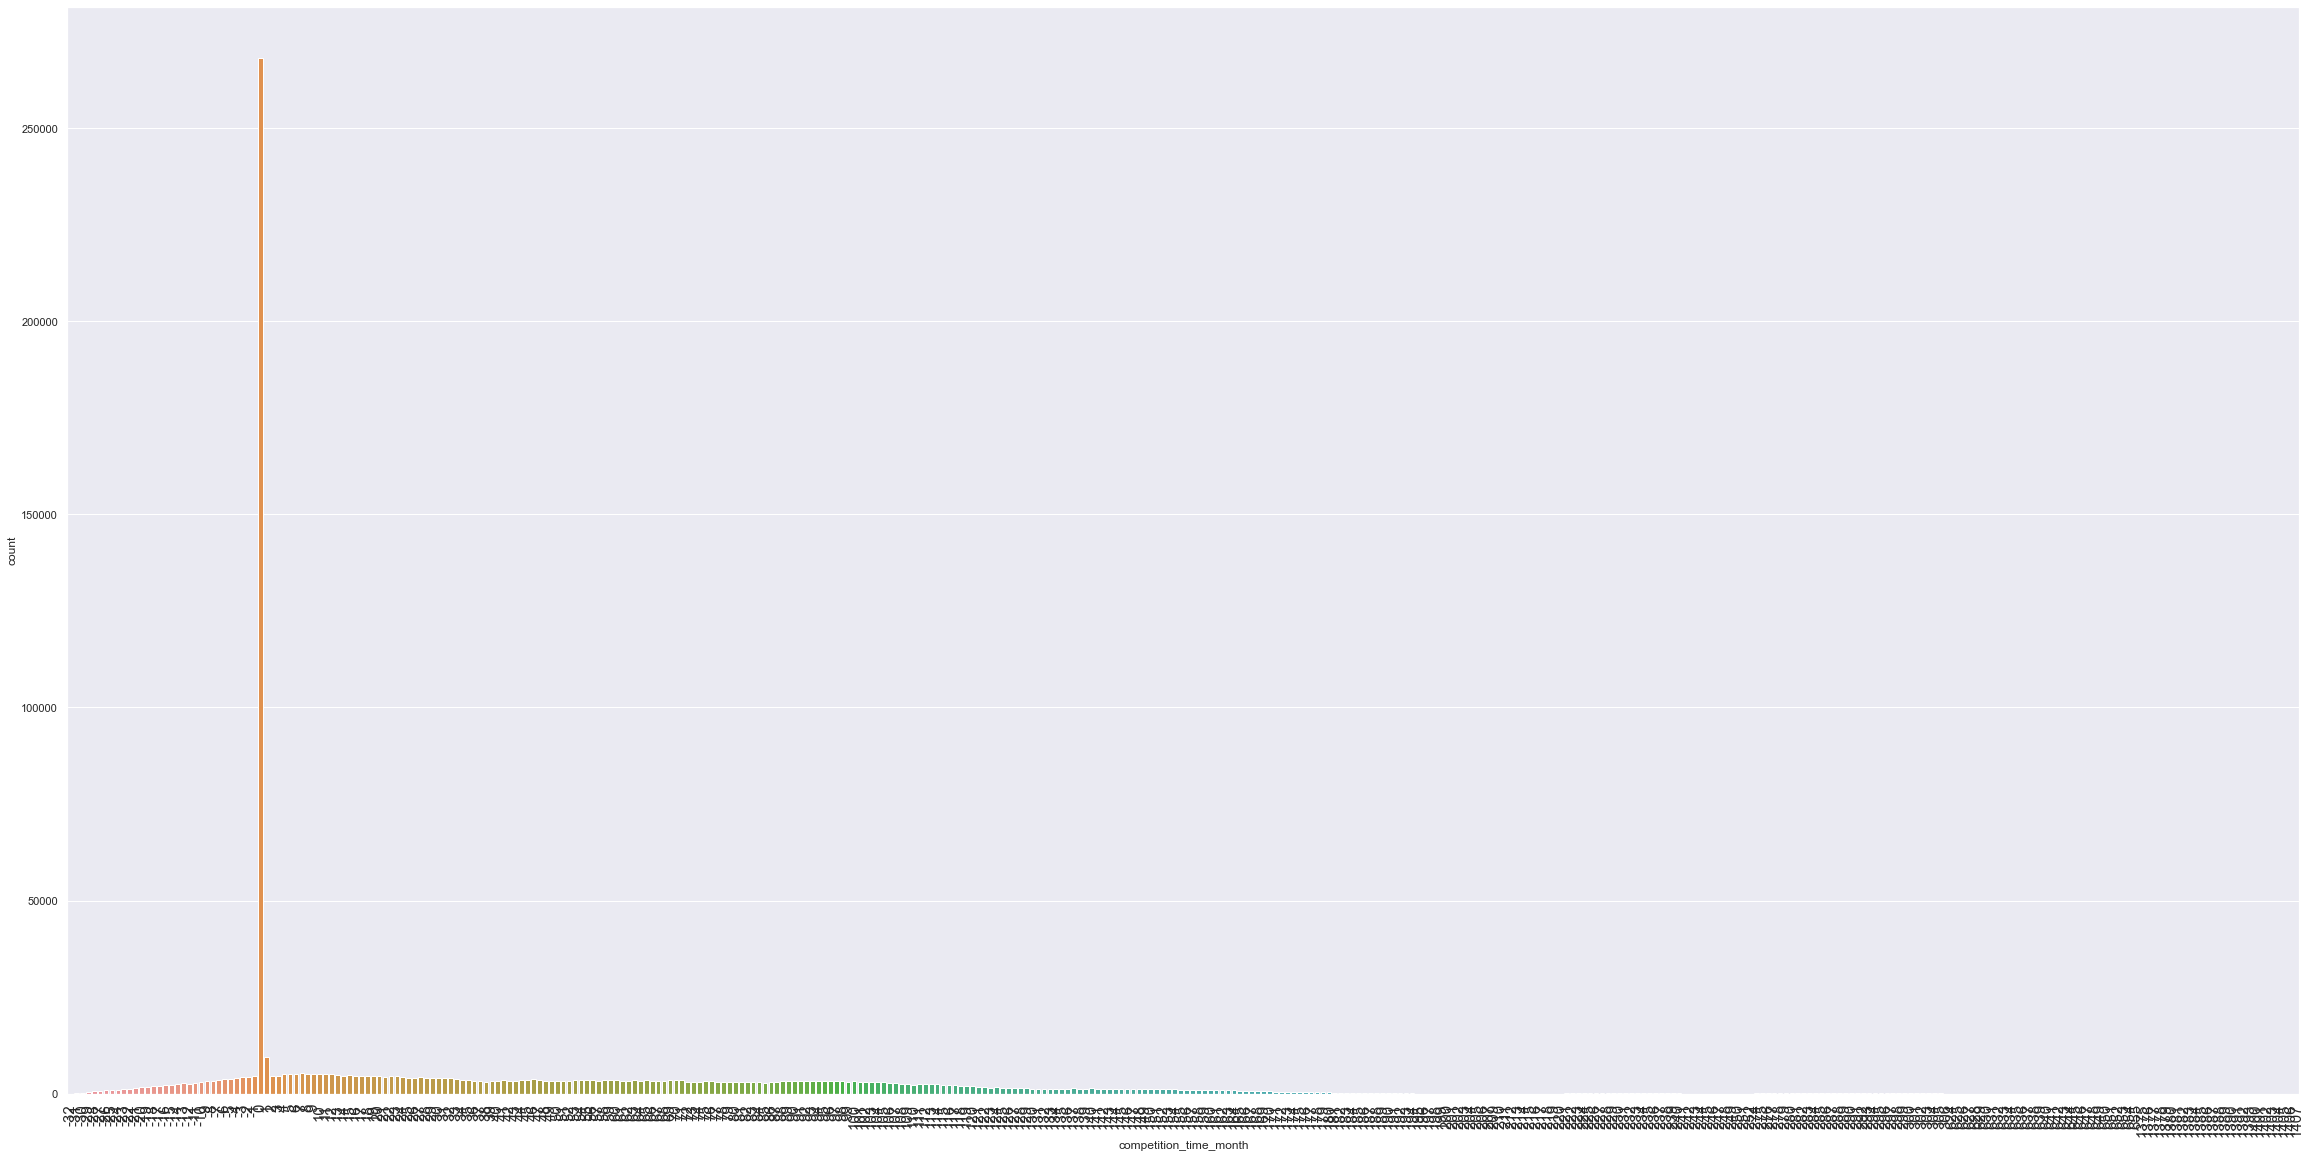

In [112]:
# Para resolver o problema anterior, devemos utilizar a variável competition_time_month que 
# informa quantos meses um competidor iniciou suas vendas.

# Gráfico para exibir a quantidade de ocorrências para cada valor de competition_time_month.
plt.figure(figsize=(40,20))  # Define o tamanho do gráfico.
sns.countplot(x=df4['competition_time_month'])
plt.xticks(rotation=90, fontsize=15);  # Rotaciona o label da coluna x em 90 graus e especifica o tamanho da fonte do label.

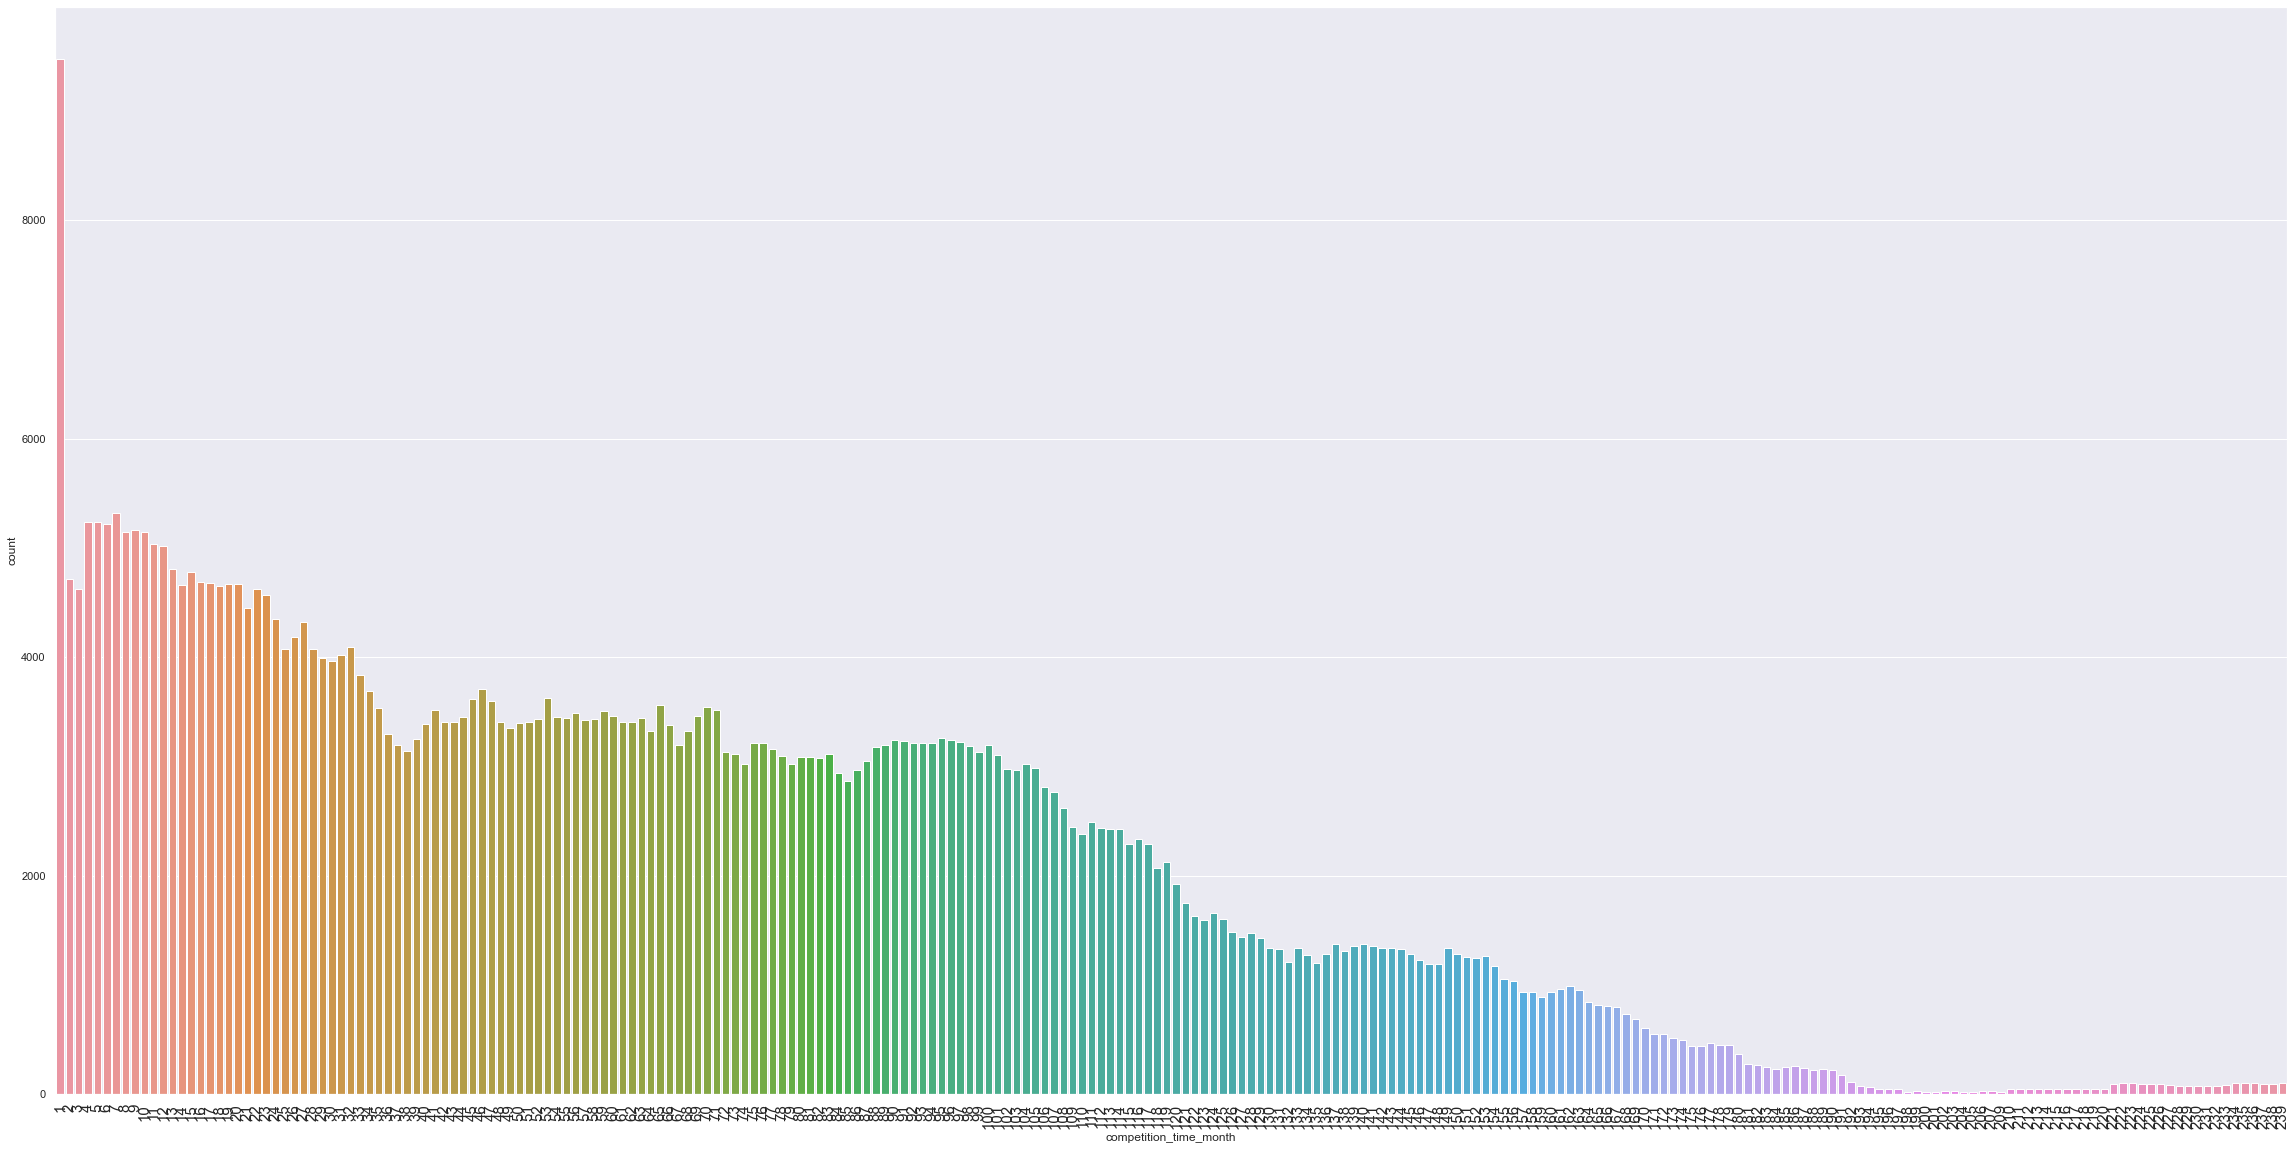

In [113]:
# Para melhorar a visualização do gráfico iremos exibir a quantidade de ocorrências para cada valor de competition_time_month
# considerando um valor maior que 0 e menor que 240.
aux17 = df4[(df4['competition_time_month'] > 0 ) & (df4['competition_time_month'] < 240)]
plt.figure(figsize=(40,20))  # Define o tamanho do gráfico.
sns.countplot(x=aux17['competition_time_month'])
plt.xticks(rotation=90, fontsize=15);  # Rotaciona o label da coluna x em 90 graus e especifica o tamanho da fonte do label.

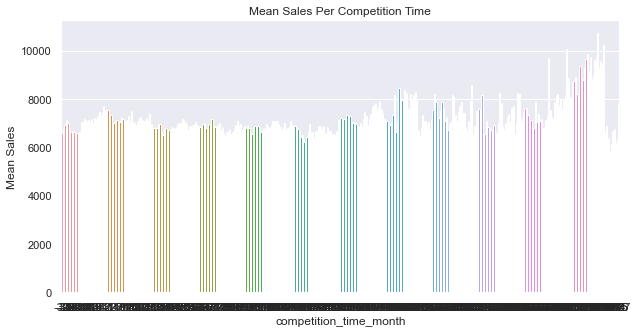

In [114]:
# O comando abaixo armazena na variável aux15 a média das vendas para cada valor de competition_time_month.
aux15 = df4[['competition_time_month', 'sales']].groupby('competition_time_month').mean().reset_index()

# Exibe um gráfico de barras.
sns.barplot(x='competition_time_month', y='sales', data=aux15).set_title('Mean Sales Per Competition Time');
plt.ylabel('Mean Sales');  # Configura o texto da coluna Y.

In [115]:
# No gráfico acima podemos comprovar que lojas com competidores a mais tempo vendem mais.

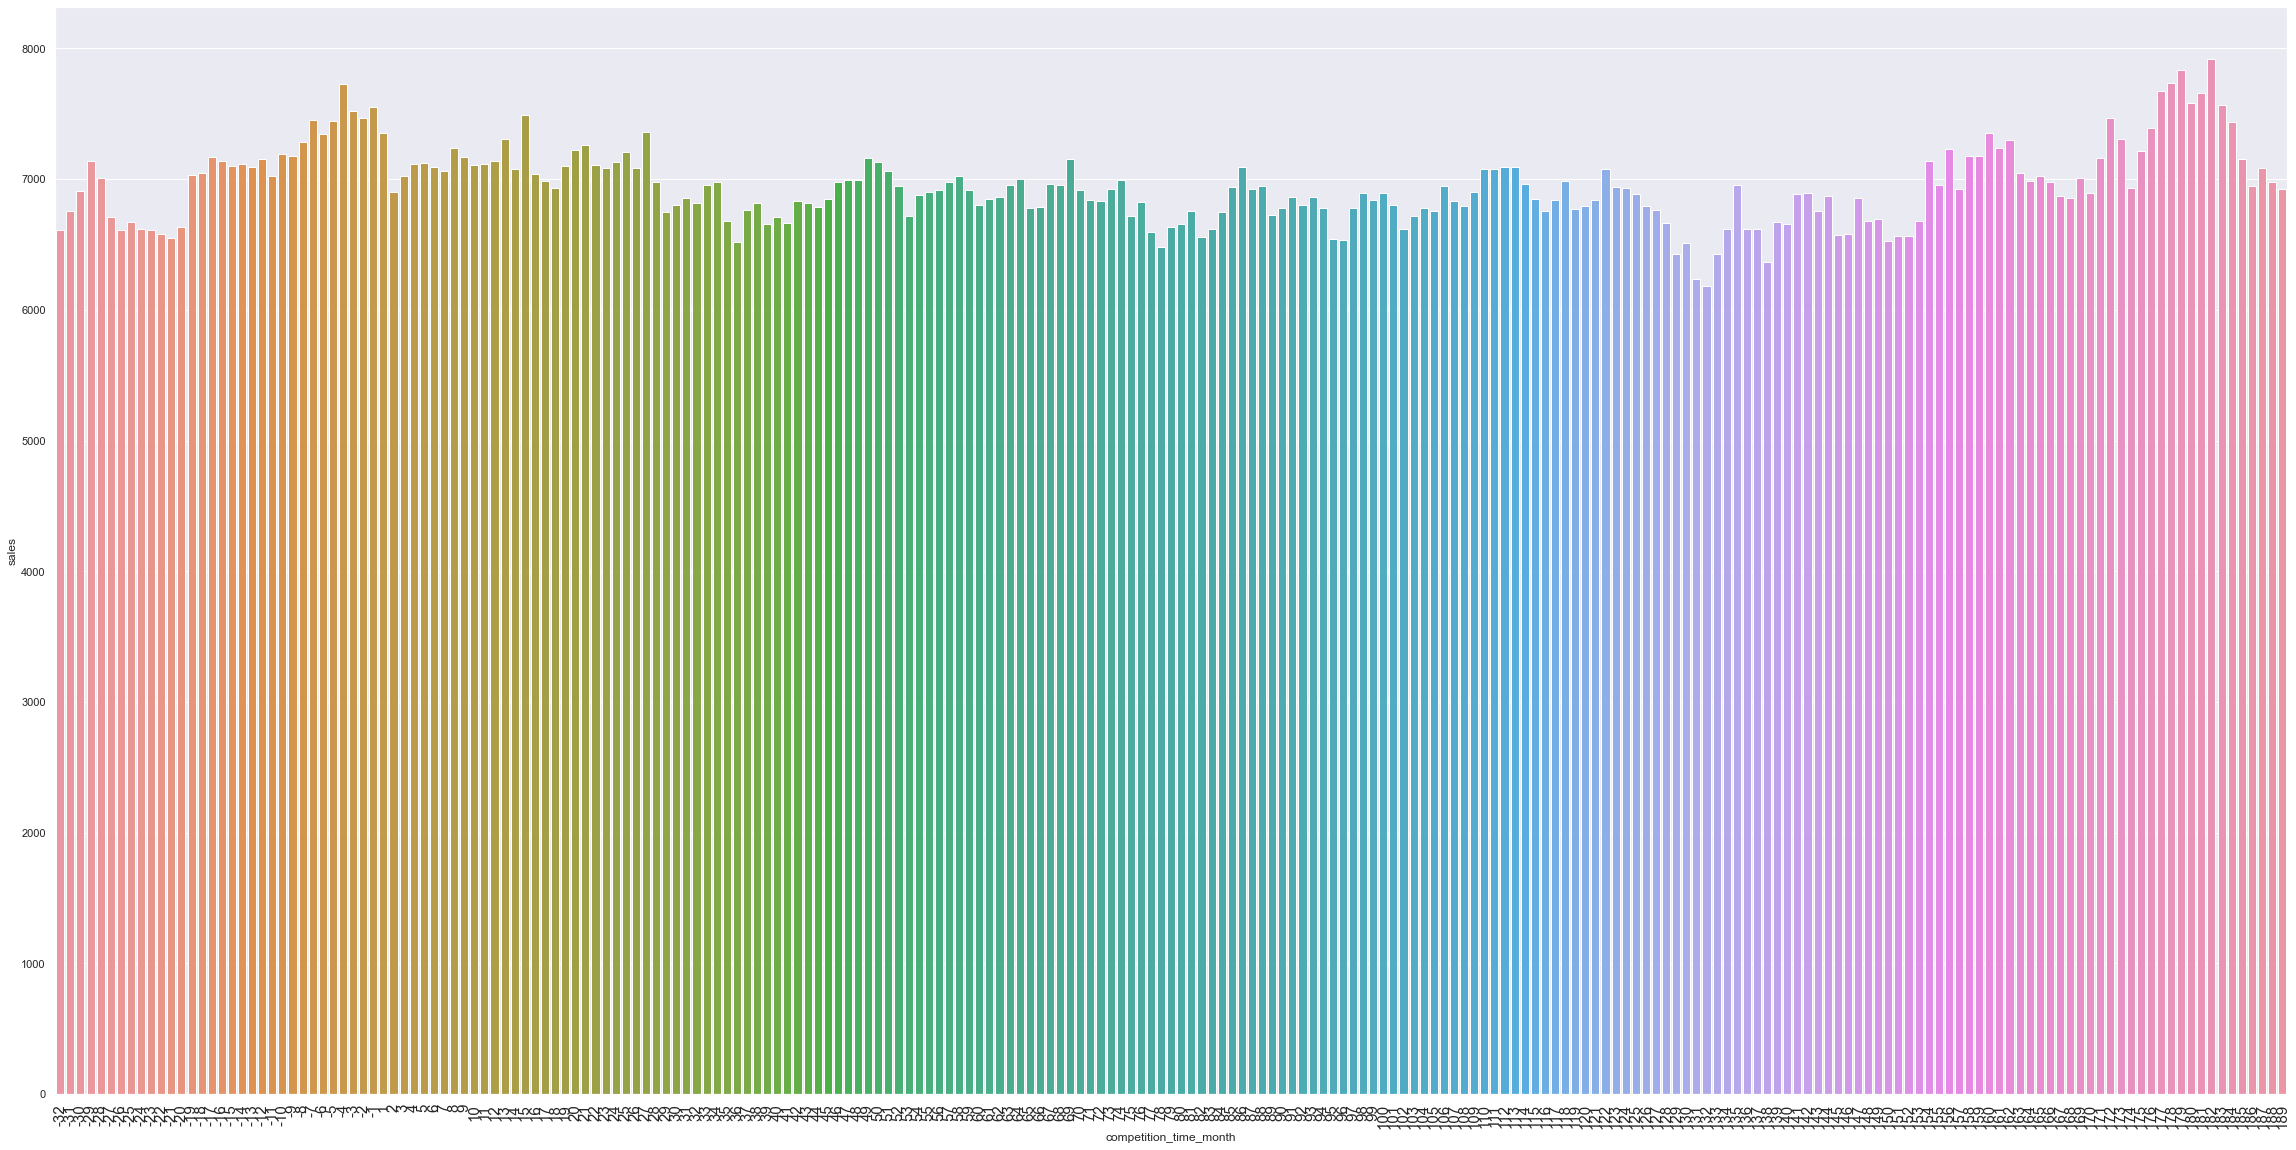

In [116]:
# Para melhorar a visualização acima, iremos limitar a exibição dos competidores que estão
# abertos no máximo 190 meses e não iremos exibir os competidores que possuem valor de 
# competition_time_month igual à zero.
aux16 = aux15[(aux15['competition_time_month'] < 190 ) & (aux15['competition_time_month'] != 0)]
plt.figure(figsize=(40,20))  # Define o tamanho do gráfico.
sns.barplot(x='competition_time_month', y='sales', data=aux16);
plt.xticks(rotation=90, fontsize=15);  # Rotaciona o label da coluna x em 90 graus e especifica o tamanho da fonte do label.

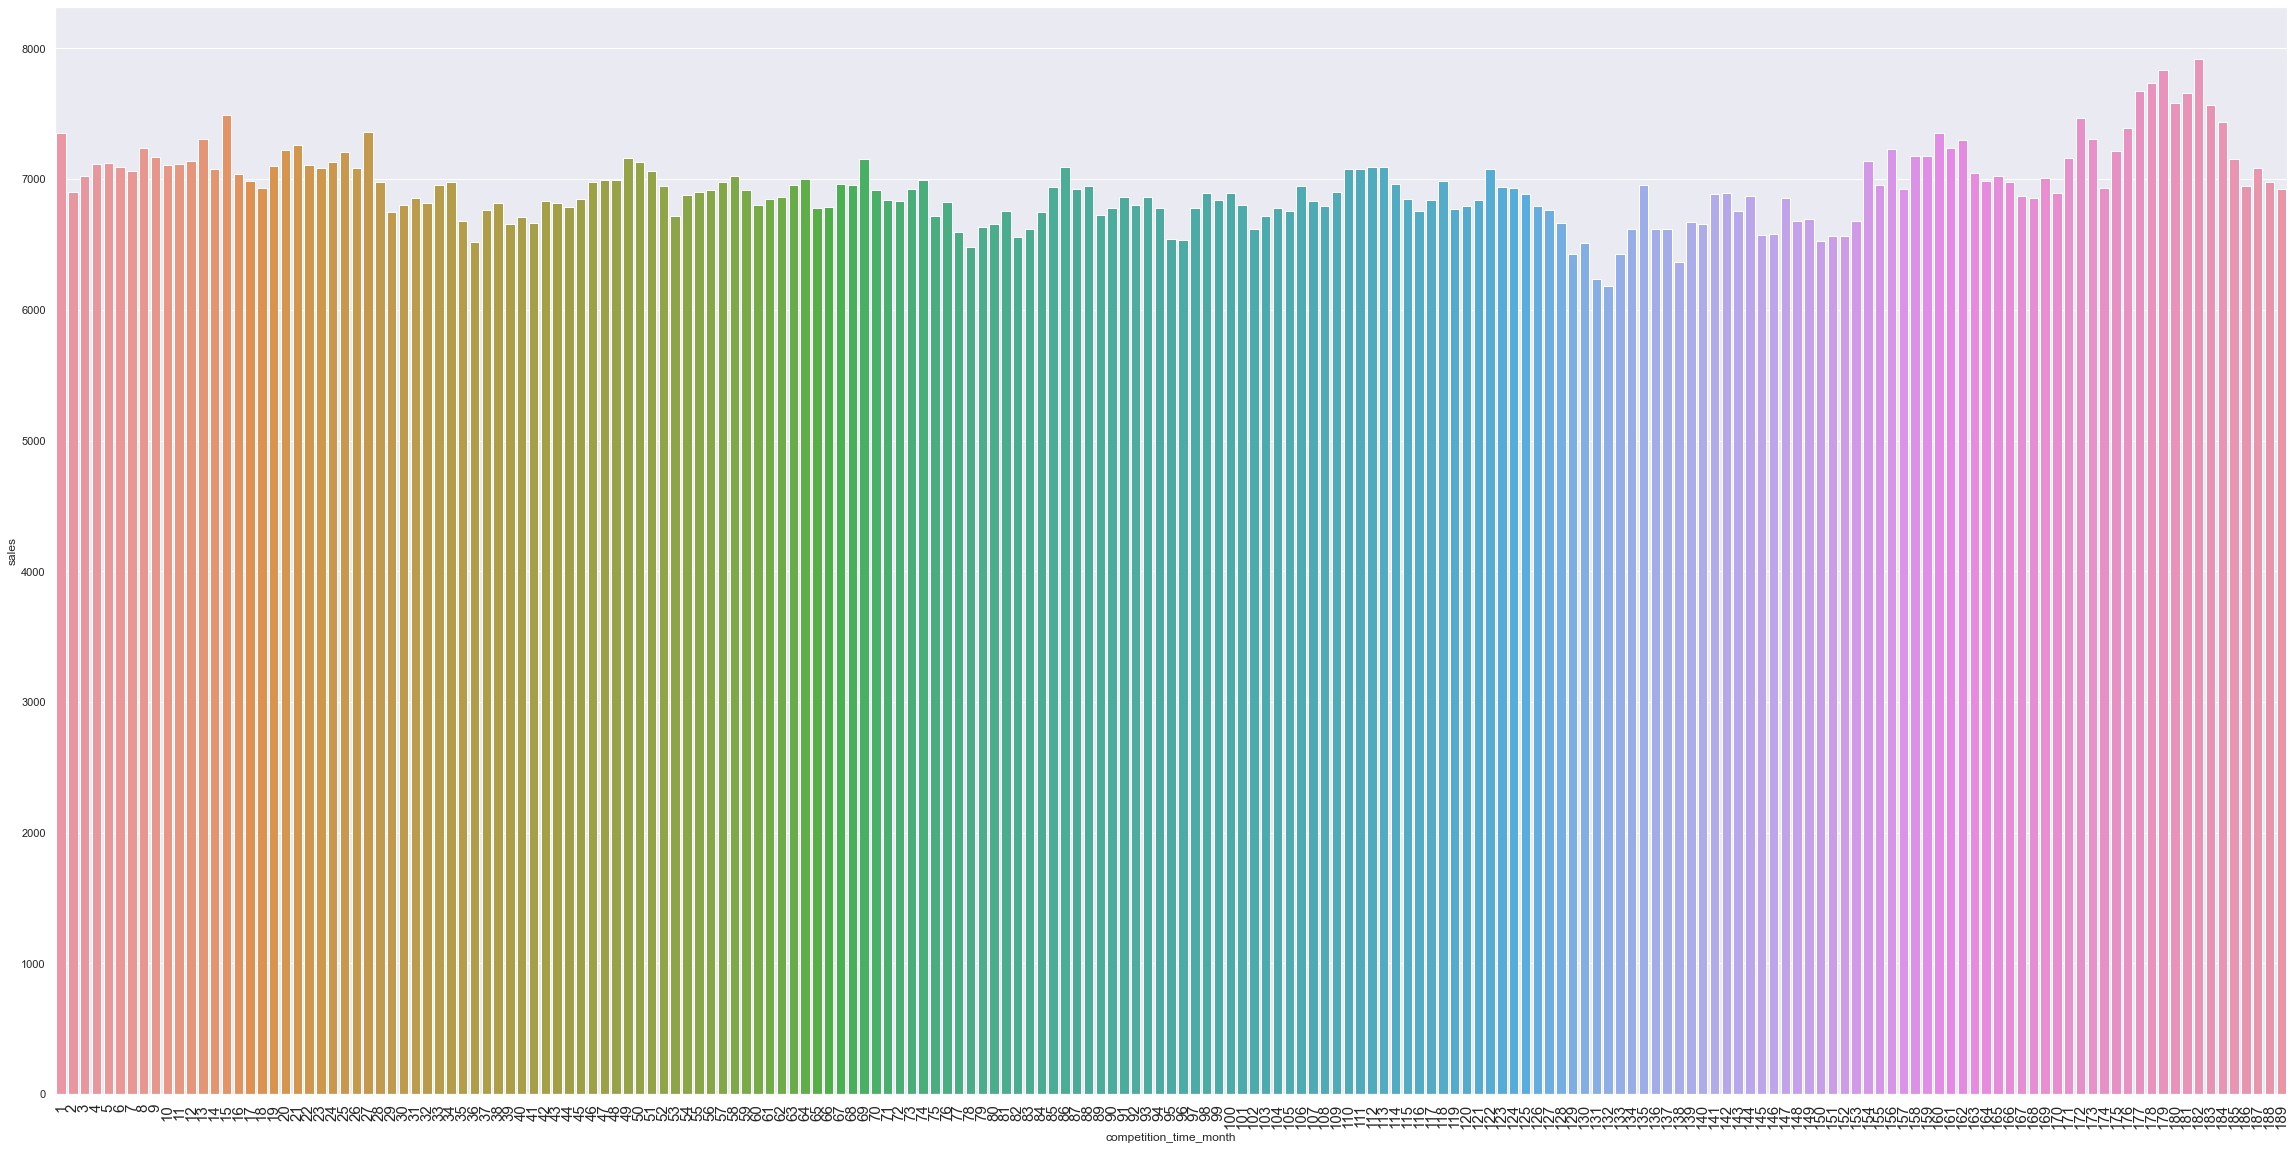

In [117]:
# No gráfico acima, a variável competition_time_month é a diferença de meses da data da venda com a data que o 
# competidor abril. Se estamos vendendo hoje e eu sei que o competidor vai abrir daqui a 4 meses, teremos um
# valor negativo de -4.

# Para não exibir os competidores que ainda irão abrir, iremos limitar a exibição dos competidores que estão
# abertos no máximo 190 meses e não iremos exibir os competidores que abriram em menos de 0 mês.
aux18 = aux15[(aux15['competition_time_month'] < 190 ) & (aux15['competition_time_month'] > 0)]
plt.figure(figsize=(40,20))  # Define o tamanho do gráfico.
sns.barplot(x='competition_time_month', y='sales', data=aux18);
plt.xticks(rotation=90, fontsize=15);  # Rotaciona o label da coluna x em 90 graus e especifica o tamanho da fonte do label.

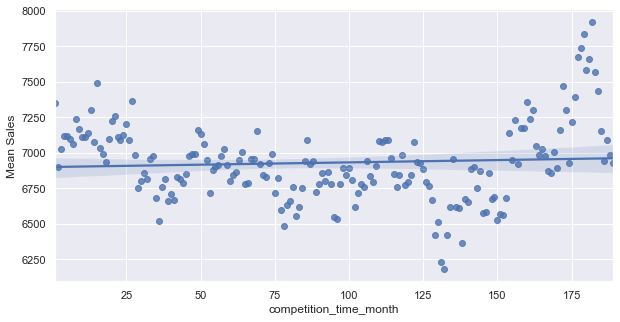

In [118]:
# O gráfico abaixo exibe os dados e a tendência de regressão linear para os dados filtrados,
# sendo, competidores que estão abertos no máximo 190 meses e não exibir os competidores que
# abriram em menos de 0 mês.
sns.regplot(x='competition_time_month', y='sales', data=aux18);
plt.ylabel('Mean Sales');  # Configura o texto da coluna Y.

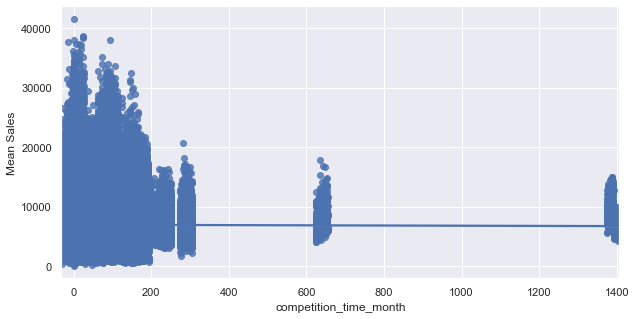

In [119]:
# O gráfico abaixo exibe os dados e a tendência de regressão linear para todos os dados.
sns.regplot(x='competition_time_month', y='sales', data=df4);
plt.ylabel('Mean Sales');  # Configura o texto da coluna Y.

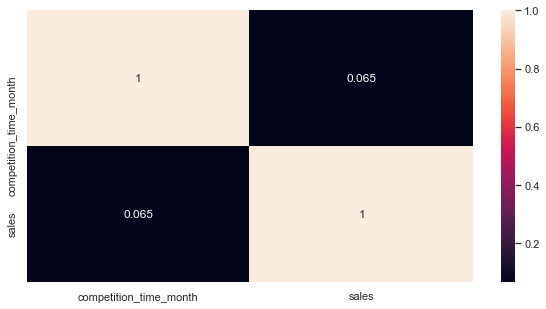

In [120]:
# O gráfico abaixo mede a força da correlação entre as variáveis competition_distance e sales,
# para os dados filtrados, sendo, competidores que estão abertos no máximo 190 meses e não
# exibir os competidores que abriram em menos de 1 mês.
sns.heatmap(aux18.corr(method='pearson'), annot=True);
# Os valores da correlação variam de 1 até -1.  Quanto mais próxima de zero, mais fraca é a 
# correlação. Quanto mais próximo de 1 ou -1, mais forte é a correlação.

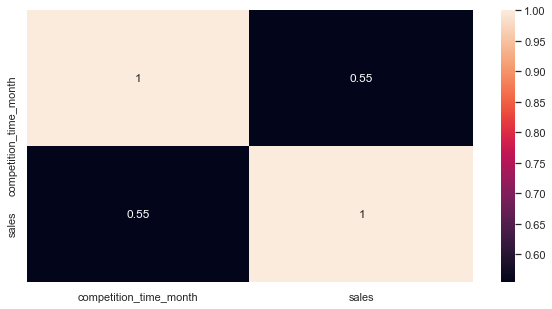

In [121]:
# O gráfico abaixo mede a força da correlação entre as variáveis competition_distance e sales,
# para todos os dados.
sns.heatmap(aux15.corr(method='pearson'), annot=True);
# Os valores da correlação variam de 1 até -1.  Quanto mais próxima de zero, mais fraca é a 
# correlação. Quanto mais próximo de 1 ou -1, mais forte é a correlação.

### **H4.** Lojas com promoções ativas por mais tempo deveriam vender mais.
**FALSA** Lojas com promoções ativas por mais tempo vendem MENOS depois de um certo período de promoção.

In [122]:
# Na fase de Feature Enginnering criamos uma coluna chamada "promo_time_week" contendo o valor em semanas de quanto tempo existe uma promoção.
# Este valor é a diferença da data da coluna "date" com o valor da data da coluna "promo_since", dividindo o resultado por 7 para
# obtermos a quantidade de semanas

# Se o valor da variável promo_time_week pode ter dois valores: positivos ou negativos.

# Se o valor da variável promo_time_week for negativo, significa que a data da venda é menor que a data do início da promoção estendida.
# Isto é, a promoção estendida não começou, significando que a venda foi feita em um periodo tradicional de promoção.

# Se o valor da variável promo_time_week for positivo, significa que a data da venda é maior que a data do início da promoção estendida. 
# Isto é, a promoção estendida já começou, significando que a venda foi feita em um período de promoção estendida.

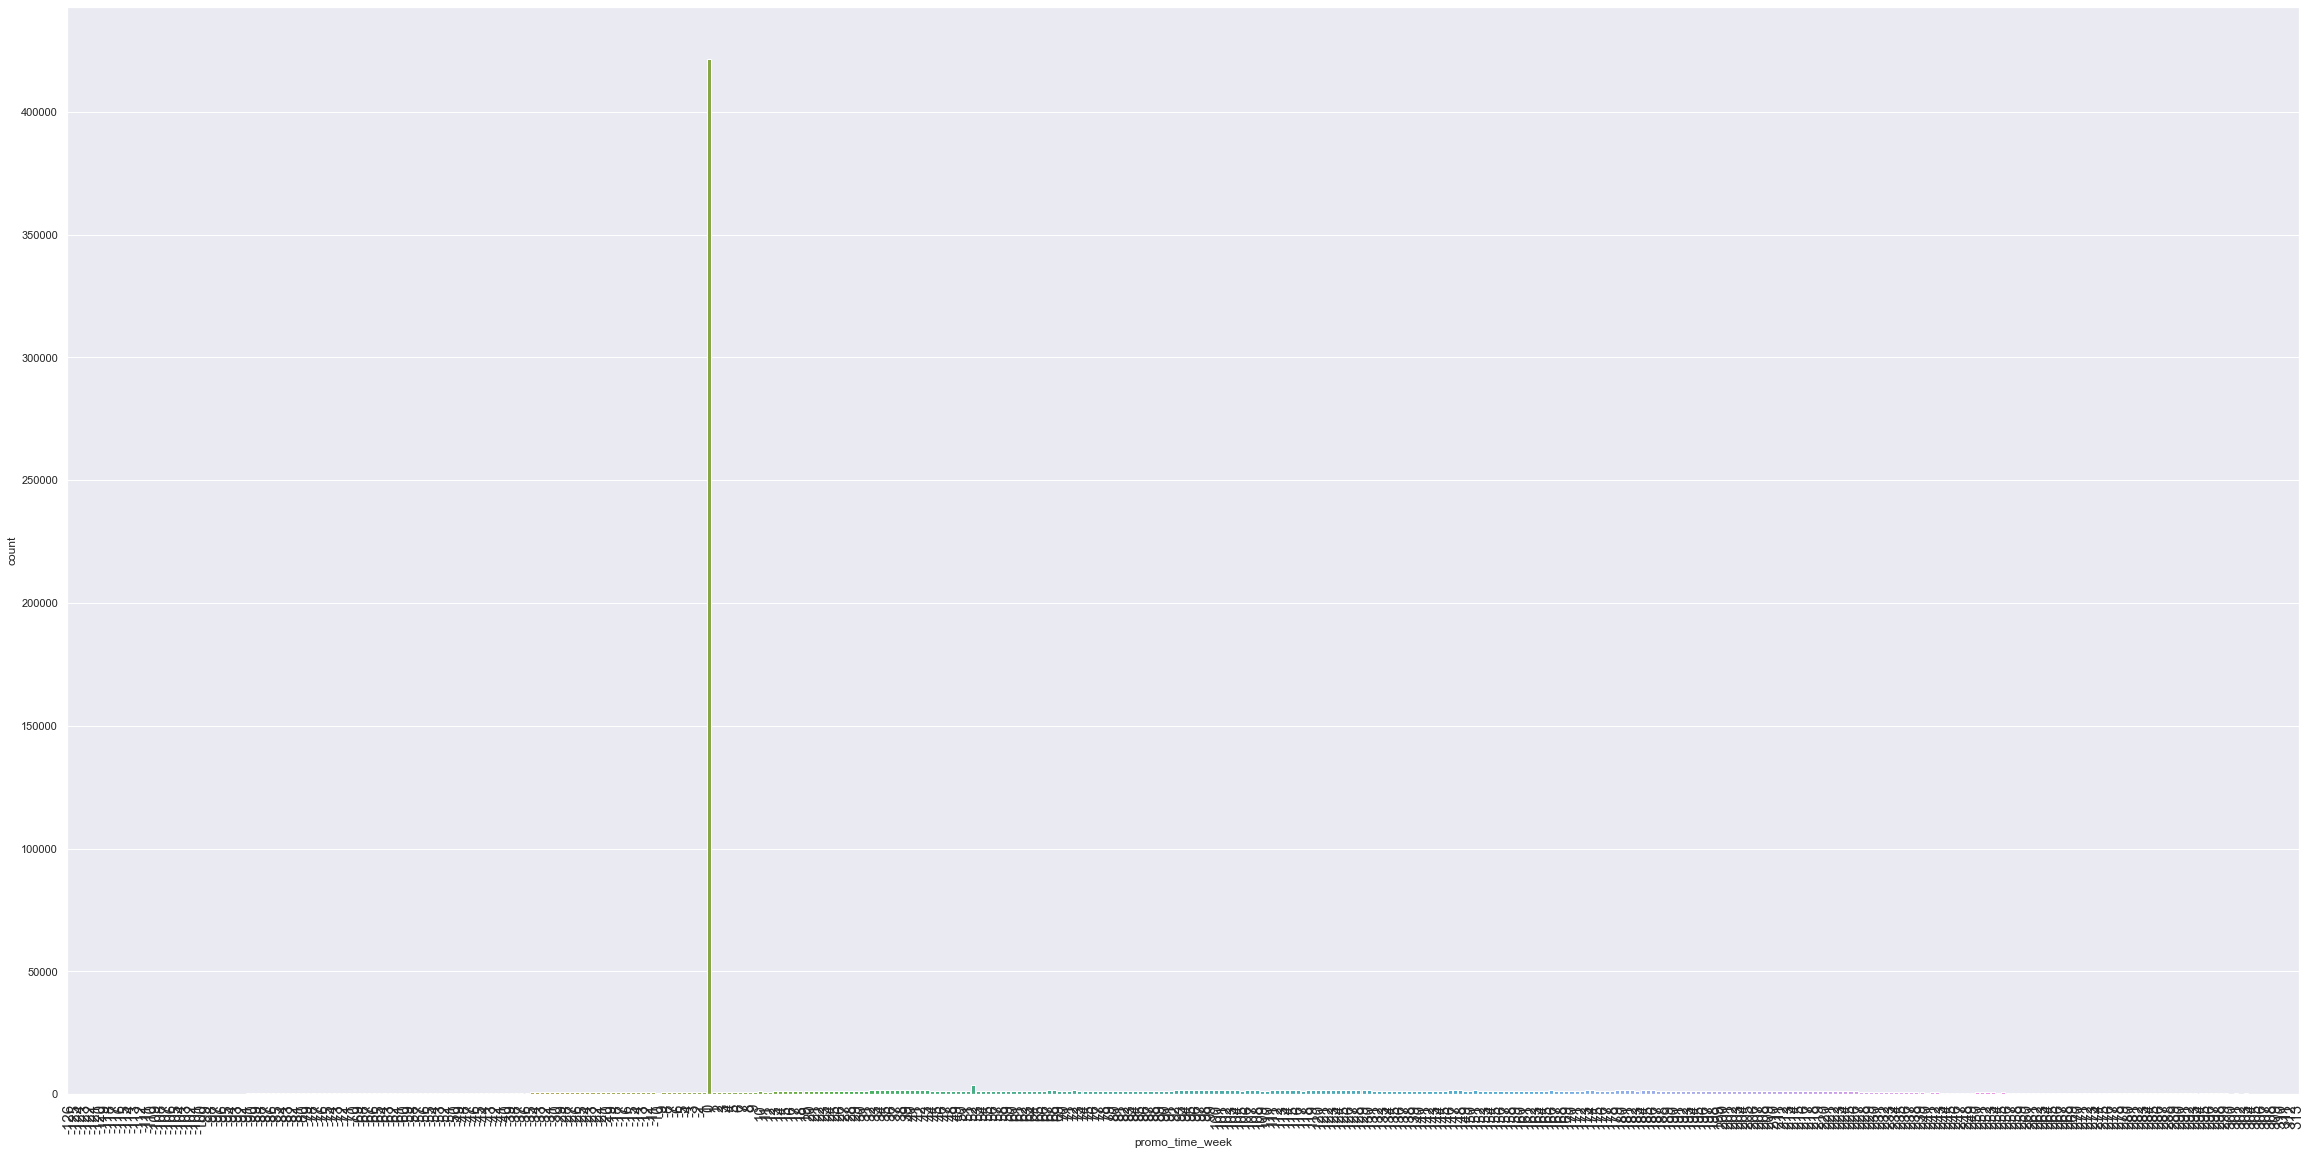

In [123]:
# Gráfico para exibir a quantidade de ocorrências para cada valor de promo_time_week.
plt.figure(figsize=(40,20))  # Define o tamanho do gráfico.
sns.countplot(x=df4['promo_time_week'])
plt.xticks(rotation=90, fontsize=15);  # Rotaciona o label da coluna x em 90 graus e especifica o tamanho da fonte do label.

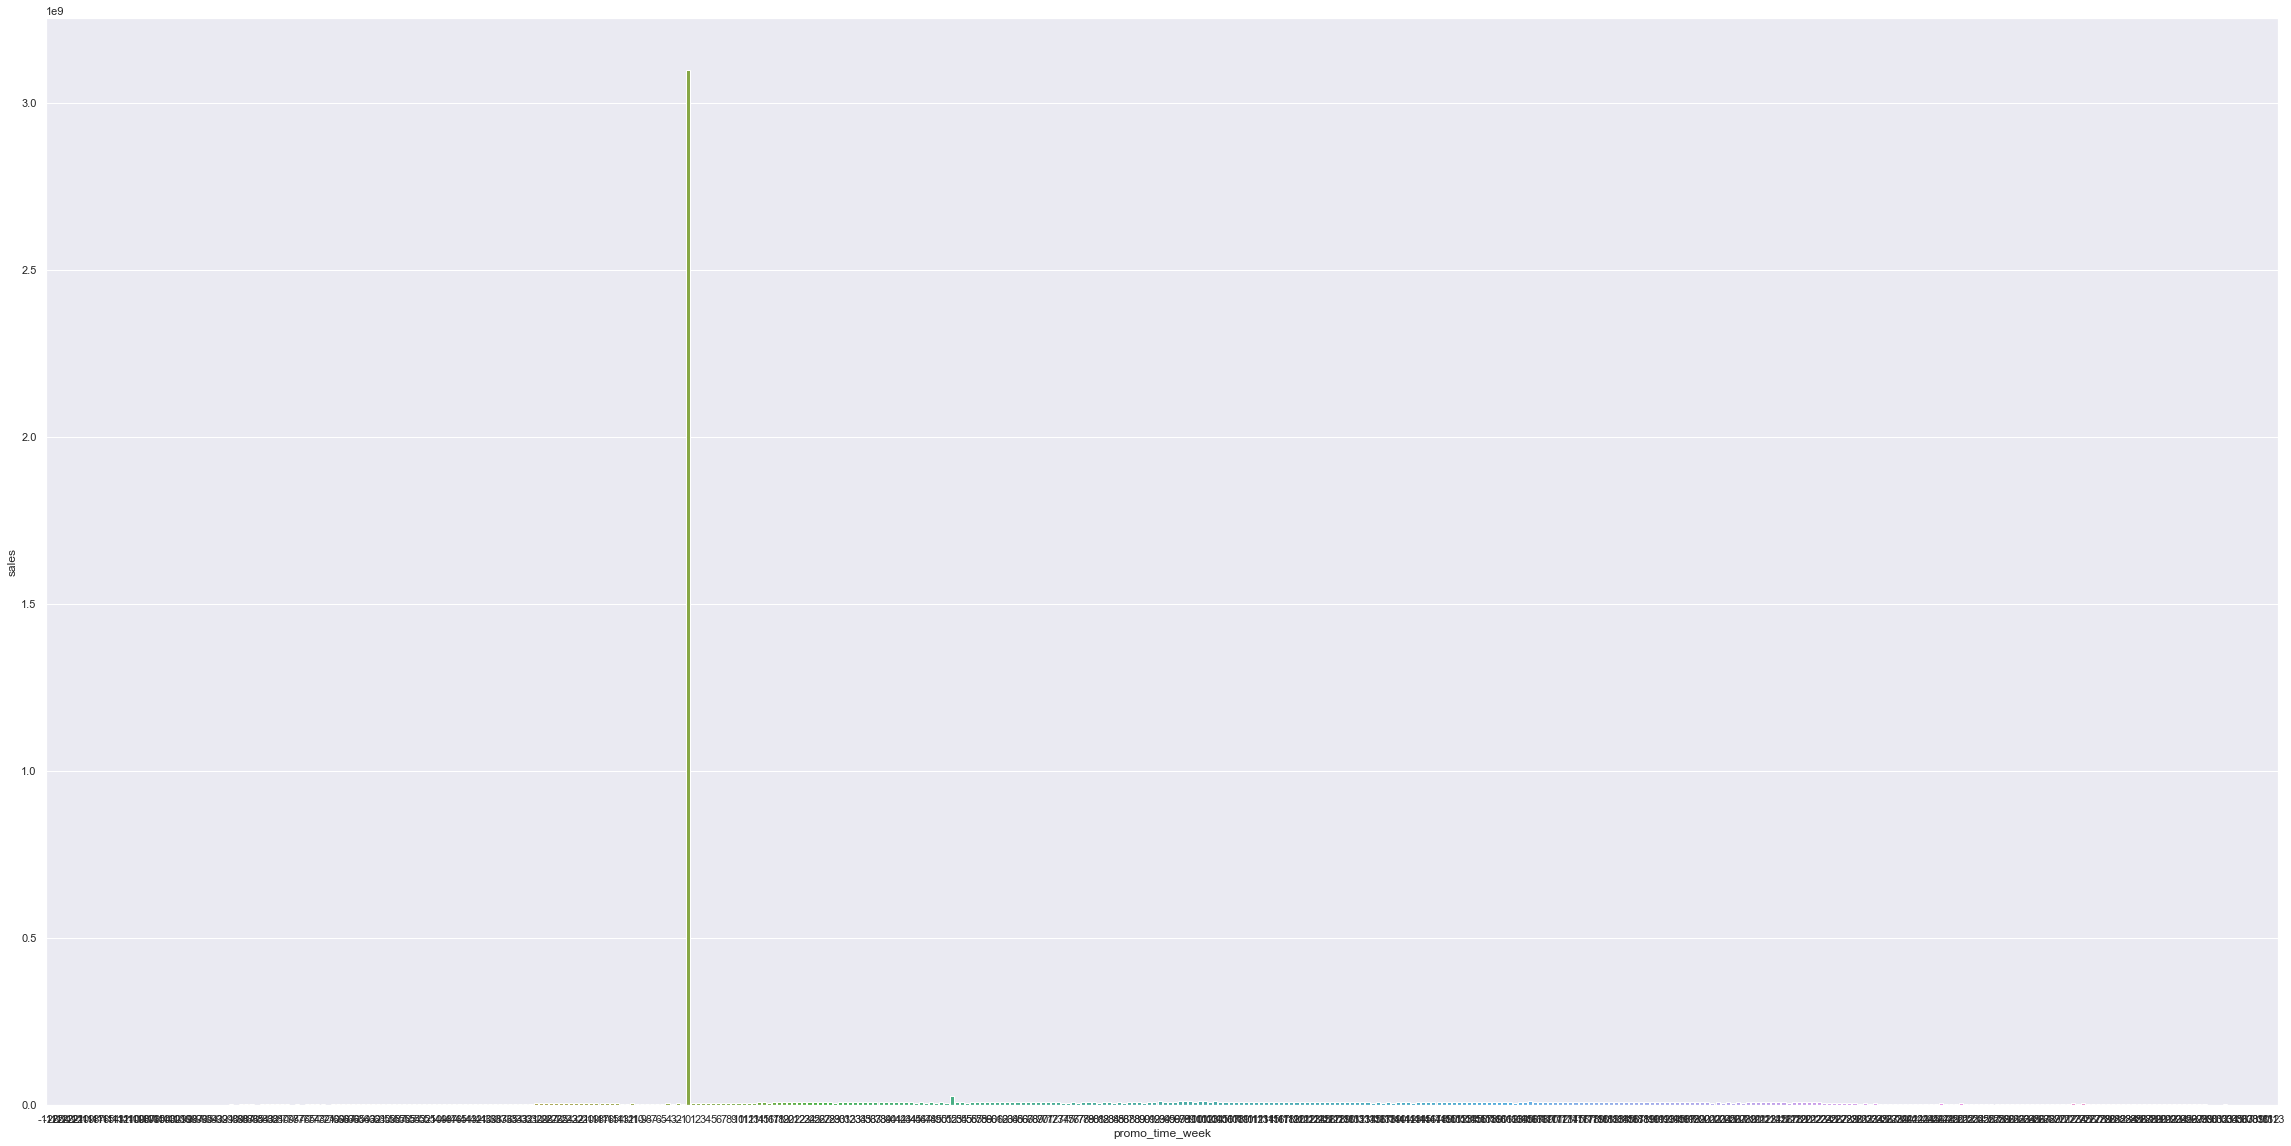

In [124]:
# O comando abaixo armazena a soma das vendas agrupados para cada valor de promo_time_week.
aux20 = df4[['promo_time_week', 'sales']].groupby('promo_time_week').sum().reset_index()

# Exibe um gráfico de barras.
plt.figure(figsize=(40,20))  # Define o tamanho do gráfico.
sns.barplot(x='promo_time_week', y= 'sales', data=aux20);

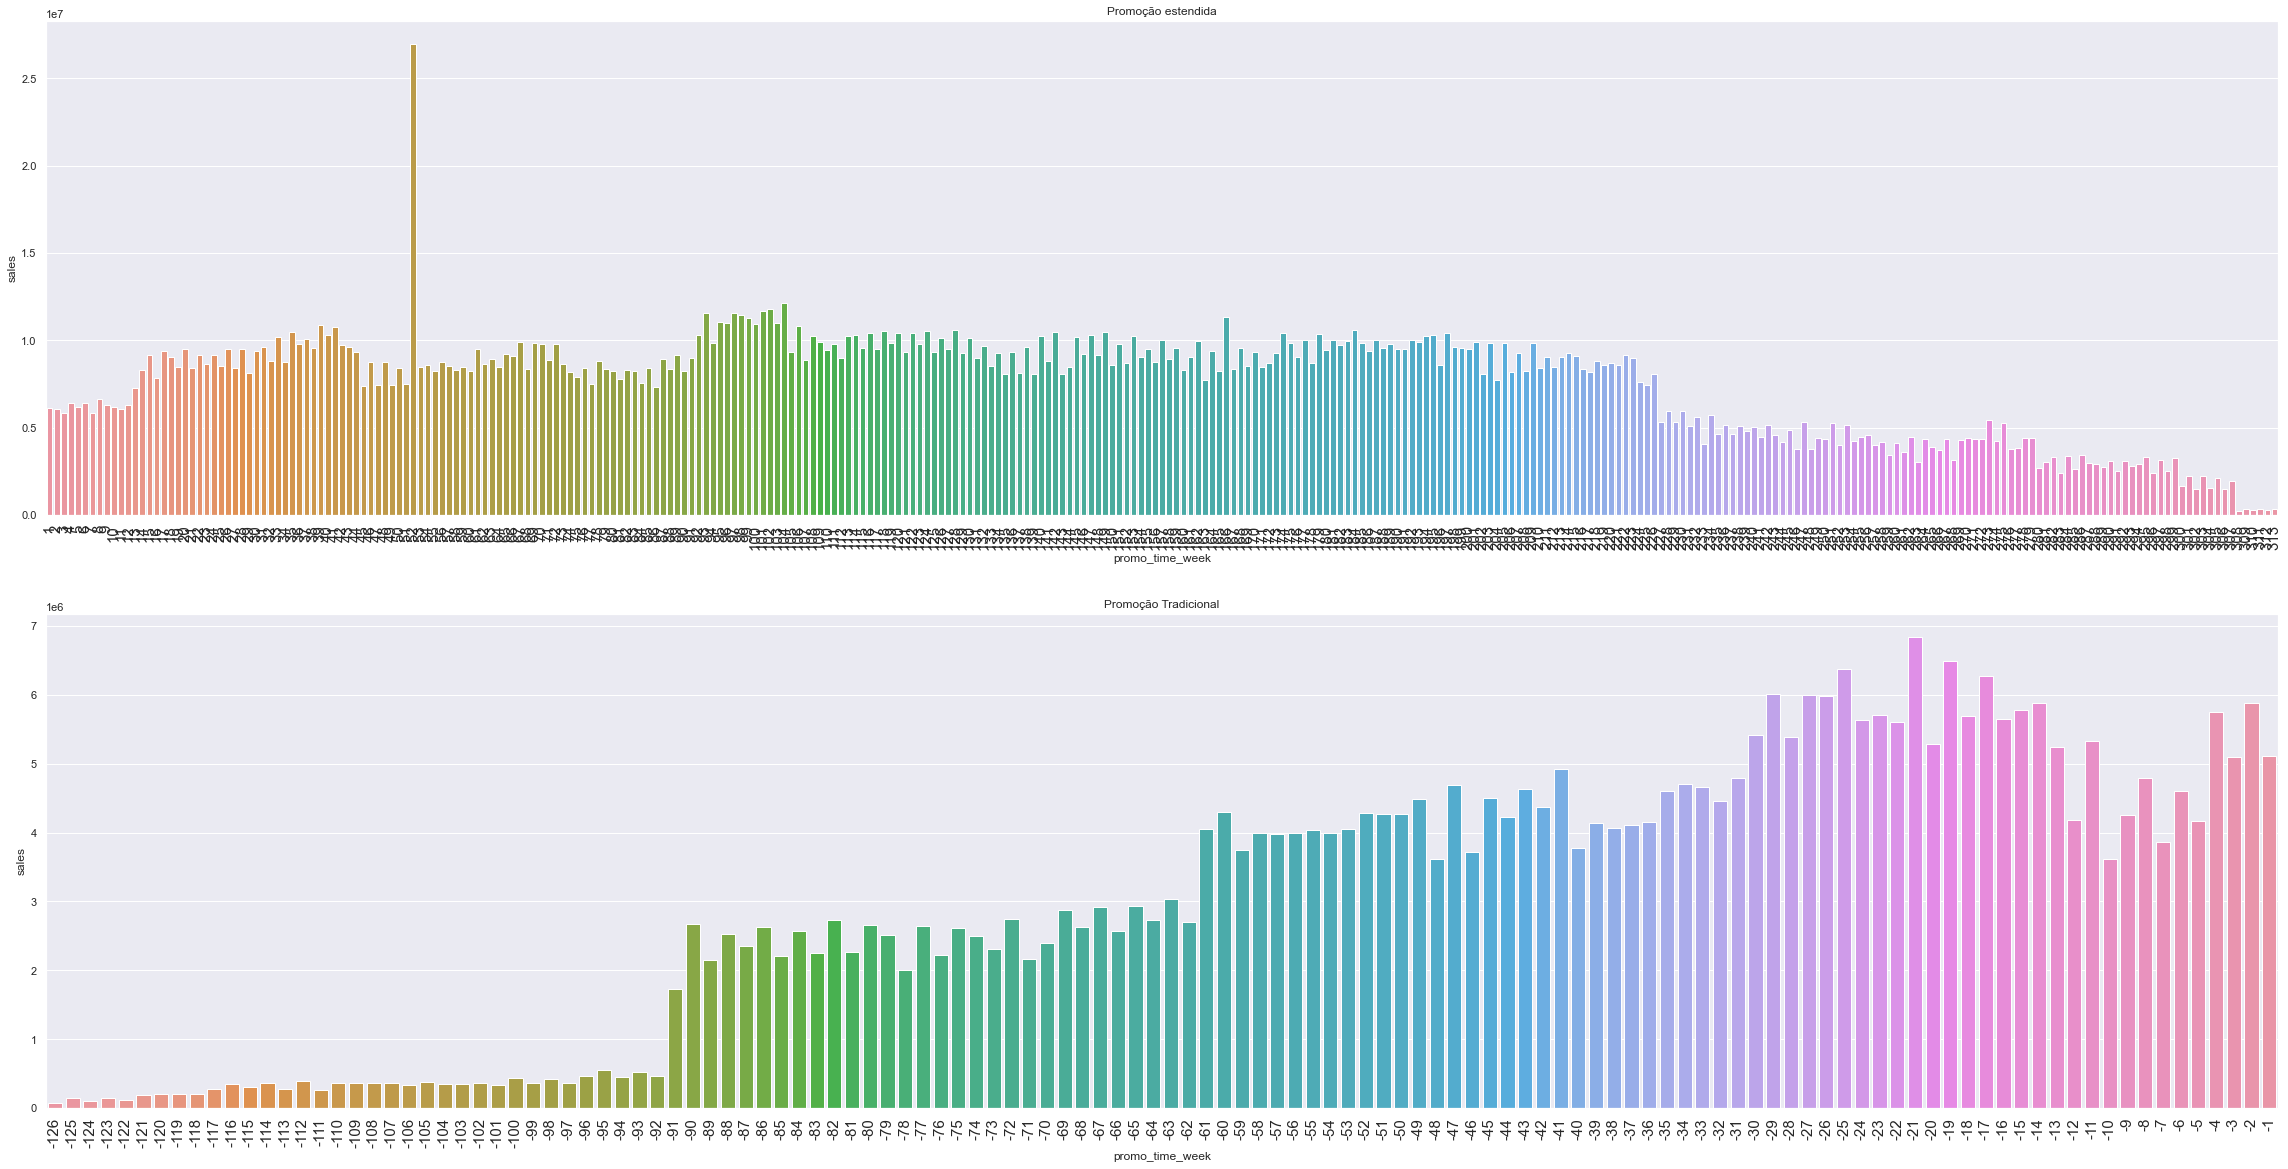

In [125]:
# Para melhorar a visualização separamos a visualização para cada período de promoção tradicional e estendido.

# O comando abaixo armazena a soma das vendas agrupados para cada valor de promo_time_week.
aux20 = df4[['promo_time_week', 'sales']].groupby('promo_time_week').sum().reset_index()

plt.figure(figsize=(40,20))  # Define o tamanho do gráfico.

plt.subplot(2,1,1)
aux21 = aux20[aux20['promo_time_week'] > 0]  # Promoção estendida.
sns.barplot(x='promo_time_week', y= 'sales', data=aux21).set_title('Promoção estendida');
plt.xticks(rotation=90, fontsize=15);  # Rotaciona o label da coluna x em 90 graus e especifica o tamanho da fonte do label.

plt.subplot(2,1,2)
aux22 = aux20[aux20['promo_time_week'] < 0]  # Promoção tradicional.
sns.barplot(x='promo_time_week', y= 'sales', data=aux22).set_title('Promoção Tradicional');
plt.xticks(rotation=90, fontsize=15);  # Rotaciona o label da coluna x em 90 graus e especifica o tamanho da fonte do label.

In [126]:
# No gráfico de promoção estendida acima, podemos observar que temos um patamar de vendas que se mantém ate uma certa semana,
# e depois começa a cair. O Insight é que a promoção estendida tem um tempo determinado que o efeito dela funciona. 
# após este período temos uma queda nas vendas.
# Podemos concluir que a hipótese é falsa pois as lojas vendem mais regularmente até um certo tempo e depois as vendam diminuem.

# No gráfico de promoção tradicional observamos que quando estamos chegando próximo da data da promoção estendida, 
# existem saltos nas vendas, nas semanas -90, -60 e -30. Isto pode ser um efeito de campanhas de marketing avisando
# que vai ocorrer uma promoção. As pessoas começam a perceber que irão ter oportunidade melhor de compra com desconto e elas
# começam a aumentar a compra.

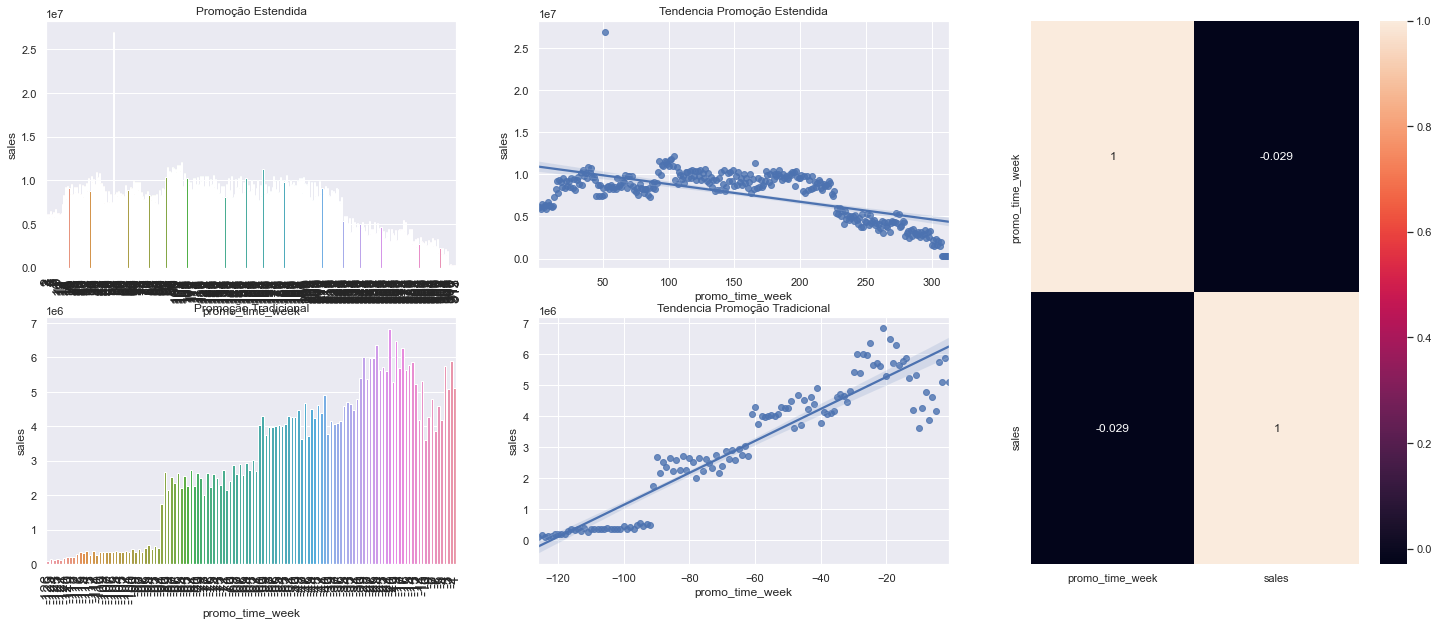

In [127]:
# Exibe os gráficos de barras para volume de vendas por tipo de promoção, o gráfico de tendencias e o gráfico da força da correlação.

# O comando abaixo armazena a soma das vendas agrupados para cada valor de promo_time_week.
aux20 = df4[['promo_time_week', 'sales']].groupby('promo_time_week').sum().reset_index()

fig = plt.figure( figsize=(25,10))
grid = gridspec.GridSpec(ncols=3, nrows=2, figure=fig)

plt.subplot(grid[0,0])
aux21 = aux20[aux20['promo_time_week'] > 0]  # Promoção estendida.
sns.barplot(x='promo_time_week', y= 'sales', data=aux21).set_title('Promoção Estendida');
plt.xticks(rotation=90, fontsize=15);  # Rotaciona o label da coluna x em 90 graus e especifica o tamanho da fonte do label.

plt.subplot(grid[0,1])
sns.regplot(x='promo_time_week', y='sales', data=aux21).set_title('Tendencia Promoção Estendida');

plt.subplot(grid[1,0])
aux22 = aux20[aux20['promo_time_week'] < 0]  # Promoção tradicional.
sns.barplot(x='promo_time_week', y= 'sales', data=aux22).set_title('Promoção Tradicional');
plt.xticks(rotation=90, fontsize=15);  # Rotaciona o label da coluna x em 90 graus e especifica o tamanho da fonte do label.

plt.subplot(grid[1,1])
sns.regplot(x='promo_time_week', y='sales', data=aux22).set_title('Tendencia Promoção Tradicional');

plt.subplot(grid[2:])  # Ocupa as duas últimas linhas da terceira coluna.
sns.heatmap(aux20.corr(method='pearson'), annot=True);

### <s>**H5.** Lojas com mais dias de promoção deveriam vender mais.</s>

In [128]:
# A Hipótese 4: "Lojas com promoções ativas por mais tempo deveriam vender mais" é bem similar
# à hipótese 5: "Lojas com mais dias de promoção deveriam vender mais".
# Para podermos validar esta hipótese 5, temos que criar uma nova variável chamada dias_de_promocao,
# e agrupar os dias_de_promocao por loja. Como estamos trabalhando com o CRISP, iremos validar esta hipótese
# no segundo ciclo do CRISP.

### **H6.** Lojas com mais promoções consecutivas deveriam vender mais.
**FALSA** Lojas com mais promoções consecutivas vendem MENOS.

In [129]:
# Valida se as lojas que entram no período consecutivo de promoção vendem mais que as lojas
# que não entram no período consecutivo de promoção.

In [130]:
# Exibe a quantidade de lojas que não participaram de nenhuma promoção.
df4[(df4['promo'] == 0) & (df4['promo2'] == 0)].shape[0]

234287

In [131]:
# Exibe a quantidade de lojas que participaram da promoção estendida.
df4[(df4['promo'] == 0) & (df4['promo2'] == 1)].shape[0]

233176

In [132]:
# Exibe a quantidade de lojas que participaram da promoção tradicional.
df4[(df4['promo'] == 1) & (df4['promo2'] == 0)].shape[0]

189005

In [133]:
# Exibe a quantidade de lojas que participaram de ambas as promoções, isto é, do período consecutivo de promoção.
df4[(df4['promo'] == 1) & (df4['promo2'] == 1)].shape[0]

187870

In [134]:
# Exibe a soma das vendas agrupados pelos atributos promo e promo2.
df4[['promo', 'promo2', 'sales']].groupby(['promo', 'promo2']).sum().reset_index()

,promo,promo2,sales
0,0,0,1482612096
1,0,1,1289362241
2,1,0,1628930532
3,1,1,1472275754


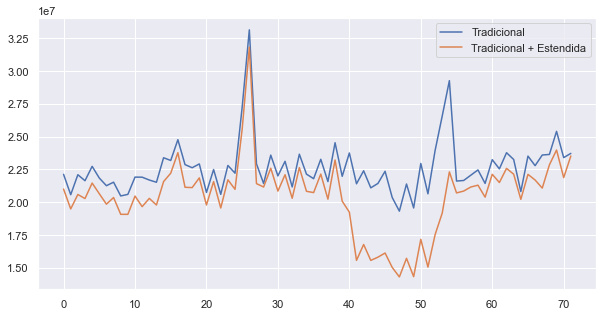

In [135]:
# Exibe um gráfico da quantidade de vendas ao longo do tempo, considerando as lojas que participaram da promoção
# tradicional e das lojas que participaram da promoção consecutiva, isto é, tradicional+estendida.

# Exibe o gráfico da soma das vendas ao longo do tempo para as lojas que participaram apenas da promoção tradicional.
aux23 = df4[(df4['promo'] == 1) & (df4['promo2'] == 0)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
ax = aux23.plot()

# Exibe o gráfico da soma das vendas ao longo do tempo para as lojas que participaram da promoção consecutiva,
# isto é, que participaram da promoção tradicional e estendida.
aux24= df4[(df4['promo'] == 1) & (df4['promo2'] == 1)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
aux24.plot(ax=ax)  # ax=ax significa para plotar o gráfico no mesmo gráfico ax anterior.

ax.legend(labels=['Tradicional', 'Tradicional + Estendida'])

In [136]:
# No gráfico acima observamos que as lojas que participaram da promoção consecutiva,
# isto é, (tradicional + estendida) possuem um volume de vendas menor do que as lojas
# que apenas participaram da promoção tradicional.

### **H7.** Lojas abertas durante o feriado de Natal deveriam vender mais.
**FALSA** Lojas abertas durante o Natal vendem MENOS do que as lojas abertas durante o feriado de páscoa.

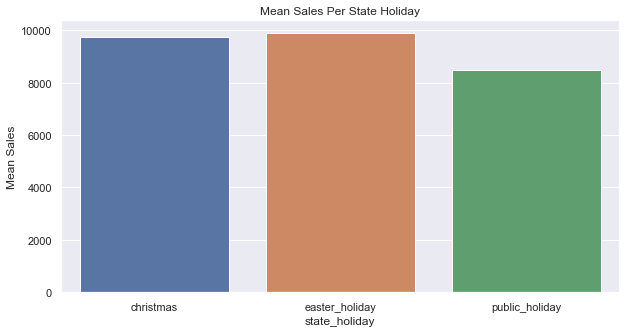

In [137]:
# Exibe a média das vendas para cada tipo de feriado (state_holiday), excluíndo os dias normais.
aux25 = df4[df4['state_holiday'] != 'regular_day']
aux26 = aux25[['state_holiday', 'sales']].groupby('state_holiday').mean().reset_index()
sns.barplot(x='state_holiday', y='sales', data=aux26).set_title('Mean Sales Per State Holiday');
plt.ylabel('Mean Sales');  # Configura o texto da coluna Y.

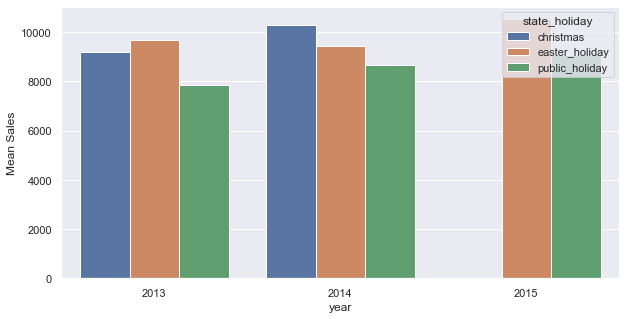

In [138]:
# O exemplo abaixo verifica o comportamento das vendas dos feriados ao longo dos anos.
aux27 = aux25[['year', 'state_holiday', 'sales']].groupby(['year', 'state_holiday']).mean().reset_index()
sns.set(rc={"figure.figsize":(10, 5)}) #width=10, height=5
sns.barplot(x='year', y='sales', hue='state_holiday', data=aux27);
plt.ylabel('Mean Sales');  # Configura o texto da coluna Y.
# O gráfico abaixo informa que o feriado de natal vendeu mais na média no ano de
# 2014 do que no ano de 2013. O gráfico mostra também que o ano de 2015 ainda não está 
# completo, pois não existe o feriado de natal em 2015.

### **H8.** Lojas deveriam vender mais ao longo dos anos.
**VERDADEIRA** Lojas vendem MAIS ao longo dos anos.

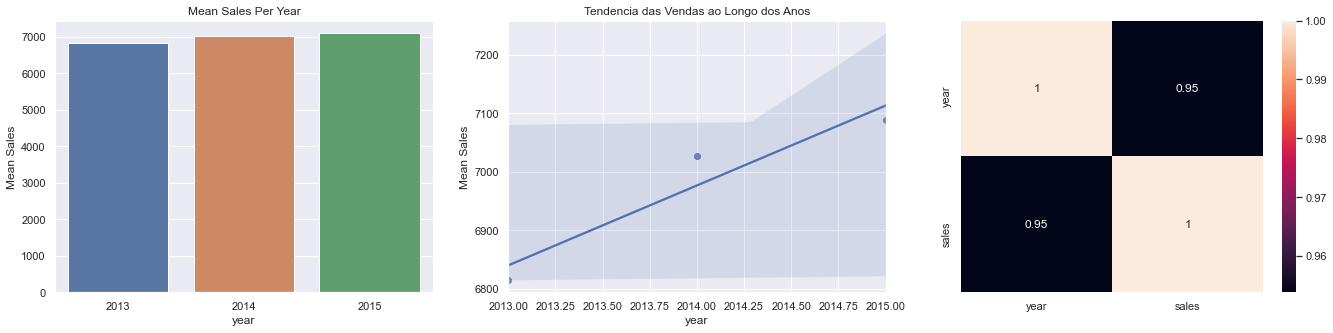

In [139]:
# Exibe a média das vendas ao longo dos anos, o gráfico de tendencias e o gráfico da força da correlação.
aux28 = df4[['year', 'sales']].groupby('year').mean().reset_index()

plt.figure(figsize=(23,5))

plt.subplot(1, 3, 1) # Uma linha e três colunas na primeira posição.
sns.barplot(x='year', y='sales', data=aux28).set_title('Mean Sales Per Year');
plt.ylabel('Mean Sales');  # Configura o texto da coluna Y.

plt.subplot(1, 3, 2) # Uma linha e três colunas na segunda posição.
sns.regplot(x='year', y='sales', data=aux28).set_title('Tendencia das Vendas ao Longo dos Anos');
plt.ylabel('Mean Sales');  # Configura o texto da coluna Y.

plt.subplot(1, 3, 3) # Uma linha e três colunas na terceira posição.
sns.heatmap(aux28.corr(method='pearson'), annot=True);

### **H9.** Lojas deveriam vender mais no segundo semestre do ano.
**VERDADEIRA** Lojas vendem MAIS no segundo semestre.

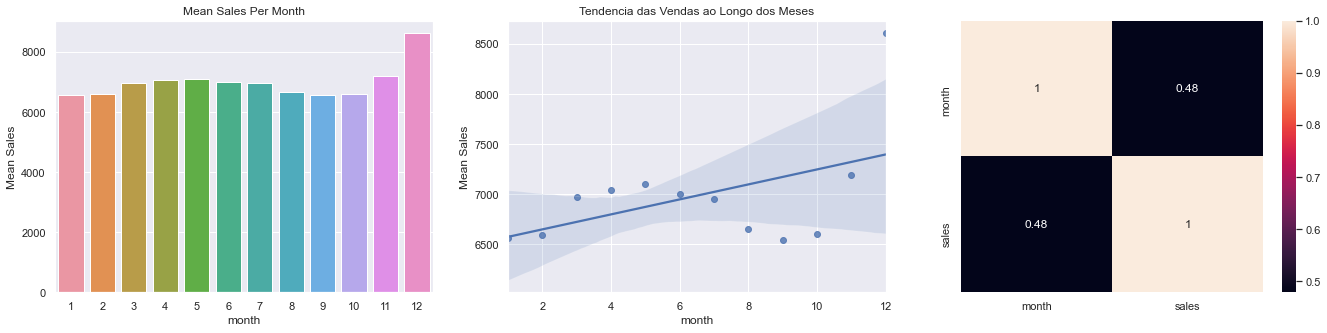

In [140]:
# Exibe a média das vendas ao longo dos meses, o gráfico de tendencias e o gráfico da força da correlação.
aux29 = df4[['month', 'sales']].groupby('month').mean().reset_index()

plt.figure(figsize=(23,5))

plt.subplot(1, 3, 1) # Uma linha e três colunas na primeira posição.
sns.barplot(x='month', y='sales', data=aux29).set_title('Mean Sales Per Month');
plt.ylabel('Mean Sales');  # Configura o texto da coluna Y.

plt.subplot(1, 3, 2) # Uma linha e três colunas na segunda posição.
sns.regplot(x='month', y='sales', data=aux29).set_title('Tendencia das Vendas ao Longo dos Meses');
plt.ylabel('Mean Sales');  # Configura o texto da coluna Y.

plt.subplot(1, 3, 3) # Uma linha e três colunas na terceira posição.
sns.heatmap(aux29.corr(method='pearson'), annot=True);

### **H10.** Lojas deveriam vender mais depois do dia 10 de cada mês.
**FALSA** Lojas vendem MENOS depois do dia 10 de cada mês.

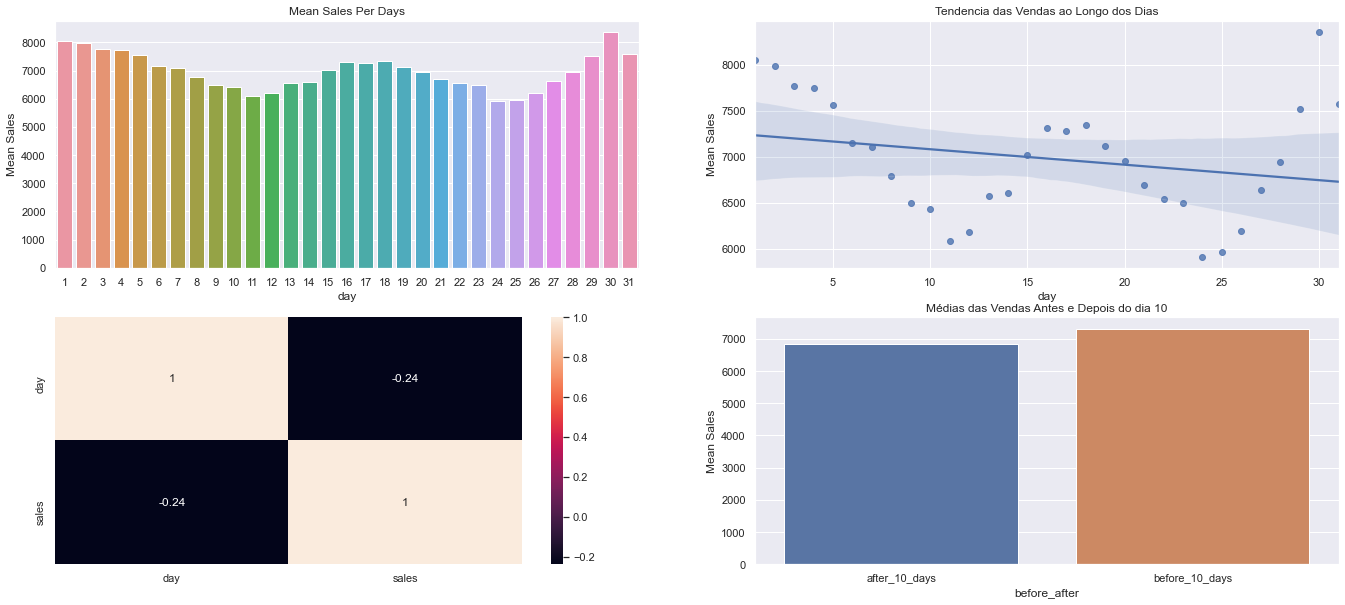

In [141]:
# Exibe a média das vendas ao longo dos dias, o gráfico de tendencias,
# o gráfico da força da correlação e o gráfico da média das vendas antes
# e depois do dia 10.
aux30 = df4[['day', 'sales']].groupby('day').mean().reset_index()

plt.figure(figsize=(23,10))

plt.subplot(2, 2, 1) # Duas linha e duas colunas na primeira posição.
sns.barplot(x='day', y='sales', data=aux30).set_title('Mean Sales Per Days');
plt.ylabel('Mean Sales');  # Configura o texto da coluna Y.

plt.subplot(2, 2, 2) # Duas linha e duas colunas na segunda posição.
sns.regplot(x='day', y='sales', data=aux30).set_title('Tendencia das Vendas ao Longo dos Dias');
plt.ylabel('Mean Sales');  # Configura o texto da coluna Y.

plt.subplot(2, 2, 3) # Duas linha e duas colunas na terceira posição.
sns.heatmap(aux30.corr(method='pearson'), annot=True);

# Cria uma coluna chamada before_after onde armazena o valor before_10_days
# se o dia for menor ou igual à 10 e armazena o valor after_10_days se o dia
# for maior que 10.
aux30['before_after'] = aux30['day'].apply(lambda x: 'before_10_days' if x <= 10 else 'after_10_days')

# Armazena a média das vendas por tipo do atributo before_after. 
aux31 = aux30[['before_after', 'sales']].groupby('before_after').mean().reset_index()

plt.subplot(2, 2, 4) # Duas linha e duas colunas na quarta posição.
sns.barplot(x='before_after', y='sales', data=aux31).set_title('Médias das Vendas Antes e Depois do dia 10');
plt.ylabel('Mean Sales');  # Configura o texto da coluna Y.

In [142]:
aux30.head(31)

,day,sales,before_after
0,1,8054.505835,before_10_days
1,2,7987.998803,before_10_days
2,3,7765.916826,before_10_days
3,4,7746.632622,before_10_days
4,5,7556.054806,before_10_days
5,6,7149.914351,before_10_days
6,7,7101.614663,before_10_days
7,8,6785.606424,before_10_days
8,9,6499.517013,before_10_days
9,10,6429.867986,before_10_days


### **H11.** Lojas deveriam vender menos aos finais de semana.
**FALSA** Lojas vendem MENOS aos Sábados, porém vendem MAIS aos Domingos.

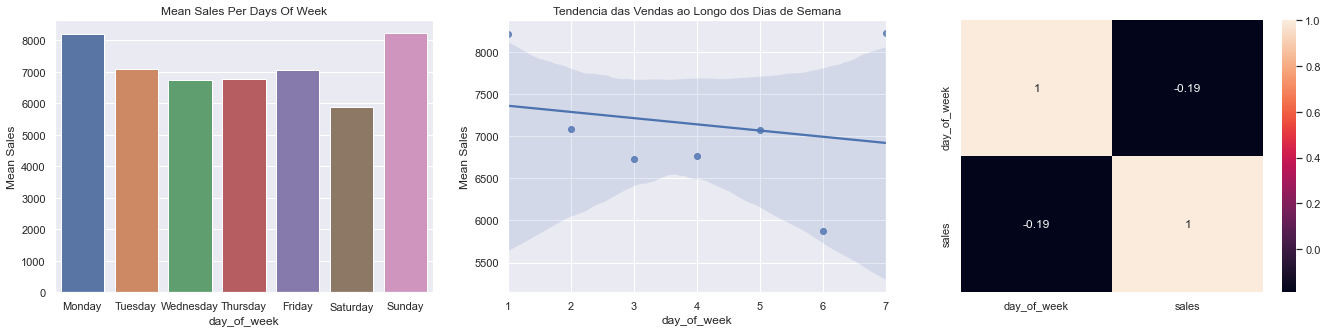

In [143]:
# Exibe a média das vendas ao longo dos dias da semana, o gráfico de tendencias e o gráfico da força da correlação.
aux32 = df4[['day_of_week', 'sales']].groupby('day_of_week').mean().reset_index()

aux33 = aux32.copy()

# Altera os valores do atributo day_of_week para o nome dos dias da semana.
aux33['day_of_week'] = aux33['day_of_week'].apply(lambda x: 'Monday' if x == 1 else 'Tuesday' if x == 2 else 'Wednesday' if x == 3 else 'Thursday' if x == 4 else 'Friday' if x == 5 else 'Saturday' if x == 6 else 'Sunday')

plt.figure(figsize=(23,5))

plt.subplot(1, 3, 1) # Uma linha e três colunas na primeira posição.
sns.barplot(x='day_of_week', y='sales', data=aux33).set_title('Mean Sales Per Days Of Week');
plt.ylabel('Mean Sales');  # Configura o texto da coluna Y.

plt.subplot(1, 3, 2) # Uma linha e três colunas na segunda posição.
sns.regplot(x='day_of_week', y='sales', data=aux32).set_title('Tendencia das Vendas ao Longo dos Dias de Semana');
plt.ylabel('Mean Sales');  # Configura o texto da coluna Y.

plt.subplot(1, 3, 3) # Uma linha e três colunas na terceira posição.
sns.heatmap(aux32.corr(method='pearson'), annot=True);

In [144]:
# No gráfico acima, a segunda-feira é representado pelo valor 1 no atributo day_of_week.
# Portanto, os finais de semana são representados pelos valores 6 e 7.
# Nos gráficos acima, a média das vendas aos Sábados é baixa, porém a média das vendas
# aos Domingos é alta.

### **H12.** Lojas deveriam vender menos durante os feriados escolares.
**FALSA** Lojas vendem MAIS durante os feriados escolares.

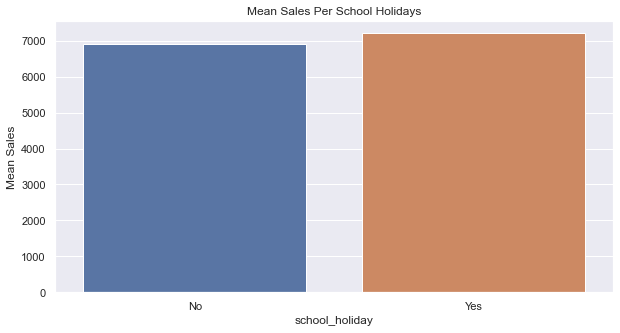

In [145]:
# Armazena a média das vendas por tipo de feriado escolar.
aux34 = df4[['school_holiday', 'sales']].groupby('school_holiday').mean().reset_index()

# Altera os valores do atributo school_holiday para o Yes ou No.
aux34['school_holiday'] = aux34['school_holiday'].apply(lambda x: 'No' if x == 0 else 'Yes')

sns.barplot(x='school_holiday', y='sales', data=aux34).set_title('Mean Sales Per School Holidays');
plt.ylabel('Mean Sales');  # Configura o texto da coluna Y.

In [146]:
# O gráfico acima mostra que a média das vendas durante os feriados escolares é um
# pouco superior que os dias que não são feriados escolares.

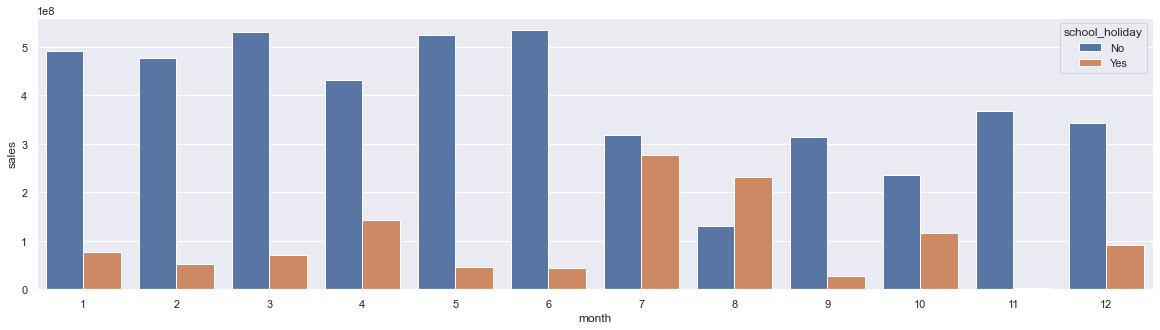

In [147]:
# O gráfico abaixo exibe a soma das vendas para os dias que são feriados escolares
# e para os dias que não são feriados escolares ao longo do ano.
# Podemos notar que os meses 7 e 8 férias devido ao aumento no volume de vendas
# nos dias que são feriados escolares.

# Armazena a soma das vendas por mês e por tipo de feriado escolar.
aux35 = df4[['month', 'school_holiday', 'sales']].groupby(['month', 'school_holiday']).sum().reset_index()

# Altera os valores do atributo school_holiday para o Yes ou No.
aux35['school_holiday'] = aux35['school_holiday'].apply(lambda x: 'No' if x == 0 else 'Yes')

plt.figure(figsize=(20,5))

sns.barplot(x='month', y='sales', hue='school_holiday', data=aux35);

## 4.3. Análise Multivariada

### 4.3.1. Numerical Attributes

In [148]:
# Exibe as variáveis numéricas.
num_attributes.head()

,store,day_of_week,sales,customers,open,promo,school_holiday,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo
0,1,5,5263,555,1,1,1,1270.0,9,2008,0,31,2015,0
1,2,5,6064,625,1,1,1,570.0,11,2007,1,13,2010,1
2,3,5,8314,821,1,1,1,14130.0,12,2006,1,14,2011,1
3,4,5,13995,1498,1,1,1,620.0,9,2009,0,31,2015,0
4,5,5,4822,559,1,1,1,29910.0,4,2015,0,31,2015,0


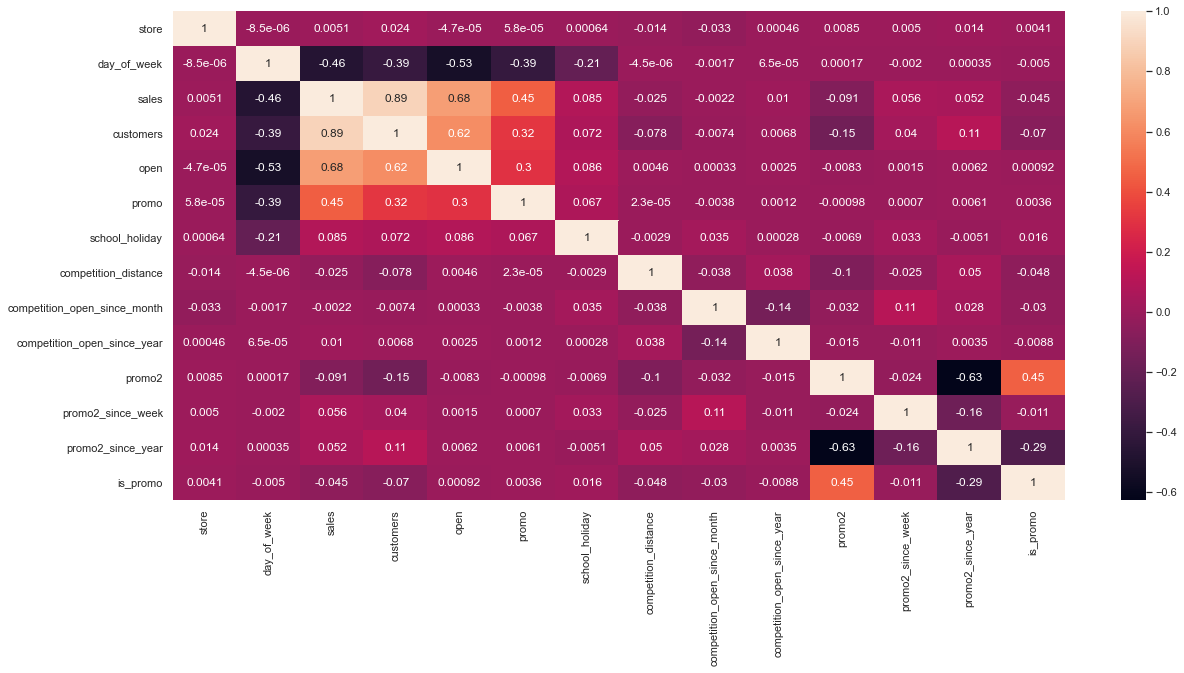

In [149]:
# Exibe a força da correlação entre as variáveis numéricas.
correlation = num_attributes.corr(method='pearson')
plt.figure(figsize=(20,9))
sns.heatmap(correlation, annot=True);

In [150]:
# Na matriz acima, quanto mais perto da cor preta, maior é a correlação negativa e quanto mais perto da cor branca, maior é a correlação positiva.
# Este matriz é simétrica, isto é, se divirmos a matriz com uma diagonal, a parte de baixo é o espelho da parte de cima. 
# A correlação entre a mesma variável possui o valor 1 e está representada na diagonal da matriz.
# Quando observamos a correlação da variável sales, verificamos uma correlação forte com a variável day_of_week de -0,46.

# Temos uma correlação forte entre as variáveis sales e customers de 0,89, porém não conseguiremos utilizar a variável customer, pois como este é
# um problema de previsão, necesssitamos ter a quantidade de customers que estarão na loja nas próximas seis semanas, porém não possuímos esta
# previsão. A não ser que façamos outro projeto separa de previsão de customers ao longo das próximas seis semanas, e este resultado, incorporamos
# neste projeto. Este é um dos problemas da previsão quando sabemos que existem variáveis altamente correlacionadas, porém não podemos utilizá-las
# pois não temos o seu valor no momento da predição.

# Correlações fortes: sales x day_of_week, open x day_of_week, promo x day_of_week, school_holiday x day_of_week, promo2_since_year x promo2,
# Correlações fortes: is_promo x promo2, is_promo x promo2_since_year, sales x open, sales x promo, open x promo.

### 4.3.1. Categorical Attributes

In [151]:
# Exibe as variáveis categóricas.
cat_attributes.head()

,state_holiday,store_type,assortment,promo_interval,month_map
0,0,c,a,0,Jul
1,0,a,a,"Jan,Apr,Jul,Oct",Jul
2,0,a,a,"Jan,Apr,Jul,Oct",Jul
3,0,c,c,0,Jul
4,0,a,a,0,Jul


In [152]:
# As variáveis categóricas acima estão desatualizados. Portanto, 
# são criados novas variáveis categóricas, conforme abaixo:
# Seleciona apenas as variáveis do tipo object.
cat_attributes_v2 = df4.select_dtypes(include='object')
cat_attributes_v2.head()

,state_holiday,store_type,assortment,year_week
0,regular_day,c,basic,2015-30
1,regular_day,a,basic,2015-30
2,regular_day,a,basic,2015-30
3,regular_day,c,extended,2015-30
4,regular_day,a,basic,2015-30


In [153]:
# Para determinar o Confusion Matrix / tabela de contingência, utilizamos a fórmula
# pd.crosstab abaixo que determina as possíveis combinações entre as variáveis
# categóricas informadas, contando o número de linhas para cada uma das combinações:
pd.crosstab(cat_attributes_v2['state_holiday'], cat_attributes_v2['store_type'])

store_type,a,b,c,d
state_holiday,,,,
christmas,4,66,0,1
easter_holiday,36,100,0,9
public_holiday,236,285,65,108
regular_day,456766,15109,112903,258650


In [154]:
# Necessitamos transformar este resultado em um matriz, incluíndo o parâmetro .values
# conforme abaixo:
pd.crosstab(cat_attributes_v2['state_holiday'], cat_attributes_v2['store_type']).values

array([[     4,     66,      0,      1],
       [    36,    100,      0,      9],
       [   236,    285,     65,    108],
       [456766,  15109, 112903, 258650]], dtype=int64)

In [155]:
# Armazena a Confusion Matrix / tabela de contingência na variável cm:
cm = pd.crosstab(cat_attributes_v2['state_holiday'], cat_attributes_v2['store_type']).values

In [156]:
# Determina o coeficiente chi2, através do método qui quadrado de Pearson:
chi2 = stats.chi2_contingency(cm)  # cm = Confunsion Matrix

In [157]:
# Chi2 retorna quatro resultados:
# 12792.15: é o resultado do teste de qui quadrado baseado no Pearson.
# 0.0: p valor.
# 9: número de grau de liberdade.
# Tabela de frequencia
chi2

(12792.159524019908,
 0.0,
 9,
 array([[3.84324548e+01, 1.30843335e+00, 9.49942795e+00, 2.17596839e+01],
        [7.84888161e+01, 2.67215262e+00, 1.94002402e+01, 4.44387911e+01],
        [3.75663713e+02, 1.27894753e+01, 9.28535634e+01, 2.12693248e+02],
        [4.56549415e+05, 1.55432299e+04, 1.12846247e+05, 2.58489108e+05]]))

In [158]:
# Coeficiente chi2, através do método qui quadrado de Pearson:
# Necessitamos apenas do valor do resultado do teste de qui quadrado de Pearson.
# Neste caso, seleciona-se apenas o primeiro valor, conforme exemplo abaixo:
chi2 = stats.chi2_contingency(cm)[0]  # cm=Confunsion Matrix, [0]=primeiro valor.

# n é a soma de todos os valores da Confusion Matrix / tabela de contingência,
# conforme calculado abaixo:
n = cm.sum()

# r e k são as linha e colunas da confusion Matrix / tabela de contingência,
# conforme determinado abaixo:
r, k = cm.shape

In [159]:
# Calcula o método V de Cramer:
v = np.sqrt((chi2/n) / (min(k-1, r-1)))

In [160]:
# Exibe o valor de V de Cramer.
# O resultado de V de Cramer varia de zero até um, onde quanto mais perto do zero,
# menor é a correlação e quanto mais perto de um, maior é a correlação.
v

0.07106457093267678

In [161]:
# Cria-se uma função chamada cramer_v, realizando as correções de Bias Correction
# na fórmula, conforme descrito no link: https://en.wikipedia.org/wiki/Cram%C3%A9r%27s_V.

def cramer_v(x, y):
    cm = pd.crosstab(x, y).values
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = stats.chi2_contingency(cm)[0] 
    chi2corr = max(0, chi2-(((k-1)*(r-1))/(n-1)))
    
    kcorr = k - (k - 1)**2 / (n - 1)
    rcorr = r - (r - 1)**2 / (n - 1)
    
    return np.sqrt((chi2corr/n) / (min(kcorr-1, rcorr-1)))

In [162]:
# Executa a função cramer_v para as variáveis state_holiday e store_type:
cramer_v(cat_attributes_v2['state_holiday'], cat_attributes_v2['store_type'])

0.07106469715258833

In [163]:
# Cria-se as correlações entre todos os atributos categóricos:
a1 = cramer_v(cat_attributes_v2['state_holiday'], cat_attributes_v2['state_holiday'])
a2 = cramer_v(cat_attributes_v2['state_holiday'], cat_attributes_v2['store_type'])
a3 = cramer_v(cat_attributes_v2['state_holiday'], cat_attributes_v2['assortment'])

a4 = cramer_v(cat_attributes_v2['store_type'], cat_attributes_v2['state_holiday'])
a5 = cramer_v(cat_attributes_v2['store_type'], cat_attributes_v2['store_type'])
a6 = cramer_v(cat_attributes_v2['store_type'], cat_attributes_v2['assortment'])

a7 = cramer_v(cat_attributes_v2['assortment'], cat_attributes_v2['state_holiday'])
a8 = cramer_v(cat_attributes_v2['assortment'], cat_attributes_v2['store_type'])
a9 = cramer_v(cat_attributes_v2['assortment'], cat_attributes_v2['assortment'])

# Cria um dataframe com o resultados das variáveis acima:
d = pd.DataFrame({'state_holiday': [a1, a2, a3],
             'store_type': [a4, a5, a6],
             'assortment': [ a7, a8, a9]})

# Define que o nome das linhas terão o nome das colunas:
d = d.set_index(d.columns)

In [164]:
d

,state_holiday,store_type,assortment
state_holiday,1.000002,0.071065,0.067546
store_type,0.071065,1.000002,0.538457
assortment,0.067546,0.538457,1.000001


<AxesSubplot:>

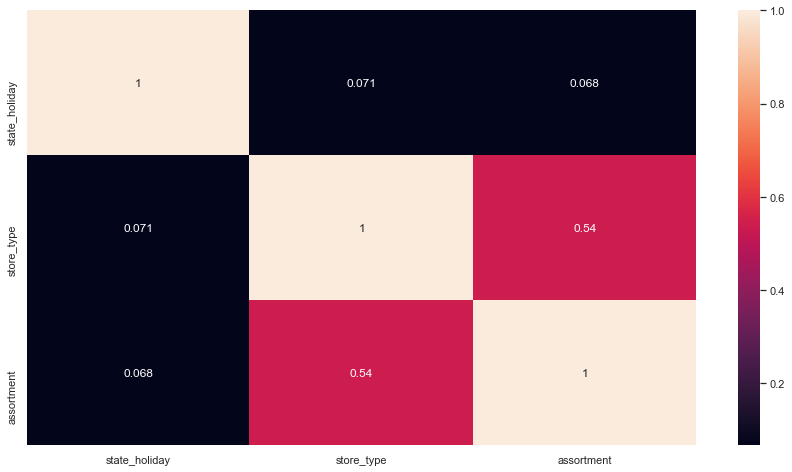

In [165]:
# Exibe o valor de V de Cramer para as variáveis categóricas.
# O resultado de V de Cramer varia de zero até um, onde quanto mais perto do zero,
# menor é a correlação e quanto mais perto de um, maior é a correlação.
plt.figure(figsize=(15,8))
sns.heatmap(d, annot=True)

# 5.0. PASSO 05 - PREPARAÇÃO DOS DADOS

In [166]:
df5 = df4.copy()

## 5.1. Normalização

In [167]:
# A primeira tarefa que devemos executar é avaliar quais variáveis possuem característica de distribuição normal.
# Verificamos as suas distribuições na subseção 4.1.2 Numerical Variable.
# Notamos que não existe nenhuma variável com característica de distribuição normal, portanto não iremos executar
# a normalização para nenhuma das variáveis do nosso conjunto de dados.

## 5.2. Rescaling

In [168]:
# Seleciona apenas as variáveis numéricas.
aux36 = df5.select_dtypes(include = ['int64', 'float64'])

In [169]:
aux36.head()

,store,day_of_week,sales,promo,school_holiday,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,competition_time_month,promo_time_week
0,1,5,5263,1,1,1270.0,9,2008,0,31,2015,0,2015,7,31,84,0
1,2,5,6064,1,1,570.0,11,2007,1,13,2010,1,2015,7,31,94,279
2,3,5,8314,1,1,14130.0,12,2006,1,14,2011,1,2015,7,31,105,226
3,4,5,13995,1,1,620.0,9,2009,0,31,2015,0,2015,7,31,71,0
4,5,5,4822,1,1,29910.0,4,2015,0,31,2015,0,2015,7,31,4,0


In [170]:
# Para definirmos se iremos utilizar a técnica Min-Max Scaler ou Robust Scaler temos que verificar se a variável possui Outliers relevantes.
# Portanto, iremos plotar o gráfico de boxplot para verificar se as variáveis possuem Outliers relevantes.

<AxesSubplot:xlabel='competition_distance'>

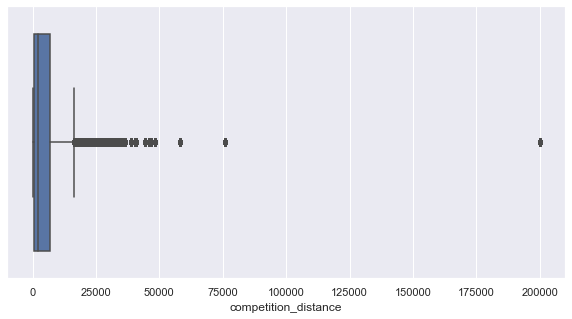

In [171]:
# competition_distance.
# No gráfico abaixo verificarmos que a variável competition_distance possui Outliers relevantes, pois substituímos os valores faltantes NaN pelo valor 20.000.
# Portanto, iremos utilizar a técnica de Rescaling RobustScaler.
sns.boxplot(df5['competition_distance'])

<AxesSubplot:xlabel='competition_time_month'>

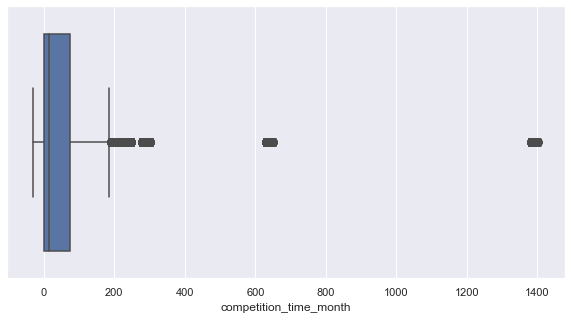

In [172]:
# competition_time_month.
# No gráfico abaixo verificarmos que a variável competition_time_month possui Outliers relevantes.
# Portanto, iremos utilizar a técnica de Rescaling RobustScaler.
sns.boxplot(df5['competition_time_month'])

<AxesSubplot:xlabel='promo_time_week'>

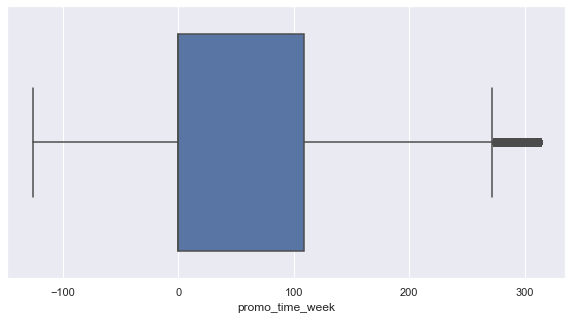

In [173]:
# promo_time_week.
# No gráfico abaixo verificarmos que a variável promo_time_week não possui Outliers relevantes.
# Portanto, iremos utilizar a técnica de Rescaling Min-Max Scaler.
sns.boxplot(df5['promo_time_week'])

In [174]:
# Rescaling das variáveis.
# Cria uma isntância rs para a classe RobustScaler.
rs = RobustScaler()

# Cria uma isntância mms para a classe MinMaxScaler.
mms = MinMaxScaler()


# competition distance
# Utilizamos o método fit_transform da classe RobustScaler. O método fit_transform encontra os parâmetros da fórmula RobustScaler
# que são os quartis 1 e 3 e aplica a fórmula nos dados.
# No comando abaixo iremos sobreescrever os valores de competition_distance aplicando a formula do RobustScaler.
df5['competition_distance'] = rs.fit_transform(df5[['competition_distance']].values)

# competition time month
# Utilizamos o método fit_transform da classe RobustScaler. O método fit_transform encontra os parâmetros da fórmula RobustScaler
# que são os quartis 1 e 3 e aplica a fórmula nos dados.
# No comando abaixo iremos sobreescrever os valores de competition_time_month aplicando a formula do RobustScaler.
df5['competition_time_month'] = rs.fit_transform(df5[['competition_time_month']].values)


# promo time week
# Utilizamos o método fit_transform da classe MinMaxScaler. O método fit_transform encontra os parâmetros da fórmula MinMaxScaler
# que são os valores de média, máximo e mínimo e aplica a fórmula nos dados.
# No comando abaixo iremos sobreescrever os valores de promo_time_week aplicando a formula do MinMaxScaler.
df5['promo_time_week'] = mms.fit_transform(df5[['promo_time_week']].values)

# year
# Utilizamos o método fit_transform da classe MinMaxScaler. O método fit_transform encontra os parâmetros da fórmula MinMaxScaler
# que são os valores de média, máximo e mínimo e aplica a fórmula nos dados.
# No comando abaixo iremos sobreescrever os valores de year aplicando a formula do MinMaxScaler.
df5['year'] = mms.fit_transform(df5[['year']].values)

<AxesSubplot:xlabel='competition_distance', ylabel='Density'>

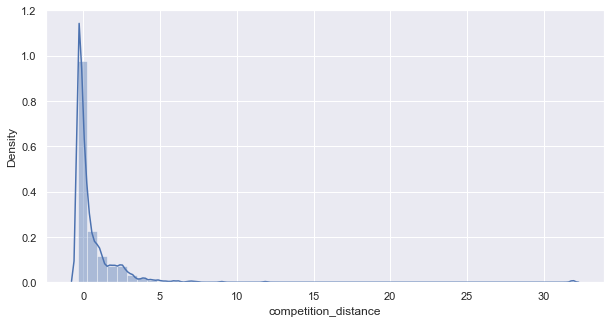

In [175]:
# Exibe a nova distribuição dos dados:
sns.distplot(df5['competition_distance'])
# Podemos observar que os valores agora vão de zero até 1, mantendo o formato da distribuição original.

<AxesSubplot:xlabel='promo_time_week', ylabel='Density'>

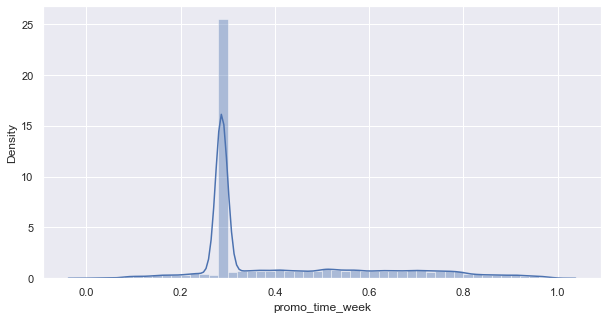

In [176]:
sns.distplot(df5['promo_time_week'])

<AxesSubplot:xlabel='year', ylabel='Density'>

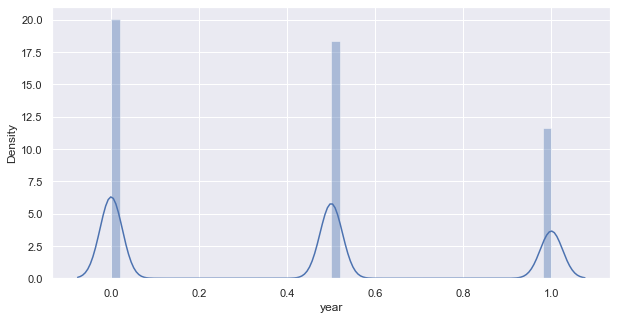

In [177]:
sns.distplot(df5['year'])

## 5.3. Transformação

### 5.3.1 Encoding

In [178]:
# Mostra os valores originais das variáveis para visualizarmos o que ocorreu
# antes de depois do Encoding.
df5.head()

,store,day_of_week,date,sales,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,...,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,1,regular_day,1,c,basic,-0.170968,...,0,1.0,7,31,31,2015-30,2008-09-01,0.918919,2015-07-27,0.287016
1,2,5,2015-07-31,6064,1,regular_day,1,a,basic,-0.283871,...,1,1.0,7,31,31,2015-30,2007-11-01,1.054054,2010-03-22,0.922551
2,3,5,2015-07-31,8314,1,regular_day,1,a,basic,1.903226,...,1,1.0,7,31,31,2015-30,2006-12-01,1.202703,2011-03-28,0.801822
3,4,5,2015-07-31,13995,1,regular_day,1,c,extended,-0.275806,...,0,1.0,7,31,31,2015-30,2009-09-01,0.743243,2015-07-27,0.287016
4,5,5,2015-07-31,4822,1,regular_day,1,a,basic,4.448387,...,0,1.0,7,31,31,2015-30,2015-04-01,-0.162162,2015-07-27,0.287016


In [179]:
# Variável categóricas

# state_holiday - One Hot Encoding
# Possui a idéia de estado, por exemplo, no feriado, vivemos um estado de dias regulares e depois entramos em um estado de feriado. 
# Estes dois estados tem comportamento muito diferentes, as pessoas agem de um jeito em dias normais e agem de outra jeito em feriados.
# Por isso, iremos aplicar o One Hot Encoding.
# O comando abaixo utiliza o método chamado get_dummies da classe pandas para aplicar o One Hot Encoding.
# O parâmetro prefix abaixo, determina um prefixo utilizado no nome das novas colunas. Neste caso, 
# o prefixo será "state_holiday". A coluna original state_holiday será excluída e serão criadas novas colunas,
# cada uma para um nível (valor) da variável state_holiday.
df5 = pd. get_dummies (df5, prefix=['state_holiday'], columns=['state_holiday'])

In [180]:
# Abaixo verificamos que a coluna original state_holiday foi excluída e foram 
# cridas as novas colunas state_holiday_christmas, state_holiday_easter_holiday, state_holiday_public_holiday
# e state_holiday_regular_day.
df5.head()

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,...,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week,state_holiday_christmas,state_holiday_easter_holiday,state_holiday_public_holiday,state_holiday_regular_day
0,1,5,2015-07-31,5263,1,1,c,basic,-0.170968,9,...,31,2015-30,2008-09-01,0.918919,2015-07-27,0.287016,0,0,0,1
1,2,5,2015-07-31,6064,1,1,a,basic,-0.283871,11,...,31,2015-30,2007-11-01,1.054054,2010-03-22,0.922551,0,0,0,1
2,3,5,2015-07-31,8314,1,1,a,basic,1.903226,12,...,31,2015-30,2006-12-01,1.202703,2011-03-28,0.801822,0,0,0,1
3,4,5,2015-07-31,13995,1,1,c,extended,-0.275806,9,...,31,2015-30,2009-09-01,0.743243,2015-07-27,0.287016,0,0,0,1
4,5,5,2015-07-31,4822,1,1,a,basic,4.448387,4,...,31,2015-30,2015-04-01,-0.162162,2015-07-27,0.287016,0,0,0,1


In [181]:
# store_type - Label Encoding
# Não possui uma origem nos valores (níveis) desta variável, isto é, não sabemos se a é maior que b ou c.
# Então iremos substituir as letras por número utilizando label Encoding.
# Para utilizar o Label Encoding utilizamos a classe LabelEncoder do pacote sklearn:

# Cria uma isntância da classe LabelEncoder:
le = LabelEncoder()

# O método fit_transform calcula os parâmetros e já aplica a formula nos dados:
df5['store_type'] = le.fit_transform(df5['store_type'])

In [182]:
# Abaixo verificamos que os valores da coluna store_type foram substituídas de a -> 0,
# b -> 1 e c -> 2.
df5.head()

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,...,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week,state_holiday_christmas,state_holiday_easter_holiday,state_holiday_public_holiday,state_holiday_regular_day
0,1,5,2015-07-31,5263,1,1,2,basic,-0.170968,9,...,31,2015-30,2008-09-01,0.918919,2015-07-27,0.287016,0,0,0,1
1,2,5,2015-07-31,6064,1,1,0,basic,-0.283871,11,...,31,2015-30,2007-11-01,1.054054,2010-03-22,0.922551,0,0,0,1
2,3,5,2015-07-31,8314,1,1,0,basic,1.903226,12,...,31,2015-30,2006-12-01,1.202703,2011-03-28,0.801822,0,0,0,1
3,4,5,2015-07-31,13995,1,1,2,extended,-0.275806,9,...,31,2015-30,2009-09-01,0.743243,2015-07-27,0.287016,0,0,0,1
4,5,5,2015-07-31,4822,1,1,0,basic,4.448387,4,...,31,2015-30,2015-04-01,-0.162162,2015-07-27,0.287016,0,0,0,1


In [183]:
# assortment - Ordinal Encoding
# A variável assoritment possui uma ordem, onde a loja extended é maior que a loja extra
# que por sua vez é maior que a loja basic.
# Entáo neste caso, aplicamos o Ordinal Encoding.

# Criamos um dicionário assortment_dict para especificar os valores que serão aplicado:
assortment_dict = { 'basic': 1, 'extra': 2, 'extended': 3}

# Utilizamos a função map para substituir os valors originais pelos valores do dicionário assortiment_dict:
df5['assortment'] = df5['assortment'].map(assortment_dict)

In [184]:
df5.head()

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,...,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week,state_holiday_christmas,state_holiday_easter_holiday,state_holiday_public_holiday,state_holiday_regular_day
0,1,5,2015-07-31,5263,1,1,2,1,-0.170968,9,...,31,2015-30,2008-09-01,0.918919,2015-07-27,0.287016,0,0,0,1
1,2,5,2015-07-31,6064,1,1,0,1,-0.283871,11,...,31,2015-30,2007-11-01,1.054054,2010-03-22,0.922551,0,0,0,1
2,3,5,2015-07-31,8314,1,1,0,1,1.903226,12,...,31,2015-30,2006-12-01,1.202703,2011-03-28,0.801822,0,0,0,1
3,4,5,2015-07-31,13995,1,1,2,3,-0.275806,9,...,31,2015-30,2009-09-01,0.743243,2015-07-27,0.287016,0,0,0,1
4,5,5,2015-07-31,4822,1,1,0,1,4.448387,4,...,31,2015-30,2015-04-01,-0.162162,2015-07-27,0.287016,0,0,0,1


### 5.3.2 Response Variable Transformation

In [185]:
# Executa a transformação logarítmica na variável resposta sales.
# Utilizar o método log1p da classe numpy:
df5['sales'] = np.log1p(df5['sales'])

<AxesSubplot:xlabel='sales', ylabel='Density'>

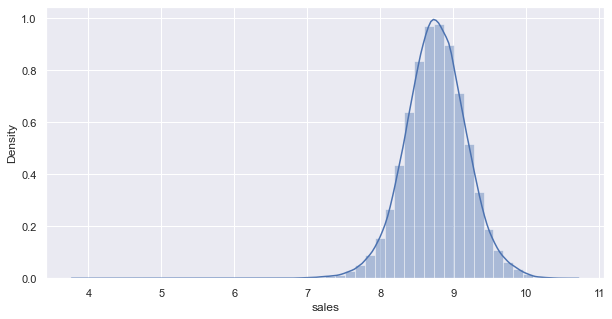

In [186]:
# Exibe o gráfico de distribuição da variável sales após a transformação logarítmica.
sns.distplot(df5['sales'])

### 5.3.3 Nature Transformation

In [187]:
# Variáveis que possuem natureza cíclica:
# Iremos calcular os valores de seno e coseno em um cículo trigonométrico para cada variável.

# month
# Cria uma nova variável month_sin armazenando o valor de seno da variável month utilizando a fórmula:
# seno (x * (2x pi/12)) onde 12 é a quantidade de meses no ano.
df5['month_sin'] = df5['month'].apply(lambda x: np.sin(x* (2 * np.pi/12)))
# Cria uma nova variável month_cos armazenando o valor de coseno da variável month utilizando a fórmula:
# coseno (x * (2x pi/12)) onde 12 é a quantidade de meses no ano.
df5['month_cos'] = df5['month'].apply(lambda x: np.cos(x* (2 * np.pi/12)))


# day
# Cria uma nova variável day_sin armazenando o valor de seno da variável day utilizando a fórmula:
# seno (x * (2x pi/30)) onde 30 é a quantidade de dias no mês.
df5['day_sin'] = df5['day'].apply(lambda x: np.sin(x* (2 * np.pi/30)))
# Cria uma nova variável day_cos armazenando o valor de coseno da variável day utilizando a fórmula:
# coseno (x * (2x pi/30)) onde 30 é a quantidade de dias no mês.
df5['day_cos'] = df5['day'].apply(lambda x: np.cos(x* (2 * np.pi/30)))


# week of year
# Cria uma nova variável week_of_year_sin armazenando o valor de seno da variável week_of_year utilizando a fórmula:
# seno (x * (2x pi/52)) onde 52 é a quantidade de semanas no ano.
df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin(x* (2 * np.pi/52)))
# Cria uma nova variável week_of_year_cos armazenando o valor de coseno da variável week_of_year utilizando a fórmula:
# coseno (x * (2x pi/52)) onde 52 é a quantidade de semanas no ano.
df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos(x* (2 * np.pi/52)))


# day of week
# Cria uma nova variável day_of_week_sin armazenando o valor de seno da variável day_of_week utilizando a fórmula:
# seno (x * (2x pi/7)) onde 7 é a quantidade de dias na semana.
df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin(x* (2 * np.pi/7)))
# Cria uma nova variável day_of_week_cos armazenando o valor de coseno da variável day_of_week utilizando a fórmula:
# coseno (x * (2x pi/7)) onde 7 é a quantidade de dias na semana.
df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos(x* (2 * np.pi/7)))

In [188]:
# Exibe as variáveis do dataset.
df5.head()

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,...,state_holiday_public_holiday,state_holiday_regular_day,month_sin,month_cos,day_sin,day_cos,week_of_year_sin,week_of_year_cos,day_of_week_sin,day_of_week_cos
0,1,5,2015-07-31,8.568646,1,1,2,1,-0.170968,9,...,0,1,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,-0.974928,-0.222521
1,2,5,2015-07-31,8.710290,1,1,0,1,-0.283871,11,...,0,1,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,-0.974928,-0.222521
2,3,5,2015-07-31,9.025816,1,1,0,1,1.903226,12,...,0,1,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,-0.974928,-0.222521
3,4,5,2015-07-31,9.546527,1,1,2,3,-0.275806,9,...,0,1,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,-0.974928,-0.222521
4,5,5,2015-07-31,8.481151,1,1,0,1,4.448387,4,...,0,1,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,-0.974928,-0.222521


# 6.0. PASSO 06 - FEATURE SELECTION

In [189]:
df6 = df5.copy()

## 6.1. Split dataframe into training and test dataset

In [190]:
# Apaga as variáveis originais após a criação de suas variáveis derivadas na etapa 5.3.3. Nature Transformation e
# na etapa de 2.4 Feature Engineering.
# Cria uma lista com as colunas que serão apagadas:
cols_drop = ['week_of_year', 'day_of_week', 'day', 'month', 'promo_since', 'competition_since', 'year_week']

# Apaga do dataframe as colunas contidas na lista cols_drop:
df6 = df6.drop(cols_drop, axis=1)

In [191]:
# Divide o dataset em treino e teste.
# Como este projeto trata de um problema temporal, isto é, que leva em consideração o tempo,
# não se pode selecionar aleatoriamente quais linhas pertencem ao treino e quais linhas pertencem ao teste.
# Se selecionar as linhas de maneira aleatória, dados passados e dados futuros estarão no conjunto de teste e
# o modelo saberá o comportamento dos dados futuros e vai acertar quase que 100%, o que é chamado de overfitting.
# Como as vendas são realizadas em relação ao tempo, isto é, todo dia ocorre vendas por loja, e deseja-se realizar uma 
# previsão de vendas para as próximas seis semanas, seleciona-se as últimas seis semanas para o conjunto de teste.
# Para o conjunto de treino seleciona-se desde o primeiro dia de venda até a data de início do conjunto de teste.

In [192]:
# Exibe a primeira data de venda, exibindo a menor data por loja:
df6[['store', 'date']].groupby('store').min().reset_index()

,store,date
0,1,2013-01-02
1,2,2013-01-02
2,3,2013-01-02
3,4,2013-01-02
4,5,2013-01-02
...,...,...
1110,1111,2013-01-02
1111,1112,2013-01-02
1112,1113,2013-01-02
1113,1114,2013-01-02


In [193]:
# Exibe a última data de venda, exibindo a maior data por loja:
df6[['store', 'date']].groupby('store').max().reset_index()

,store,date
0,1,2015-07-31
1,2,2015-07-31
2,3,2015-07-31
3,4,2015-07-31
4,5,2015-07-31
...,...,...
1110,1111,2015-07-31
1111,1112,2015-07-31
1112,1113,2015-07-31
1113,1114,2015-07-31


In [194]:
# Define a data de início do conjunto de teste, subtraindo seis semanas da data máxima de venda.
# No exemplo abaixo utiliza-se o comando datetime.timedelta para subtrair 6 semanas da data.
# Utiliza o parâmetro days multiplicando 7 dias vezes 6, para totalizar 6 semanas.
df6[['store', 'date']].groupby('store').max().reset_index()['date'][0] - datetime.timedelta(days=6*7)

Timestamp('2015-06-19 00:00:00')

In [195]:
# training dataset
# Cria o conjunto das variáveis de treino, considerando deste a data inicial até 6 semanas antes 
# da data máxima:
X_train = df6[df6['date'] < '2015-06-19']
# Cria o conjunto da variável resposta para o treino, selecionando apenas a coluna 'sales' do 
# dataset X_train:
y_train = X_train['sales']


# test dataset
# Cria o conjunto das variáveis de teste, considerando 6 semanas antes da data máxima até a 
# data máxima:
X_test = df6[df6['date'] >= '2015-06-19']
# Cria o conjunto da variável resposta para o teste, selecionando apenas a coluna 'sales' do 
# dataset X_test:
y_test = X_test['sales']

print('Training Min Date: {}'.format(X_train['date'].min()))
print('Training Max Date: {}'.format(X_train['date'].max()))
print('\nTest Min Date: {}'.format(X_test['date'].min()))  # Utiliza \n para pular uma linha antes de exibir.
print('Test Min Date: {}'.format(X_test['date'].max()))

Training Min Date: 2013-01-01 00:00:00
Training Max Date: 2015-06-18 00:00:00

Test Min Date: 2015-06-19 00:00:00
Test Min Date: 2015-07-31 00:00:00


## 6.2. Boruta as Feature Selector

In [196]:
# training and test dataset for Boruta
# Exclui as colunas 'date' e 'sales' do dataset de treino, pois estas colunas serão utilizadas
# apenas no conjunto de teste.
# Utiliza o parâmetro .values para retornar apenas os valores (vetor do numpy).
#X_train_n = X_train.drop(['date', 'sales'], axis = 1).values

# o parâmetro values.ravel do numpy é utilizado para retornar um vetor de dimensão 1.
#y_train_n = y_train.values.ravel()



# define RandomForestRegressor
# cria uma instância da classe RandomForestRegression
#rf = RandomForestRegressor(n_jobs=-1)  # O parâmetro n_jobs= -1 utiliza todos os cores da CPU para criar as árvores em paralelo.


# define boruta
# Para utilizar o Boruta utiliza-se a classe Borutapy.
# A classe BorutaPy possui alguns argumentos:
# -- rf = Random Forest. É a instância do algoritmo de Machine Learning escolhido para ser utilizado no Boruta.
# -- n_estimators='auto' = n_estimators: define o número de trees na floresta do Random Forest, onde
#    o valor 'auto' significa que o modelo define automaticamente a quantidade de árvores.
# -- verbose=2 = exibe o que está sendo executado.
# -- random_state = 42. Define um valor de aleatoriedade utilizado pelo Random Forest para selecionar as variáveis Shadow.
#                       Define a origem dos números aleatórios utilizado na escolha das variáveis para fazer
#                       a ramificação da árvore. Definindo um valor ele partirá da mesma origem aleatória.
# O comando fit define os dataset que serão utilizados no treino.
# Armazena o resultado na variável boruta:
#boruta = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=42).fit(X_train_n, y_train_n)

In [197]:
# Na saída acima o Boruta realizou 9 iterações. Por default o limite de iterações é 100.
# Confirmed: informa a quantidade de variáveis que o Boruta considerou como sendo relevantes para o modelo.
# Tentative: informa a quantidade de variáveis que o Boruta não conseguiu definir como relavantes ou não relevantes para o modelo.
# Rejected: informa a quantidade de variáveis que o Boruta considerou como sendo não relevantes para o modelo.

### 6.2.1. Best Features from Boruta

In [198]:
# O comando boruta.support_ retorna as variáveis relevantes selecionadas pelo Boruta.
# O parâmetro tolist() exporta para uma lista.
# Cria um vetor de números no atributo cols_selected:
#cols_selected = boruta.support_.tolist()


# best features
# Armazena na lista cols_selected_boruta o nome das colunas selecionadas como relevantes pelo Boruta.
# Cria um dataset X_train_fs excluindo as colunas 'date' e 'sales'.
#X_train_fs = X_train.drop(['date', 'sales'], axis=1)

# Armazena na lista cols_selected_boruta o nome das colunas relevantes. Utiliza-se o
# parâmetro iloc para selecionar as colunas de acordo com os índices contidos no vetor cols_selected.
#cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.to_list()


# not selected
# Armazena na lista cols_not_selected_boruta as colunas que não foram selecionados pelo Boruta.
# Utiliza-se o método setdiff1d da classe numpy para determinar quais colunas do datafram X_train_fs não estão 
# contidas na lista cols_selected_boruta.
#cols_not_selected_boruta = list(np.setdiff1d( X_train_fs.columns, cols_selected_boruta))

In [199]:
# Exibe as variáveis consideradas pelo Boruta como relevantes para o modelo.
#cols_selected_boruta

In [200]:
# Exibe as variáveis consideradas pelo Boruta como não relevantes para o modelo.
#cols_not_selected_boruta

In [201]:
# Devemos verificar na análise exploratória de dados se existe alguma(s) variável(eis) que verificamos como
# relevante que não foi/foram selecionado(s) pelo Boruta.
# Por exemplo, verificamos na etapa de análise exploratória de dados na hipótese #8 que as lojas vendem mais ao 
# longo dos anos. Porém, o Boruta não considerou a variável anos(year) como relevante.
# Cabe ao cientista de dados decidir se inclui ou não estas variáveis.
# Como sugestão, se temos duvida se utilizamos ou não alguma variável que o Boruta não considerou,
# no primeiro ciclo do CRIPS consideramos somente as variáveis sugeridas pelo Boruta e nos 
# próximos ciclos do CRISP, adicionamos variáveis e verificamos se a acurácia do modelo aumenta.

# O Boruta considerou a variável month_cos como relevante e a variável month_sin como não relevante.
# Neste caso, iremos incluir a variável month_sin como relevante.

# O Boruta considerou a variável week_of_year_cos como relevante e a variável week_of_year_sin como não relevante.
# Neste caso, iremos incluir a variável week_of_year_sin como relevante.

# Sugestão: Não siga cegamente as sugestões do algoritmo de seleção de variáveis. Use a intuição gerada pela
# análise exploratória de dados. Utilize a intuição e o feeling gerado pela análise exploratória de dados
# para questionar o que o algoritmo está nos informando.

### 6.3.1. Manual Feature Selection

In [202]:
# Cria uma lista com os nomes das colunas selecionados como relevantes pelo algoritmo Boruta.
# Realizamos esta criação para não ter que executar toda hora o algoritmo do Boruta que levou 
# cerca de 1 hora para encerrar.
# Foram acrescentadas as colunas month_sin e week_of_year_sin.
cols_selected_boruta = ['store',
                        'promo',
                        'store_type',
                        'assortment',
                        'competition_distance',
                        'competition_open_since_month',
                        'competition_open_since_year',
                        'promo2',
                        'promo2_since_week',
                        'promo2_since_year',
                        'competition_time_month',
                        'promo_time_week',
                        'month_sin',
                        'month_cos',
                        'day_sin',
                        'day_cos',
                        'week_of_year_sin',
                        'week_of_year_cos',
                        'day_of_week_sin',
                        'day_of_week_cos']

# columns to add
# Cria uma lista feat_to_add com o nome das colunas date e sales que devem ser acrescentando ao dataset.
feat_to_add = ['date', 'sales']

# final features
# Utiliza o comando extend para incluir o nome das colunas da lista feat_to_add na lista cols_selected_boruta:
#cols_selected_boruta.extend(feat_to_add) # Esta linha foi comentada pois não são utilizadas as colunas date e sales no primeiro momento do treino no passo 7 abaixo.
cols_selected_boruta

['store',
 'promo',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'competition_time_month',
 'promo_time_week',
 'month_sin',
 'month_cos',
 'day_sin',
 'day_cos',
 'week_of_year_sin',
 'week_of_year_cos',
 'day_of_week_sin',
 'day_of_week_cos']

# 7.0. PASSO 07 - MACHINE LEARNING MODELING

In [203]:
# Cria um dataset x_train à partir do dataset X_train, utilizando as colunas selecionadas previamente pelo Boruta.
x_train = X_train[cols_selected_boruta]

# Cria um dataset x_test à partir do dataset X_test, utilizando as colunas selecionadas previamente pelo Boruta.
x_test = X_test[cols_selected_boruta]

## 7.1. Average Model

In [204]:
# Average Model é a média de vendas de cada uma das lojas.

# Cria uma cópia do dataset x_test: 
aux37 = x_test.copy()

# Inclui no dataset a coluna sales.
aux37['sales'] = y_test.copy()

# prediction
# Calcula a média das vendas por loja e altera o nome da coluna sales para predictions.
aux38 = aux37[['store', 'sales']].groupby('store').mean().reset_index().rename(columns={'sales': 'predictions'})

# Incluir no dataset original aux37 a média das vendas por loja calculado no dataset aux38.
# O parametro on='store' utiliza a coluna store como coluna chave.
aux37 = pd.merge(aux37, aux38, how='left', on='store')

# Cria uma variável yhat_baseline. Na matemática o termo yhat significa predições.
# Armazena na variável yhat as predições baseado na coluna predictions.
yhat_baseline = aux37['predictions']

# performance
# Cria a variável baseline_result para armazenar os resultados da performance do modelo calculado pela função ml_error.
# Para realizar a análise da performance dos modelos, devemos retornar os valores originais da coluna sales,
# pois os mesmos foram alterados no passo 5.3.2 quando aplicamos o log para alterar a distribuição da
# variável resposta próximo de uma distribuição normal.
# Aplicamos a função exponencial nos valores da coluna sales para retornar os valores originais.
# Para calcular o exponencial utilizamos o método expm1 da classe numpy.
baseline_result = ml_error('Average Model', np.expm1(y_test), np.expm1(yhat_baseline)) 
baseline_result

,Model Name,MAE,MAPE,RMSE
0,Average Model,1354.800353,0.455051,1835.135542


## 7.2. Linear Regression Model

In [205]:

# model
# O comando abaixo armazena na variável lr o resultado do treino utilizando a classe LinearRegressor que 
# é o modelo de regressão linear. Utiliza os dados de treino x_train e y_train.
lr = LinearRegression().fit(x_train, y_train)

# prediction
# Utiliza o método predict para realizar o teste do modelo utilizando os dados de teste x_test.
# Cria uma variável yhat_lr para armazenar a predição do teste.
yhat_lr = lr.predict(x_test)

# performance
# Cria a variável lr_result para armazenar os resultados da performance do modelo calculado pela função ml_error.
lr_result = ml_error('Linear Regression', np.expm1(y_test), np.expm1(yhat_lr) )
lr_result


,Model Name,MAE,MAPE,RMSE
0,Linear Regression,1867.089774,0.292694,2671.049215


In [206]:
# Verificamos acima que o resultado de RMSE do modelo de média foi de 1835.135542.
# Verificamos acima que o resultado de RMSE do modelo de regressão linear foi de 2671.049215.
# Isto significa que o erro do modelo de regressão linear foi maior que o erro do modelo de média.
# Significa também que os dados possuem um comportamento complexo, possuem um comportamento não linear.
# Provavelment os modelos lineares não irão conseguir aprender o comportamento destes dados.
# Portanto, devemos utilizar modelos não lineares.

## 7.3. Linear Regression Regularized Model - Lasso

In [207]:

# model
# O comando abaixo armazena na variável lrr o resultado do treino utilizando a classe Lasso que 
# é o modelo de regressão linear regularizado pelo Lasso. Utiliza os dados de treino x_train e y_train.
# O parâmetro alpha é utilizado para aumentar ou diminuir o peso das features.
# O valor alpha é multiplicado pelo valor original do peso das features.
# O parâmetro alpha é utilizado para restringir os valores dentro de um range, para que os valores
# das features tenham a mesma relevância.
lrr = Lasso(alpha=0.01).fit(x_train, y_train)

# prediction
# Utiliza o método predict para realizar o teste do modelo utilizando os dados de teste x_test.
# Cria uma variável yhat_lr para armazenar a predição do teste.
yhat_lrr = lrr.predict(x_test)

# performance
# Cria a variável lr_result para armazenar os resultados da performance do modelo calculado pela função ml_error.
lrr_result = ml_error('Linear Regression - Lasso', np.expm1(y_test), np.expm1(yhat_lrr) )
lrr_result


,Model Name,MAE,MAPE,RMSE
0,Linear Regression - Lasso,1891.70488,0.289106,2744.451735


In [208]:
# Verificamos acima que o resultado de RMSE do modelo de média foi de 1835.135542.
# Verificamos acima que o resultado de RMSE do modelo de regressão linear regularizado foi de 2744.451735.
# Isto significa que o erro do modelo de regressão linear foi maior que o erro do modelo de média.
# Significa também que os dados possuem um comportamento complexo, possuem um comportamento não linear.
# Provavelment os modelos lineares não irão conseguir aprender o comportamento destes dados.
# Portanto, devemos utilizar modelos não lineares.

## 7.4. Random Forest Regressor

In [209]:

# model
# O comando abaixo armazena na variável rf o resultado do treino utilizando o modelo
# Random Forest Regressor.
# n_estimators=100 -> define a quantidade de árvores criadas. 
# n_jobs=-1 -> utiliza todos os cores da CPU para criar as árvores em paralelo.
# random_state=42 -> Define a origem dos números aleatórios utilizado na escolha das variáveis para fazer
#                      a ramificação da árvore. Definindo um valor ele partirá da mesma origem aleatória. 
rf = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42).fit(x_train, y_train)

# prediction
# Utiliza o método predict para realizar o teste do modelo utilizando os dados de teste x_test.
# Cria uma variável yhat_rf para armazenar a predição do teste.
yhat_rf = rf.predict(x_test)

# performance
# Cria a variável rf_result para armazenar os resultados da performance do modelo calculado pela função ml_error.
rf_result = ml_error('Random Forest Regressor', np.expm1(y_test), np.expm1(yhat_rf) )
rf_result


,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,679.687799,0.099937,1010.607837


## 7.5. XGBoost Regressor

In [272]:

# model
# O comando abaixo armazena na variável model_xgb o resultado do treino utilizando o modelo
# XGBoost Regressor.
# Como se trata de um problema de regressão, é utilizado o método chamado XGBRegressor.
# objective='reg:squarederror' -> utilizado para problemas de regressão.
# n_estimators=500 -> define a quantidade de árvores criadas. Em projetos reais, o valor utilizado
#                     é por volta de 2.500 e 3.000 árvores.
#                     OBSERVAÇÃO: QUANDO RODEI COM O VALOR=100 O RMSE FOI IGUAL À 7330!
# eta=0.01 -> quantidade de passos utilizados para fazer o aprendizado.
# max_depth=10 -> define a máxima ramificação que a árvore pode alcançar.
# subsample=0.7 -> define a porcentagem das variáveis que serão utilizadas para definir as mais relevantes. 
model_xgb = xgb.XGBRegressor(objective='reg:squarederror',
                           n_estimators=500,
                           eta=0.01,
                           max_depth=10,
                           subsample=0.7).fit(x_train, y_train)

# prediction
# Utiliza o método predict para realizar o teste do modelo utilizando os dados de teste x_test.
# Cria uma variável yhat_rf para armazenar a predição do teste.
yhat_xgb = model_xgb.predict(x_test)

# performance
# Cria a variável rf_result para armazenar os resultados da performance do modelo calculado pela função ml_error.
xgb_result = ml_error('XGBoost Regressor', np.expm1(y_test), np.expm1(yhat_xgb) )
xgb_result


,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,1253.603072,0.169877,1857.803663


## 7.6. Compare Models Performance - Single Performance

In [211]:

# Concatena os resultados das performance dos modelos testados na variável modelling_result
modelling_result = pd.concat([baseline_result, lr_result, lrr_result, rf_result, xgb_result])
modelling_result.sort_values('RMSE')  # Ordena pelo menor valor de RMSE.


,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,679.687799,0.099937,1010.607837
0,Average Model,1354.800353,0.455051,1835.135542
0,XGBoost Regressor,1253.603072,0.169877,1857.803663
0,Linear Regression,1867.089774,0.292694,2671.049215
0,Linear Regression - Lasso,1891.704880,0.289106,2744.451735


In [212]:
# No passo anterior verificamos os resultados dos desempenhos dos modelos testados.
# Lembrando que separamos os dados entre treino e teste, deixando as últimas 6 semanas para teste.
# Porém, pode ocorrer que os dados de teste das últimas 6 semanas podem possuir os dados mais comportados possível.
# Nesta situação, o modelo vai performar bem sobre os dados de teste.
# Então, não podemos avaliar os modelos de Machine Learning somente pelas últimas semanas.
# Devemos testar o algoritmo sobre várias semanas de vendas.
# É o que chamamos de Cross Validation. 
# No Cross Validation, cortamos várias fatias do nosso conjunto de treinamento para realizarmos esta validação.
# Desta forma, testamos o modelo em diferentes seções dos dados de treinamento para que tenhamos várias medições da performance deste modelo.
# A média de todas estas validações será a performance real do modelo.

## 7.7. Time Series Cross Validation

In [213]:

# Inclui as colunas data e sales na lista de colunas cols_selected_boruta selecionadas pelo Boruta no passo 6.

# Cria uma copia da lista cols_selected_borut na nova lista cols_selected_boruta_full.
cols_selected_boruta_full = cols_selected_boruta.copy()

# Adiciona as colunas date e sales na lista cols_selected_boruta_full.
cols_selected_boruta_full.extend(feat_to_add)

# Cria um dataset x_training com as colunas contindas na lista cols_selected_boruta_full do dataset X_train:
x_training = X_train[cols_selected_boruta_full]

x_training.head()


,store,promo,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,...,month_sin,month_cos,day_sin,day_cos,week_of_year_sin,week_of_year_cos,day_of_week_sin,day_of_week_cos,date,sales
47945,1,1,2,1,-0.170968,9,2008,0,25,2015,...,1.224647e-16,-1.0,-0.587785,-0.809017,0.120537,-0.992709,-0.433884,-0.900969,2015-06-18,8.443762
47946,2,1,0,1,-0.283871,11,2007,1,13,2010,...,1.224647e-16,-1.0,-0.587785,-0.809017,0.120537,-0.992709,-0.433884,-0.900969,2015-06-18,8.547722
47947,3,1,0,1,1.903226,12,2006,1,14,2011,...,1.224647e-16,-1.0,-0.587785,-0.809017,0.120537,-0.992709,-0.433884,-0.900969,2015-06-18,8.927712
47948,4,1,2,3,-0.275806,9,2009,0,25,2015,...,1.224647e-16,-1.0,-0.587785,-0.809017,0.120537,-0.992709,-0.433884,-0.900969,2015-06-18,9.091669
47949,5,1,0,1,4.448387,4,2015,0,25,2015,...,1.224647e-16,-1.0,-0.587785,-0.809017,0.120537,-0.992709,-0.433884,-0.900969,2015-06-18,8.502080


In [214]:
# Exibe a primeira data de venda do dataset de treino x_training:
x_training['date'].min()

Timestamp('2013-01-01 00:00:00')

In [215]:
# Exibe a última data de venda do dataset de treino x_training:
x_training['date'].max()

Timestamp('2015-06-18 00:00:00')

In [216]:
# Subtrai 6 semanas da última data de venda do dataset de treino x_training:
x_training['date'].max() - datetime.timedelta(days=1*6*7)

Timestamp('2015-05-07 00:00:00')

In [217]:
# Pode-se dividir o dataset x_training em até 21 quantidades de 6 semanas:
x_training['date'].max() - datetime.timedelta(days=21*6*7)

Timestamp('2013-01-17 00:00:00')

In [218]:
# Define as datas de inicio e fim dos dados que serão utilizados na validação do Cross Validation.

# Cria a variável validation_start_date contendo a data de inicio dos dados de validação.
# Subtrai 6 semanas da última data de venda do dataset de treino x_training:
validation_start_date = x_training['date'].max() - datetime.timedelta(days=1*6*7)

# Cria a variável validation_end_date contendo a data final dos dados de validação.
# Neste caso, como estamos multiplicando por zero (0*6*7), será considerada a última data de venda do dataset x_training:
validation_end_date = x_training['date'].max() - datetime.timedelta(days=0*6*7)


# filtering dataset
# Cria um dataset de treino chamado training com todas as linhas que possuirem o valor da data menor que o valor da
# data do inicio da validação, armazenada na variável validation_start_date:
training = x_training[x_training['date'] < validation_start_date]


# Cria um dataset de validação chamado validation com todas as linhas que possuirem o valor da data maior ou igual ao valor
# da data do inicio da validação, armazenada na variável validation_start_date e que possuírem o valor da data menor ou igual
# ao valor da data final dos dados de validação, armazenado na variável validation_end_date:
validation = x_training[(x_training['date'] >= validation_start_date) & (x_training['date'] <= validation_end_date)]


# Cria os datasets finais de treino e validação

# training
# Cria o dataset de treino xtraining excluíndo as colunas date e sales:
xtraining = training.drop(['date', 'sales'], axis =1)
# Cria o dataset de treino ytraining considerando apenas a coluna sales:
ytraining = training['sales']

# validation
# Cria o dataset de validação xvalidation excluíndo as colunas date e sales:
xvalidation = validation.drop(['date', 'sales'], axis =1)
# Cria o dataset de validação yvalidation considerando apenas a coluna sales:
yvalidation = validation['sales']

In [219]:
# Exibe a primeira data dos dados de treino:
training['date'].min()

Timestamp('2013-01-01 00:00:00')

In [220]:
# Exibe a última data dos dados de treino:
training['date'].max()

Timestamp('2015-05-06 00:00:00')

In [221]:
# Exibe a primeira data dos dados de validação:
validation['date'].min()

Timestamp('2015-05-07 00:00:00')

In [222]:
# Exibe a última data dos dados de validação:
validation['date'].max()

Timestamp('2015-06-18 00:00:00')

### 7.7.1 Linear Regression Model - Cross Validation

In [229]:
# Executa o Cross Validation para o modelo de Linear Regression
model = LinearRegression()
lr_result_cv = cross_validation (x_training, 5, 'Linear Regression', model)
lr_result_cv


KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1


,Model Name,MAE_CV,MAPE_CV,RMSE_CV
0,Linear Regression,2081.73 +/- 295.63,0.3 +/- 0.02,2952.52 +/- 468.37


### 7.7.2 Regularized Model - Lasso - Cross Validation

In [224]:
# Executa o Cross Validation para o modelo de Regularized Model - Lasso
model = Lasso(alpha=0.01)
lrr_result_cv = cross_validation (x_training, 5, 'Linear Regression - Lasso', model)
lrr_result_cv


KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1


,Model Name,MAE_CV,MAPE_CV,RMSE_CV
0,Linear Regression - Lasso,2116.38 +/- 341.5,0.29 +/- 0.01,3057.75 +/- 504.26


### 7.7.3 Random Forest Regressor - Cross Validation

In [225]:
# Executa o Cross Validation para o modelo de Random Forest Regressor
model = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42)
rf_result_cv = cross_validation (x_training, 5, 'Random Forest Regressor', model)
rf_result_cv


KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1


,Model Name,MAE_CV,MAPE_CV,RMSE_CV
0,Random Forest Regressor,837.97 +/- 218.4,0.12 +/- 0.02,1256.45 +/- 318.73


### 7.7.4 XGBoost Regressor - Cross Validation

In [226]:
# Executa o Cross Validation para o modelo de XGBoost Regressor
model = xgb.XGBRegressor(objective='reg:squarederror',
                           n_estimators=500,
                           eta=0.01,
                           max_depth=10,
                           subsample=0.7)
xgb_result_cv = cross_validation (x_training, 5, 'XGBoost Regressor', model)
xgb_result_cv


KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1


,Model Name,MAE_CV,MAPE_CV,RMSE_CV
0,XGBoost Regressor,1446.32 +/- 234.22,0.19 +/- 0.02,2096.72 +/- 324.39


## 7.8. Compare Models Performance - Cross Validation

In [230]:
# Concatena os resultados das performance dos modelos testados utilizando Cross Validation
modelling_result_cv = pd.concat([lr_result_cv, lrr_result_cv, rf_result_cv, xgb_result_cv])
modelling_result_cv.sort_values('RMSE_CV')  # Ordena pelo menor valor de RMSE.

,Model Name,MAE_CV,MAPE_CV,RMSE_CV
0,Random Forest Regressor,837.97 +/- 218.4,0.12 +/- 0.02,1256.45 +/- 318.73
0,XGBoost Regressor,1446.32 +/- 234.22,0.19 +/- 0.02,2096.72 +/- 324.39
0,Linear Regression,2081.73 +/- 295.63,0.3 +/- 0.02,2952.52 +/- 468.37
0,Linear Regression - Lasso,2116.38 +/- 341.5,0.29 +/- 0.01,3057.75 +/- 504.26


In [228]:
# Acima verificamos que o menor erro RMSE foi do modelo Random Forest.
# Porém, para este treinamento iremos seguir utilizando o modelo XGBoost.
# O primeiro motivo é que já existe bastante publicação sobre Finning Tunning para o modelo 
# Random Forest Regressor, onde podemos consultar posts de pessoas que fizeram as implementações.
# XBoost vem ganhando bastante fama, com bons resultados no Kaggle, porém não tem muita coisa
# implementada para servir de consulta.
# Iremos fazer a implementação manual do Finning Tunning para o modelo XGBoost, sendo uma oportunidade
# para demonstrar como o Finning Tunning funciona.
# O segundo motivo, é que o professor relatou que teve uma experiência onde implementou um modelo
# de Random Forest Regressor, onde o modelo treinado estava consumindo 26GBytes, necessitando desta
# forma de um servidor para manter o modelo em produção tendo 32GBytes de memória, resultando em um
# custo elevado.
# Em seguida o professor implementou o modelo de XGBoost Regressor, onde o resultado da acurácia foi um
# pouco pior que o modelo de Random Forest Regressor, porém ocupava apenas 300MBytes. Desta forma,
# o servidor de produção diminuiu de tamanho, reduzindo o custo.
# A empresa diminuiu o custo com o servidor de produção. A acurácia que foi perdida implementando o modelo 
# XGBoost foi pequena e compensava a economia no custo do servidor de produção.
# Então é importante fazer estas contas para fazer com que a empresa gaste menos dinheiro na infraestrutura
# de Data Science.

# 8.0. PASSO 08 - HYPERPARAMETER FINE TUNING

## 8.1. Random Search

In [268]:
# Cria um dicionário param, contendo como chave os nomes dos parâmetros e seus respectivos valores definidos de forma arbitrária,
# isto é, onde nós escolhemos livremente os valores para cada parâmetro, para o modelo XBoost Regressor.
# 'n_estimators': [1500, 1700, 2500, 3000, 3500]
# 'colsample_bytree': [0.3, 0.7, 0.9]
param = {
    'n_estimators': [1500, 1700, 2500, 3000, 3500],
    'eta': [0.01, 0.03],
    'max_depth': [3, 5, 9],
    'subsample': [0.1, 0.5, 0.7],
    'min_child_weight': [3, 8, 15]}

In [269]:
# Cria uma lista final_result
final_result = pd.DataFrame()


# MAX_EVAL define a quantidade de iterações.
MAX_EVAL = 5
for i in range(MAX_EVAL):
    # Cria um dicionário hp retornando o nome das chaves k e seus respectivos valores v escolhidos
    # aleatoriamente através do comando random.sample.
    # O comando random.sample retorna um valor aleatório contido na lista de v.
    hp = {k: random.sample(v, 1)[0] for k, v in param.items()}
    print(hp)
    
    # model
    # o modelo XGBoost abaixo recebe do dicionário hp os parâmetros e seus respectivos valores
    # escolhidos de forma aleatória. 
    model_xgb = xgb.XGBRegressor(objective='reg:squarederror',
                             n_estimators = hp['n_estimators'],
                             eta = hp['eta'],
                             max_depth = hp['max_depth'],
                             subsample = hp['subsample'],
                             min_child_weight = hp['min_child_weight'])
    
    
    # performance
    result = cross_validation (x_training, 2, 'XGBoost Regressor', model_xgb)
    # Concatena os valores na lista final_result.
    final_result = pd.concat ([final_result, result])

final_result


{'n_estimators': 1500, 'eta': 0.01, 'max_depth': 3, 'subsample': 0.7, 'min_child_weight': 8}

KFold Number: 2

KFold Number: 1
{'n_estimators': 3000, 'eta': 0.01, 'max_depth': 3, 'subsample': 0.5, 'min_child_weight': 3}

KFold Number: 2

KFold Number: 1
{'n_estimators': 3500, 'eta': 0.03, 'max_depth': 9, 'subsample': 0.7, 'min_child_weight': 8}

KFold Number: 2

KFold Number: 1
{'n_estimators': 1500, 'eta': 0.01, 'max_depth': 5, 'subsample': 0.1, 'min_child_weight': 3}

KFold Number: 2

KFold Number: 1
{'n_estimators': 3500, 'eta': 0.01, 'max_depth': 3, 'subsample': 0.7, 'min_child_weight': 15}

KFold Number: 2

KFold Number: 1


,Model Name,MAE_CV,MAPE_CV,RMSE_CV
0,XGBoost Regressor,1811.72 +/- 49.58,0.25 +/- 0.0,2626.0 +/- 86.94
0,XGBoost Regressor,1641.51 +/- 49.41,0.22 +/- 0.0,2392.77 +/- 87.25
0,XGBoost Regressor,811.33 +/- 87.01,0.11 +/- 0.01,1186.08 +/- 158.17
0,XGBoost Regressor,1463.5 +/- 42.72,0.19 +/- 0.0,2144.69 +/- 85.5
0,XGBoost Regressor,1602.17 +/- 51.33,0.22 +/- 0.0,2339.12 +/- 90.16


## 8.2. Final Model

In [273]:
# Cria um dicionário param_tuned com os valores que obtiveram os melhores resultados no Hyper Parameter Tuning.
param_tuned = {'n_estimators': 3500,
               'eta': 0.03,
               'max_depth': 9,
               'subsample': 0.7,
               'min_child_weight': 8}

In [274]:
# model
# o modelo XGBoost abaixo recebe do dicionário param_tuned os parâmetros e seus respectivos valores
# escolhidos no Hyper Parameter Tuning. 
model_xgb_tuned = xgb.XGBRegressor(objective='reg:squarederror',
                         n_estimators = param_tuned['n_estimators'],
                         eta = param_tuned['eta'],
                         max_depth = param_tuned['max_depth'],
                         subsample = param_tuned['subsample'],
                         min_child_weight = param_tuned['min_child_weight']).fit(x_train, y_train)


# prediction
# Utiliza o método predict para realizar o teste do modelo utilizando os dados de teste x_test.
# Cria uma variável yhat_xgb_tuned para armazenar a predição do teste.
yhat_xgb_tuned = model_xgb_tuned.predict(x_test)

# performance
# Cria a variável rf_result_tuned para armazenar os resultados da performance do modelo calculado pela função ml_error.
xgb_result_tuned = ml_error('XGBoost Regressor', np.expm1(y_test), np.expm1(yhat_xgb_tuned) )
xgb_result_tuned

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,626.289963,0.090319,915.234537


In [ ]:
# O resultado foi:
# MAE: 626.289963
# MAPE: 0.090319
# RMSE: 915.234537

In [ ]:
# Save Trained Model
# Utiliza o comando pickle para salvar o modelo treinado para ser utilizado no dado novo no passo 10. Deploy Model to Production:
pickle.dump(model_xgb_tuned, open(r'model\model_rossmann.pkl', 'wb'))

In [235]:
# MAE:
# Para saber se o valor MAE é significativo, temos que saber qual a grandeza da variável resposta. 
# Para isto, verificamos os valores mínimos, máximo e range da variável resposta no conjunto dos dados de teste.

In [236]:
# Valor mínimo da variável reposta no conjunto de teste.
# Devemos retornar os valores originais da coluna sales, pois os mesmos foram alterados no passo 5.3.2
# quando aplicamos o log para alterar a distribuição da variável resposta próximo de uma distribuição normal.
# Aplicamos a função exponencial (np.expm1) para retornar os valores originais.
np.expm1(y_test).min()

569.0000000000002

In [226]:
# Valor máximo da variável reposta no conjunto de teste.
# Devemos retornar os valores originais da coluna sales, pois os mesmos foram alterados no passo 5.3.2
# quando aplicamos o log para alterar a distribuição da variável resposta próximo de uma distribuição normal.
# Aplicamos a função exponencial (np.expm1) para retornar os valores originais.
np.expm1(y_test).max()

41550.99999999998

In [227]:
# Valor do range da variável reposta no conjunto de teste.
# Devemos retornar os valores originais da coluna sales, pois os mesmos foram alterados no passo 5.3.2
# quando aplicamos o log para alterar a distribuição da variável resposta próximo de uma distribuição normal.
# Aplicamos a função exponencial (np.expm1) para retornar os valores originais.
np.expm1(y_test).max() - np.expm1(y_test).min()

40981.99999999998

In [228]:
# Neste caso, o erro MAE de 626.289963 é baixo, pois o range de valor da varíavel resposta é muito maior,
# igual à 40.982.

In [229]:
# Para encontramos qual a porcentagem que representa o erro MAE, dividimos o erro MAE pela média do valor da 
# variável reposta.
np.expm1(y_test).mean()

6995.162576094309

In [230]:
# Erro MAE dividido pela média da variável resposta.
626.289963 / np.expm1(y_test).mean()

0.08953186665601184

In [231]:
# Portanto em média realiza-se R$6.995,00 de vendas.
# Para cada predição que o modelo realizar, temos um erro MAE de R$626,00 que representa 8,9% do valor médio de vendas.
# Este valor em porcentagem é o valor reportado pelo erro MAPE.
# O erro MAPE significa o quanto que o erro MAE representa em porcentagem.

In [232]:
# RMSE
# O RMSE por elevar ao quadrado os valores dos erros, atribui maior peso para os erros maiores e portanto
# é sensível na presença de Outliers.
# Para encontramos qual a porcentagem que representa o erro RMSE, dividimos o erro RMSE pela média do valor da 
# variável reposta.
915.234537 / np.expm1(y_test).mean()

0.13083820812510888

In [233]:
# Portanto em média realiza-se R$6.995,00 de vendas.
# Para cada predição que o modelo realizar, temos um erro RMSE de R$915,23 que representa 13% do valor médio de vendas.

In [234]:
# MPE
# Para calcular o erro MPE utilizamos a função mean_percentage_error
mean_percentage_error(np.expm1(y_test), np.expm1(yhat_xgb_tuned))

0.009959233942930251

In [235]:
# O resultado acima 0.009959233942930251 significa que temos mais valores positivos que negativos, portanto o modelo
# está subestimando, isto é, o valor predito tende a ser menor que o valor real.

# 9.0. PASSO 09 - TRADUÇÃO E INTERPRETAÇÃO DO ERRO

In [238]:
# Cria uma copia da lista cols_selected_borut na nova lista cols_selected_boruta_full.
cols_selected_boruta_full = cols_selected_boruta.copy()

# Adiciona as colunas date e sales na lista cols_selected_boruta_full.
cols_selected_boruta_full.extend(feat_to_add)

In [243]:
# Cria um novo dataset utilizando os dados de teste X_test com os parâmetros selecionados pelo Boruta
# mais as colunas date e sales.
df9 = X_test[cols_selected_boruta_full]

# rescale
# Devemos retornar os valores originais da coluna sales, pois os mesmos foram alterados no passo 5.3.2
# quando aplicamos o log para alterar a distribuição da variável resposta próximo de uma distribuição normal.
# Aplicamos a função exponencial (np.expm1) para retornar os valores originais.
df9['sales'] = np.expm1(df9['sales'])

# Cria a coluna predictions resultado da predição do teste do modelo mais acurado, armazenado
# em  yhat_xgb_tuned:
df9['predictions'] = np.expm1(yhat_xgb_tuned)

## 9.1. Business Performance

In [250]:
# sum of predictions
# Cria um dataset com as colunas store e predictions contendo a soma das predições das vendas
# por loja.
df91 = df9[['store', 'predictions']].groupby('store').sum().reset_index()


# MAE
# Armazena em uma variável os resultados do erro MAE para cada loja, utilizando a função mean_absolute_error.
# Renomeia a coluna criada para o nome MAE.
df9_aux1 = df9[['store', 'sales', 'predictions']].groupby('store'). apply(lambda x: mean_absolute_error(x['sales'], x['predictions'])).reset_index().rename(columns={0:'MAE'})


# MAPE
# Armazena em uma variável os resultados do erro MAPE para cada loja, utilizando a função mean_absolute_percentage_error.
# Renomeia a coluna criada para o nome MAPE.
df9_aux2 = df9[['store', 'sales', 'predictions']].groupby('store'). apply(lambda x: mean_absolute_percentage_error(x['sales'], x['predictions'])).reset_index().rename(columns={0:'MAPE'})


# Merge
# Realiza o merge dos datasets que contém a soma das predições das vendas, o erro MAE e o erro MAPE
# para cada loja.
df9_aux3 = pd.merge(df9_aux1, df9_aux2, how='inner', on='store')
df92 = pd.merge(df91, df9_aux3, how='inner', on='store')


# Scenarios
# Worst scenario
# Cria uma coluna chamada worst_scenario com o pior valor de predição de vendas.
df92['worst_scenario'] = df92['predictions'] - df92['MAE']

# Cria uma coluna chamada best_scenario com o melhor valor de predição de vendas.
df92['best_scenario'] = df92['predictions'] + df92['MAE']

# order columns
# Ordena as colunas do dataset.
df92 = df92[['store', 'predictions', 'worst_scenario', 'best_scenario', 'MAE', 'MAPE']]


In [248]:
df91

,store,predictions
0,1,159803.781250
1,2,174060.046875
2,3,260674.953125
3,4,335874.562500
4,5,173516.734375
...,...,...
1110,1111,175401.609375
1111,1112,330844.406250
1112,1113,228110.640625
1113,1114,756152.812500


In [246]:
df9_aux1

,store,MAE
0,1,269.742610
1,2,341.141918
2,3,555.230805
3,4,946.143027
4,5,413.611708
...,...,...
1110,1111,575.750172
1111,1112,901.066789
1112,1113,586.254051
1113,1114,2564.520323


In [247]:
df9_aux2

,store,MAPE
0,1,0.060593
1,2,0.069584
2,3,0.080001
3,4,0.089990
4,5,0.093246
...,...,...
1110,1111,0.123271
1111,1112,0.109012
1112,1113,0.087490
1113,1114,0.108908


In [253]:
df92.sample(5)

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
440,441,240139.81250,239605.437170,240674.187830,534.375330,0.084658
352,353,283017.53125,282635.248569,283399.813931,382.282681,0.055602
636,637,323146.93750,322316.343816,323977.531184,830.593684,0.084201
438,439,254684.00000,254231.771959,255136.228041,452.228041,0.063545
808,809,352906.65625,352327.172363,353486.140137,579.483887,0.063144


In [254]:
# Exibe as lojas que são mais difíceis de fazer a previsão, ordenando pelos maiores
# valores do erro MAPE.
df92.sort_values('MAPE', ascending= False).head()

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
291,292,104040.914062,100733.367650,107348.460475,3307.546412,0.547730
908,909,236587.609375,228949.444718,244225.774032,7638.164657,0.519226
875,876,197499.812500,193585.675155,201413.949845,3914.137345,0.284743
721,722,340735.531250,339075.003761,342396.058739,1660.527489,0.226409
273,274,197923.390625,196625.363111,199221.418139,1298.027514,0.224707


In [ ]:
# Na descrição verificamos que a loja 292 possui o maior erro de predição MAPE = 54%.
# Portanto, para esta loja, não podemos utilizar este modelo, pois podemos estar 50% errado nas predições.
# Para melhorar isto, no próximo ciclo do CRISP, podemos criar modelos específicos para estas lojas mais difíceis
# de fazer a previsão, ou podemos incluir mais variáveis no conjunto de dados. Enfim, buscar entender o porquê estas
# lojas são difíceis de fazer a previsão.

<AxesSubplot:xlabel='store', ylabel='MAPE'>

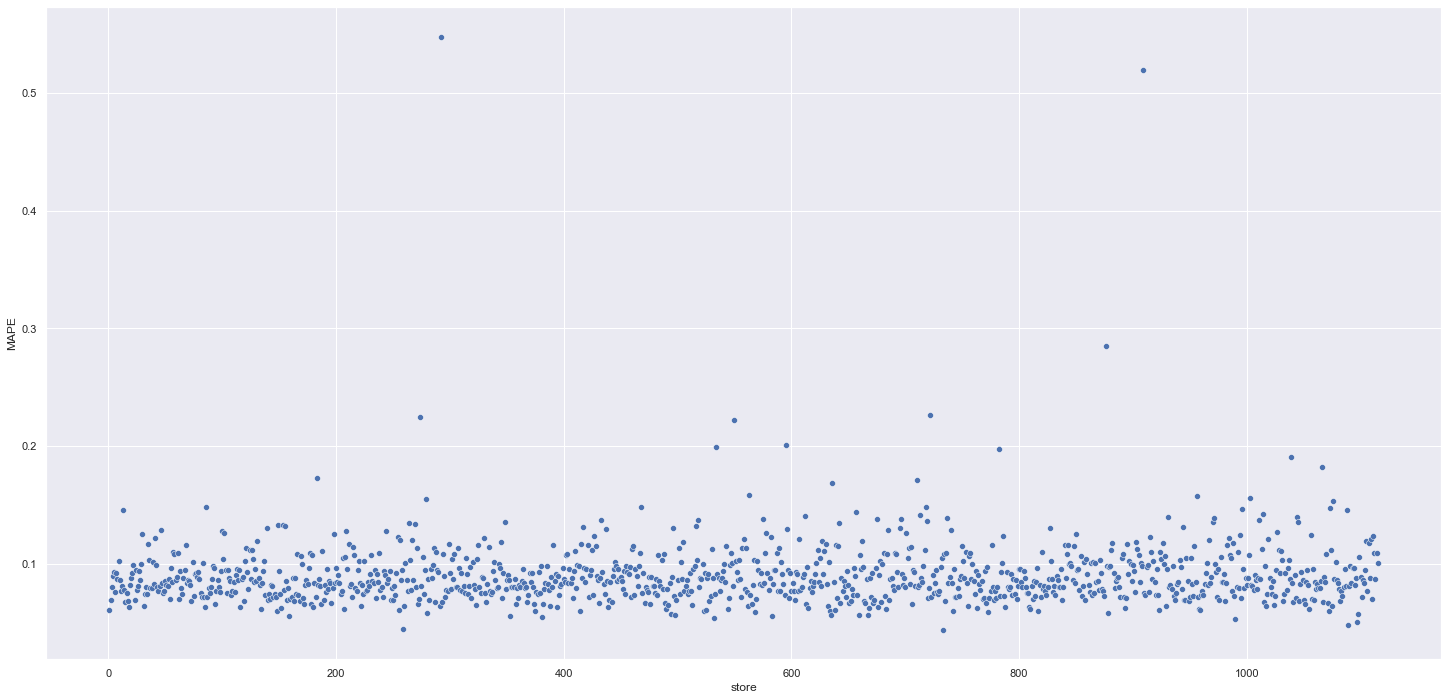

In [264]:
# O gráfico abaixo mostra os erros MAPE para cada loja.
sns.scatterplot(x='store', y='MAPE', data=df92)

In [ ]:
# Podemos verificar no gráfico acima que a maioria das lojas possui um erro MAPE em torno de 10%.

## 9.1. Total Performance

In [270]:
# Exibe abaixo a soma das previsões de vendas para todas as lojas, incluindo o melhor e pior cenário.
df93 = df92[['predictions', 'worst_scenario', 'best_scenario']].apply(lambda x:np.sum(x), axis=0).reset_index().rename(columns={'index': 'Scenarios', 0:'Values'})

# Formata os valores no padrão de moeda Real.
df93['Values'] = df93['Values'].map('R${:,.2f}'.format)
df93

,Scenarios,Values
0,predictions,"R$282,594,816.00"
1,worst_scenario,"R$281,892,300.13"
2,best_scenario,"R$283,297,345.09"


## 9.1. Machine Learning Performance

In [273]:
# Cria uma coluna chamada error com a diferença do valor de venda real menos o valor de venda da predição.
df9['error'] = df9['sales'] - df9['predictions']

# Cria uma coluna chamada error_rate com a porcentagem da diferença entre o valor de venda real e o valor de
# venda predito.
# Um valor igual à 1 significa que o valor predito foi igual ao valor real.
df9['error_rate'] = df9['predictions'] / df9['sales']

<AxesSubplot:xlabel='predictions', ylabel='error'>

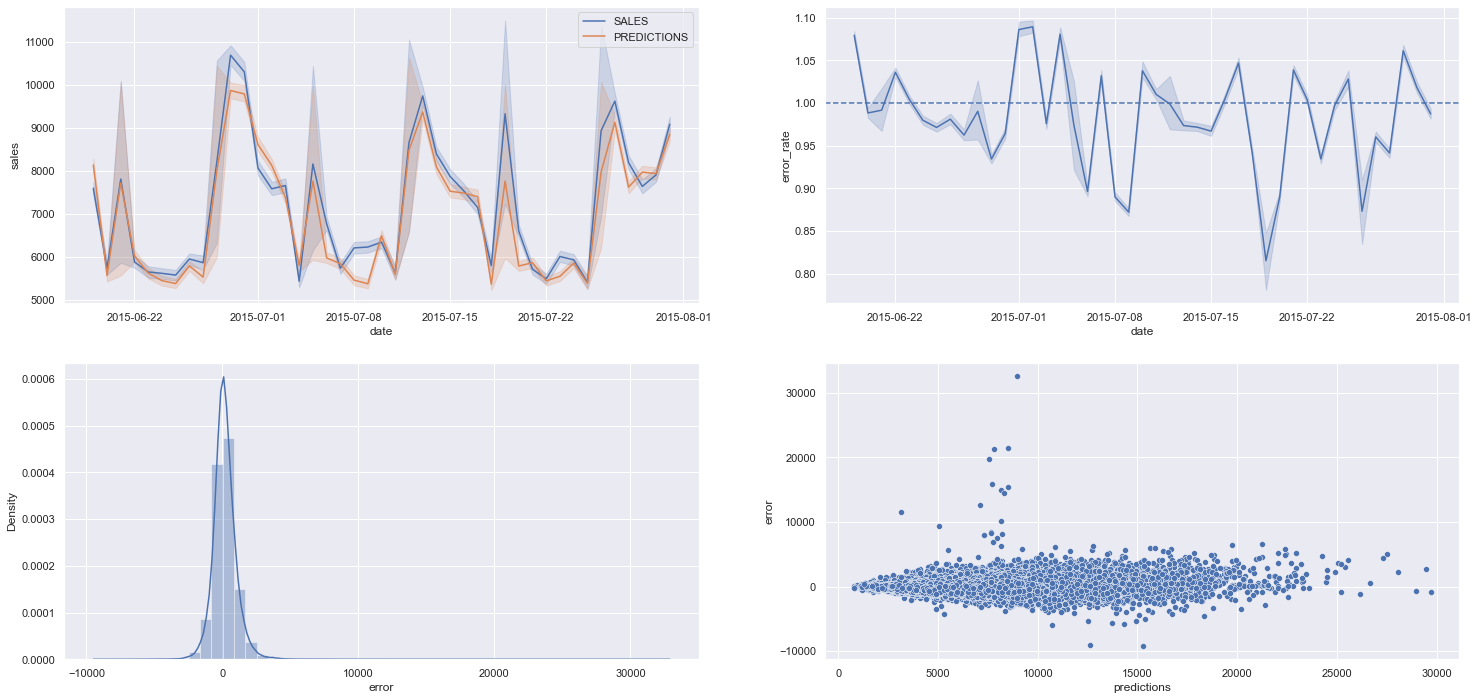

In [279]:
# Cria um gráfico com as vendas reais e as vendas previstas pelo modelo para todas as lojas ao longo das 6 semanas. 
plt.subplot(2,2,1)
sns.lineplot(x='date', y='sales', data=df9, label='SALES')
sns.lineplot(x='date', y='predictions', data=df9, label='PREDICTIONS')

# Cria um gráfico com as taxas de erro diários para todas as lojas ao longo das 6 semanas. 
plt.subplot(2,2,2)
sns.lineplot(x='date', y='error_rate', data=df9)
plt.axhline(1, linestyle='--')  # Cria uma linha no gráfico no valor y=1.

# Cria um gráfico de distribuição do erro.
plt.subplot(2,2,3)
sns.distplot(df9['error'])

# Cria um gráfico de dispersão dos erros por loja.
plt.subplot(2,2,4)
sns.scatterplot(df9['predictions'], df9['error'])

In [ ]:
# Primeiro gráfico - vendas reais e previstas ao longo das seis semanas:
# As sombras representam a variação dos valores reais e previstos para cada loja.
# Isto ocorre pois plotamos os gráficos de todas as vendas para todas as lojas um em cima do outro.
# Portanto, as sombras mostram o valor de venda que varia de uma loja para outra.

# Segundo gráfico - Taxa de erro da previsão em relação ao valor real.
# Representa qual a diferença em porcentagem dos valores previstos em relação aos valore reais.
# O valor á a divisão do valor previsto pelo valor real. 
# Um valor igual à 1 significa que o valor predito foi igual ao valor real.
# Um valor acima de 1, significa que o modelo está superestimando o valor de venda real.
# Um valor abaixo de 1, significa que o modelo está subestimando o valor de venda real.

# Terceiro gráfico - distribuição do erro.
# Mostra que a distribuição do erro está próxima de uma distribuição gaussiana, isto é, uma distribuição normal.

# Quarto gráfico - gráfico de resíduo, entre as valore preditos em relação ao erro.
# Podemos observar ocorrem erros maiores quando o modelo faz predições entre R$6.000,00 e R$10.000,00.


# O terceiro e quarto gráfico são utilizados em análise do resíduo.

# 10.0. PASSO 10 - DEPLOY MODEL TO PRODUCTION

In [262]:
# Executa os comandos abaixo se for iniciar a execução apenas do passo 10 em diante.
# Cria um dicionário param_tuned com os valores que obtiveram os melhores resultados no Hyper Parameter Tuning.
param_tuned = {'n_estimators': 3500,
               'eta': 0.03,
               'max_depth': 9,
               'subsample': 0.7,
               'min_child_weight': 8}

model_xgb_tuned = xgb.XGBRegressor(objective='reg:squarederror',
                         n_estimators = param_tuned['n_estimators'],
                         eta = param_tuned['eta'],
                         max_depth = param_tuned['max_depth'],
                         subsample = param_tuned['subsample'],
                         min_child_weight = param_tuned['min_child_weight'])

# utiliza o caminho abaixo se for iniciar a execução deste notebook do passo 10.
model = pickle.load(open(r'model\model_rossmann.pkl', 'rb'))

## 10.1. Rossmann Class

In [30]:
import pickle
import inflection
import pandas as pd
import numpy as np
import math
import datetime
from numpy import int64

class Rossmann(object):
    def __init__(self):
        self.home_path=r'D:\Data_Science\DS em Produção\repos\DataScience_em_Producao'
        self.competition_distance_scaler   = pickle.load(open(self.home_path + '\parameter\competition_distance_scaler.pkl', 'rb'))
        self.promo_time_week_scaler        = pickle.load(open(self.home_path + '\parameter\promo_time_week_scaler.pkl', 'rb'))
        self.competition_time_month_scaler = pickle.load(open(self.home_path + '\parameter\competition_time_month_scaler.pkl', 'rb'))
        self.year_scaler                   = pickle.load(open(self.home_path + '\parameter\year_scaler.pkl', 'rb'))   
        self.store_type_scaler             = pickle.load(open(self.home_path + '\parameter\store_type_scaler.pkl', 'rb'))  
        
    def data_cleaning(self, df1):
                
        # 1.1 Renomeia as colunas.
        cols_old = ['Store', 'DayOfWeek', 'Date', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday', 'StoreType',
                    'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
                    'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval']

        # Altera o estilo dos nomes das colunas de CamelCase para SnakeCase utilizando a função abaixo.
        snakecase = lambda x: inflection.underscore(x)

        # A função map executa a função snakecase em todas as palavras da lista cols_old. A saída desta função é convertida em uma 
        # lista e armazenada na lista cols_new.
        cols_new = list(map(snakecase, cols_old))

        # Renomeia o nome das colunas no dataset df1.
        df1.columns = cols_new


        ## 1.3 Data Types
        # Altera o tipo dos valore da coluna date de object (string) para data.
        df1['date'] = pd.to_datetime(df1['date'])


        ## 1.5 Fillout NA
        ### 1.5.1. competition_distance
        df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) else x)

        ### 1.5.2. competition_open_since_month
        df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis = 1)

        ### 1.5.3. competition_open_since_year
        df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis = 1)

        ### 1.5.4. promo2_since_week
        df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis = 1)

        ### 1.5.5. promo2_since_year
        df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis = 1)

        ### 1.5.6. promo_interval
        month_map = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', 7:'Jul', 8:'Aug', 9:'Sept', 10:'Oct', 11:'Nov', 12:'Dec'}

        df1['promo_interval'].fillna(0, inplace=True)

        df1['month_map'] = df1['date'].dt.month.map(month_map)

        df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1)


        ## 1.6 Change Type
        df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int64)
        df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int64)
        df1['promo2_since_week'] = df1['promo2_since_week'].astype(int64)
        df1['promo2_since_year'] = df1['promo2_since_year'].astype(int64)
        
        return df1
    
    def feature_engineering(self, df2):
        
        # year
        df2['year'] = df2['date'].dt.year

        # month
        df2['month'] = df2['date'].dt.month

        # day
        df2['day'] = df2['date'].dt.day

        # week of year
        df2['week_of_year'] = df2['date'].dt.isocalendar().week

        # year week
        df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

        # competition since
        df2['competition_since'] = df2.apply(lambda x: datetime.datetime( year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1), axis=1)
        df2['competition_time_month'] = ((df2['date'] - df2['competition_since'])/30).apply(lambda x: x.days).astype(int64)

        # promo since
        df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
        df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w') - datetime.timedelta(days=7))
        df2['promo_time_week'] = ((df2['date'] - df2['promo_since'])/7).apply(lambda x: x.days).astype(int64)

        # assortiment
        df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')

        # state holiday
        df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day')

        # 3.0 PASSO 3.0 - FILTRAGEM DAS VARIÁVEIS
        ## 3.1. Filtragem das Linhas
        df2 = df2[df2['open'] != 0]

        ## 3.2. Seleção das Colunas e das Linha
        cols_drop = ['open',  'promo_interval', 'month_map']
        df2 = df2.drop (cols_drop, axis = 1)
        
        return df2
    
    def data_preparation(self, df5):
        
        ## 5.2. Rescaling
        # competition distance
        df5['competition_distance'] = self.competition_distance_scaler.fit_transform(df5[['competition_distance']].values)

        # competition time month
        df5['competition_time_month'] = self.competition_time_month_scaler.fit_transform(df5[['competition_time_month']].values)

        # promo time week
        df5['promo_time_week'] = self.promo_time_week_scaler.fit_transform(df5[['promo_time_week']].values)

        # year
        df5['year'] = self.year_scaler.fit_transform(df5[['year']].values)

        ## 5.3. Transformação
        ### 5.3.1 Encoding
        # state_holiday - One Hot Encoding
        df5 = pd. get_dummies (df5, prefix=['state_holiday'], columns=['state_holiday'])

        # store_type - Label Encoding
        # Comentei o comando abaixo e criei os próximos dois comandos para substituir este, pois
        # ocorreu o erro: ValueError: could not convert string to float: 'c
        #df5['store_type'] = self.store_type_scaler.fit_transform(df5['store_type'])                                                                                       
        store_type_dict = {'a': 0, 'b': 1, 'c': 2}
        df5['store_type'] = df5['store_type'].map(store_type_dict)
        
        # assortment - Ordinal Encoding
        assortment_dict = { 'basic': 1, 'extra': 2, 'extended': 3}
        df5['assortment'] = df5['assortment'].map(assortment_dict)

        
        ### 5.3.3 Nature Transformation
        # month
        df5['month_sin'] = df5['month'].apply(lambda x: np.sin(x* (2 * np.pi/12)))
        df5['month_cos'] = df5['month'].apply(lambda x: np.cos(x* (2 * np.pi/12)))

        # day
        df5['day_sin'] = df5['day'].apply(lambda x: np.sin(x* (2 * np.pi/30)))
        df5['day_cos'] = df5['day'].apply(lambda x: np.cos(x* (2 * np.pi/30)))

        # week of year
        df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin(x* (2 * np.pi/52)))
        df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos(x* (2 * np.pi/52)))

        # day of week
        df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin(x* (2 * np.pi/7)))
        df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos(x* (2 * np.pi/7)))
        
        cols_selected = ['store', 'promo', 'store_type', 'assortment', 'competition_distance', 'competition_open_since_month', 'competition_open_since_year',
                        'promo2', 'promo2_since_week', 'promo2_since_year', 'competition_time_month', 'promo_time_week', 'month_sin', 'month_cos', 'day_sin',
                        'day_cos', 'week_of_year_sin', 'week_of_year_cos', 'day_of_week_sin', 'day_of_week_cos']
        
        return df5[cols_selected]
    
    def get_prediction(self, model, original_data, test_data):
        # prediction
        pred = model.predict(test_data)
        
        # join pred into the original data
        # Cria uma coluna prediction nos dados originais original_data e retorna para o solicitante.
        original_data['prediction'] = np.expm1(pred)
        
        # No comando abaixo o parâmetro orient determina o tipo de valor do dicionário. orient='records' = chave: valor = list like [{column -> value}, … , {column -> value}]
        # No ccomando abaixo o parâmetro date_format='iso' = ISO8601 = é uma norma internacional para representação de data e hora emitida pela Organização Internacional para Padronização.
        return original_data.to_json(orient='records', date_format='iso')
    

## 10.2. API Handler

In [31]:
# Utiliza a biblioteca Flask para trabalhar em ambiente web.
from flask import Flask, request, Response
import pandas as pd
import pickle
from rossmann.Rossmann import Rossmann

# loading trained model in memory
model = pickle.load(open(r'D:\Data_Science\DS em Produção\repos\DataScience_em_Producao\model\model_rossmann.pkl', 'rb'))

# initialize API.
# Cria uma isntância app da classe Flask.
app = Flask(__name__)

# Cria o end point (URL) que vai receber a requisição.
@app.route('/rossmann/predict', methods=['POST'])   # Define a URL /rossmann/predict para receber as requisições. Aceita apenas os métodos POST.
def rossmann_predict():
    
    # Armazena na variável test_json os dados recebidos no formato json via API.
    test_json = request.get_json()
            
    # Verifica se recebeu algum dado.
    if test_json:
        
        # identifica se recebeu um ou mais dados. Se for um dicionário significa que recebeu apenas um dado.
        if isinstance(test_json, dict):
            
            # Converte o dado no formato json em um dataframe e armazena na variável test_raw.
            test_raw = pd.DataFrame(test_json, index=[0])

        else: 
            # Executa o comando abaixo quando recebe vários jsons concatenados.
            # Converte as chaves do json nos nomes das colunas, armazenando as chaves da primeira linha utilizando o comando columns=test_json[0].keys().
            test_raw = pd.DataFrame(test_json, columns=test_json[0].keys())
        
        # Cria a instância pipeline da classe Rossmann
        pipeline = Rossmann()
        
        # data cleaning
        df1 = pipeline.data_cleaning(test_raw)
        
        # feature engineering
        df2 = pipeline.feature_engineering(df1)
        
        # data preparation
        df3 = pipeline.data_preparation(df2)
        
        # prediction
        df_response = pipeline.get_prediction(model, test_raw, df3)
        
        return df_response
       
    else:
        # Caso não recebeu dado, retorna vazio e o status 200, significando que a requisição funcionou, porém a execução não funcionou. mimetype define que é uma aplicação json.
        return Response('{}', status=200, mimetype='application/json')
                                                                    
    
if __name__ == '__main__':
    app.run('0.0.0.0')  # Executa a instância app no host local.

ModuleNotFoundError: No module named 'rossmann'

## 10.3. API Local Tester

In [32]:
# loading test dataset
# No site do Kaggle existe um dataset test.csv com o desempenho de venda das lojas.
# Carrega os dados de teste test.csv disponível no Kaggle para a variável df10:
df10 = pd.read_csv('data/test.csv', low_memory=False)

In [33]:
df10.head()

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
0,1,1,4,2015-09-17,1.0,1,0,0
1,2,3,4,2015-09-17,1.0,1,0,0
2,3,7,4,2015-09-17,1.0,1,0,0
3,4,8,4,2015-09-17,1.0,1,0,0
4,5,9,4,2015-09-17,1.0,1,0,0


In [34]:
# merge test dataset + store
# No site do Kaggle existe um dataset chamado store.csv com as características das loja.
# O dataset store.csv foi carregado previamente na variável df_store_raw no passo 0.2 Loading Data.
# Grava na variável df_teste o merge entre os datasets df10 e df_store_raw:
df_test = pd.merge(df10, df_store_raw, how='left', on='Store')

# choose store for prediction
# Seleciona a loja com o código 22 para fazer um teste:
df_test = df_test[df_test['Store'] == 22]

# remove closed days
df_test = df_test[df_test['Open'] != 0]
df_test = df_test[~df_test['Open'].isnull()]  # utiliza o simbolo ~ para selecionar as lojas que não possuem valor vazio na variável Open.
df_test = df_test.drop('Id', axis=1)  # Remove a coluna Id que não é utilizada.

In [35]:
df_test.head()

,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
15,22,4,2015-09-17,1.0,1,0,0,a,a,1040.0,NaN,NaN,1,22.0,2012.0,"Jan,Apr,Jul,Oct"
871,22,3,2015-09-16,1.0,1,0,0,a,a,1040.0,NaN,NaN,1,22.0,2012.0,"Jan,Apr,Jul,Oct"
1727,22,2,2015-09-15,1.0,1,0,0,a,a,1040.0,NaN,NaN,1,22.0,2012.0,"Jan,Apr,Jul,Oct"
2583,22,1,2015-09-14,1.0,1,0,1,a,a,1040.0,NaN,NaN,1,22.0,2012.0,"Jan,Apr,Jul,Oct"
4295,22,6,2015-09-12,1.0,0,0,0,a,a,1040.0,NaN,NaN,1,22.0,2012.0,"Jan,Apr,Jul,Oct"


In [36]:
# convert Dataset to json
# No comando abaixo o parâmetro orient determina o tipo de valor do dicionário. orient='records' = chave: valor = list like [{column -> value}, … , {column -> value}]
data = json.dumps(df_test.to_dict(orient='records'))

In [38]:
# Exibe data
data

'[{"Store": 22, "DayOfWeek": 4, "Date": "2015-09-17", "Open": 1.0, "Promo": 1, "StateHoliday": "0", "SchoolHoliday": 0, "StoreType": "a", "Assortment": "a", "CompetitionDistance": 1040.0, "CompetitionOpenSinceMonth": NaN, "CompetitionOpenSinceYear": NaN, "Promo2": 1, "Promo2SinceWeek": 22.0, "Promo2SinceYear": 2012.0, "PromoInterval": "Jan,Apr,Jul,Oct"}, {"Store": 22, "DayOfWeek": 3, "Date": "2015-09-16", "Open": 1.0, "Promo": 1, "StateHoliday": "0", "SchoolHoliday": 0, "StoreType": "a", "Assortment": "a", "CompetitionDistance": 1040.0, "CompetitionOpenSinceMonth": NaN, "CompetitionOpenSinceYear": NaN, "Promo2": 1, "Promo2SinceWeek": 22.0, "Promo2SinceYear": 2012.0, "PromoInterval": "Jan,Apr,Jul,Oct"}, {"Store": 22, "DayOfWeek": 2, "Date": "2015-09-15", "Open": 1.0, "Promo": 1, "StateHoliday": "0", "SchoolHoliday": 0, "StoreType": "a", "Assortment": "a", "CompetitionDistance": 1040.0, "CompetitionOpenSinceMonth": NaN, "CompetitionOpenSinceYear": NaN, "Promo2": 1, "Promo2SinceWeek": 22.

In [39]:
# API Call
# define o end point para onde o pedido será enviado.
#url = 'http://0.0.0.0:5000/rossmann/predict'  # 5000 é a porta padrão do Flask.
url = 'http://192.168.0.7:5000/rossmann/predict'  # 5000 é a porta padrão do Flask.

# informa para a API qual o tipo de dado que ela está recebendo.
header = {'Content-type': 'application/json'}  # define o tipo de requisição json.

data = data

# Envia a requisição para a API
# Quando utiliza o método POST é obrigatório enviar algum dado, por isso foi definido o campo data.
# Armazena a resposta na variável r.
r = requests.post(url, data, headers=header)

print('Status Code {}'.format(r.status_code))

ConnectionError: HTTPConnectionPool(host='192.168.0.7', port=5000): Max retries exceeded with url: /rossmann/predict (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x0000019950243A60>: Failed to establish a new connection: [WinError 10061] Nenhuma conexão pôde ser feita porque a máquina de destino as recusou ativamente'))

In [ ]:
# Converte a varivel r que está no formato json e que foi retornada no requisição da API em um dataframe.
d1 = pd.DataFrame(r.json(), columns=r.json()[0].keys())

In [ ]:
d1.head()

In [ ]:
# Realiza a soma das predições da loja para as próximas 6 semanas.
d2 = d1[['store', 'prediction']].groupby('store').sum().reset_index()

# Se não incluir o parâmetro .values[0], retorna o erro TypeError: unsupported format string passed to Series.__format__
# quando vai exibir o valor de prediction
print('Store Number {} will sell R${:,.2f} in the next 6 weeks'.format(
           d2['store'].values[0],
           d2['prediction'].values[0]) )

In [ ]:
# Exibe a soma das previsões de vendas para a loja 22 para as próximas 6 semanas.
d2

In [ ]:
# Caso se deseje selecionar mais de uma loja, utilizamos o parâmetro isin conforme exemplo abaixo:
# loading test dataset
# No site do Kaggle existe um dataset test.csv com o desempenho de venda das lojas.
# Carrega os dados de teste test.csv disponível no Kaggle para a variável df10:
df10 = pd.read_csv('data/test.csv', low_memory=False)

# merge test dataset + store
# No site do Kaggle existe um dataset chamado store.csv com as características das loja.
# O dataset store.csv foi carregado previamente na variável df_store_raw no passo 0.2 Loading Data.
# Grava na variável df_teste o merge entre os datasets df10 e df_store_raw:
df_test = pd.merge(df10, df_store_raw, how='left', on='Store')

# choose store for prediction
# Seleciona as lojas com o código 24, 12 e 22 para fazer um teste:
df_test = df_test[df_test['Store'].isin([24, 12, 22])]

# remove closed days
df_test = df_test[df_test['Open'] != 0]
df_test = df_test[~df_test['Open'].isnull()]  # utiliza o simbolo ~ para selecionar as lojas que não possuem valor vazio na variável Open.
df_test = df_test.drop('Id', axis=1)  # Remove a coluna Id que não é utilizada.

# convert Dataset to json
# No comando abaixo o parâmetro orient determina o tipo de valor do dicionário. orient='records' = chave: valor = list like [{column -> value}, … , {column -> value}]
data = json.dumps(df_test.to_dict(orient='records'))

# API Call
# define o end point para onde o pedido será enviado.
#url = 'http://0.0.0.0:5000/rossmann/predict'  # 5000 é a porta padrão do Flask.
url = 'http://192.168.0.7:5000/rossmann/predict'  # 5000 é a porta padrão do Flask.

# informa para a API qual o tipo de dado que ela está recebendo.
header = {'Content-type': 'application/json'}  # define o tipo de requisição json.

data = data

# Envia a requisição para a API
# Quando utiliza o método POST é obrigatório enviar algum dado, por isso foi definido o campo data.
# Armazena a resposta na variável r.
r = requests.post(url, data, headers=header)
print('Status Code {}'.format(r.status_code))

# Converte a varivel r que está no formato json e que foi retornada no requisição da API em um dataframe.
d1 = pd.DataFrame(r.json(), columns=r.json()[0].keys())

# Realiza a soma das predições da loja para as próximas 6 semanas.
d2 = d1[['store', 'prediction']].groupby('store').sum().reset_index()

for i in range(len(d2)):
    print('Store Number {} will sell R${:,.2f} in the next 6 weeks'.format(
           d2.loc[i,'store'],
           d2.loc[i,'prediction']) )


## 10.4. API Heroku Tester

In [6]:
# loading test dataset
# No site do Kaggle existe um dataset test.csv com o desempenho de venda das lojas.
# Carrega os dados de teste test.csv disponível no Kaggle para a variável df10:
df10 = pd.read_csv('data/test.csv', low_memory=False)

In [7]:
# merge test dataset + store
# No site do Kaggle existe um dataset chamado store.csv com as características das loja.
# O dataset store.csv foi carregado previamente na variável df_store_raw no passo 0.2 Loading Data.
# Grava na variável df_teste o merge entre os datasets df10 e df_store_raw:
df_test = pd.merge(df10, df_store_raw, how='left', on='Store')

# choose store for prediction
# Seleciona a loja com o código 22 para fazer um teste:
df_test = df_test[df_test['Store'] == 22]

# remove closed days
df_test = df_test[df_test['Open'] != 0]
df_test = df_test[~df_test['Open'].isnull()]  # utiliza o simbolo ~ para selecionar as lojas que não possuem valor vazio na variável Open.
df_test = df_test.drop('Id', axis=1)  # Remove a coluna Id que não é utilizada.

In [8]:
# convert Dataset to json
# No comando abaixo o parâmetro orient determina o tipo de valor do dicionário. orient='records' = chave: valor = list like [{column -> value}, … , {column -> value}]
data = json.dumps(df_test.to_dict(orient='records'))

In [9]:
# Exibe data
data

'[{"Store": 22, "DayOfWeek": 4, "Date": "2015-09-17", "Open": 1.0, "Promo": 1, "StateHoliday": "0", "SchoolHoliday": 0, "StoreType": "a", "Assortment": "a", "CompetitionDistance": 1040.0, "CompetitionOpenSinceMonth": NaN, "CompetitionOpenSinceYear": NaN, "Promo2": 1, "Promo2SinceWeek": 22.0, "Promo2SinceYear": 2012.0, "PromoInterval": "Jan,Apr,Jul,Oct"}, {"Store": 22, "DayOfWeek": 3, "Date": "2015-09-16", "Open": 1.0, "Promo": 1, "StateHoliday": "0", "SchoolHoliday": 0, "StoreType": "a", "Assortment": "a", "CompetitionDistance": 1040.0, "CompetitionOpenSinceMonth": NaN, "CompetitionOpenSinceYear": NaN, "Promo2": 1, "Promo2SinceWeek": 22.0, "Promo2SinceYear": 2012.0, "PromoInterval": "Jan,Apr,Jul,Oct"}, {"Store": 22, "DayOfWeek": 2, "Date": "2015-09-15", "Open": 1.0, "Promo": 1, "StateHoliday": "0", "SchoolHoliday": 0, "StoreType": "a", "Assortment": "a", "CompetitionDistance": 1040.0, "CompetitionOpenSinceMonth": NaN, "CompetitionOpenSinceYear": NaN, "Promo2": 1, "Promo2SinceWeek": 22.

In [11]:
# API Call
# define o end point para onde o pedido será enviado.
url = 'https://rossmann-model-adriano.herokuapp.com//rossmann/predict'

# informa para a API qual o tipo de dado que ela está recebendo.
header = {'Content-type': 'application/json'}  # define o tipo de requisição json.

data = data

# Envia a requisição para a API
# Quando utiliza o método POST é obrigatório enviar algum dado, por isso foi definido o campo data.
# Armazena a resposta na variável r.
r = requests.post(url, data, headers=header)

print('Status Code {}'.format(r.status_code))

Status Code 200


In [12]:
# Converte a varivel r que está no formato json e que foi retornada no requisição da API em um dataframe.
d1 = pd.DataFrame(r.json(), columns=r.json()[0].keys())

In [13]:
d1.head()

,store,day_of_week,date,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,...,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week,prediction
0,22,4,2015-09-17T00:00:00.000Z,1.0,1,regular_day,0,a,basic,1040.0,...,2015,9,17,38,2015-37,2015-09-01T00:00:00.000Z,0,2012-05-21T00:00:00.000Z,173,4302.080566
1,22,3,2015-09-16T00:00:00.000Z,1.0,1,regular_day,0,a,basic,1040.0,...,2015,9,16,38,2015-37,2015-09-01T00:00:00.000Z,0,2012-05-21T00:00:00.000Z,173,4431.127930
2,22,2,2015-09-15T00:00:00.000Z,1.0,1,regular_day,0,a,basic,1040.0,...,2015,9,15,38,2015-37,2015-09-01T00:00:00.000Z,0,2012-05-21T00:00:00.000Z,173,5098.805664
3,22,1,2015-09-14T00:00:00.000Z,1.0,1,regular_day,1,a,basic,1040.0,...,2015,9,14,38,2015-37,2015-09-01T00:00:00.000Z,0,2012-05-21T00:00:00.000Z,173,6076.854980
4,22,6,2015-09-12T00:00:00.000Z,1.0,0,regular_day,0,a,basic,1040.0,...,2015,9,12,37,2015-36,2015-09-01T00:00:00.000Z,0,2012-05-21T00:00:00.000Z,172,2373.831299


In [14]:
d1.shape

(40, 28)

In [15]:
# Realiza a soma das predições da loja para as próximas 6 semanas.
d2 = d1[['store', 'prediction']].groupby('store').sum().reset_index()

# Se não incluir o parâmetro .values[0], retorna o erro TypeError: unsupported format string passed to Series.__format__
# quando vai exibir o valor de prediction
print('Store Number {} will sell R${:,.2f} in the next 6 weeks'.format(
           d2['store'].values[0],
           d2['prediction'].values[0]) )

Store Number 22 will sell R$148,968.16 in the next 6 weeks


In [16]:
# Exibe a soma das previsões de vendas para a loja 22 para as próximas 6 semanas.
d2

,store,prediction
0,22,148968.160767


In [17]:
# Caso se deseje selecionar mais de uma loja, utilizamos o parâmetro isin conforme exemplo abaixo:
# loading test dataset
# No site do Kaggle existe um dataset test.csv com o desempenho de venda das lojas.
# Carrega os dados de teste test.csv disponível no Kaggle para a variável df10:
df10 = pd.read_csv('data/test.csv', low_memory=False)

# merge test dataset + store
# No site do Kaggle existe um dataset chamado store.csv com as características das loja.
# O dataset store.csv foi carregado previamente na variável df_store_raw no passo 0.2 Loading Data.
# Grava na variável df_teste o merge entre os datasets df10 e df_store_raw:
df_test = pd.merge(df10, df_store_raw, how='left', on='Store')

# choose store for prediction
# Seleciona as lojas com o código 24, 12 e 22 para fazer um teste:
df_test = df_test[df_test['Store'].isin([24, 12, 22])]

# remove closed days
df_test = df_test[df_test['Open'] != 0]
df_test = df_test[~df_test['Open'].isnull()]  # utiliza o simbolo ~ para selecionar as lojas que não possuem valor vazio na variável Open.
df_test = df_test.drop('Id', axis=1)  # Remove a coluna Id que não é utilizada.

# convert Dataset to json
# No comando abaixo o parâmetro orient determina o tipo de valor do dicionário. orient='records' = chave: valor = list like [{column -> value}, … , {column -> value}]
data = json.dumps(df_test.to_dict(orient='records'))

# API Call
# define o end point para onde o pedido será enviado.
url = 'https://rossmann-model-adriano.herokuapp.com//rossmann/predict'

# informa para a API qual o tipo de dado que ela está recebendo.
header = {'Content-type': 'application/json'}  # define o tipo de requisição json.

data = data

# Envia a requisição para a API
# Quando utiliza o método POST é obrigatório enviar algum dado, por isso foi definido o campo data.
# Armazena a resposta na variável r.
r = requests.post(url, data, headers=header)
print('Status Code {}'.format(r.status_code))

# Converte a varivel r que está no formato json e que foi retornada no requisição da API em um dataframe.
d1 = pd.DataFrame(r.json(), columns=r.json()[0].keys())

# Realiza a soma das predições da loja para as próximas 6 semanas.
d2 = d1[['store', 'prediction']].groupby('store').sum().reset_index()

for i in range(len(d2)):
    print('Store Number {} will sell R${:,.2f} in the next 6 weeks'.format(
           d2.loc[i,'store'],
           d2.loc[i,'prediction']) )

Status Code 200
Store Number 12 will sell R$212,029.26 in the next 6 weeks
Store Number 22 will sell R$145,771.71 in the next 6 weeks
Store Number 24 will sell R$244,642.97 in the next 6 weeks


In [18]:
d2

,store,prediction
0,12,212029.263428
1,22,145771.708496
2,24,244642.965088
